In [1]:
import os
import qiime2 as q2
import pandas as pd
import numpy as np
from skbio import OrdinationResults, TreeNode
from scipy.stats import pearsonr, spearmanr, ttest_ind
from qiime2.plugins.emperor.actions import biplot
#from qiime2.plugins.qurro.actions import differential_plot as qq2diffplot
from biom import Table
import glob
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from qiime2.plugins.phylogeny.methods import filter_table
#from qiime2.plugins.empress.actions import (community_plot, tree_plot)


import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

# plotting
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')
%matplotlib inline


# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12

def split_taxonomy(taxonomy):
    feat_map = dict(taxonomy.Taxon)
    taxonomy['Taxon'] = [feat_map[feat]
                         if feat in feat_map.keys()
                         else np.nan
                         for feat in taxonomy.index]
    # add taxonomic levels for grouping later (if available)

    def tax_split(tax_id, tax_level): return tax_id.split(
        tax_level)[1].split(';')[0]

    for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                             'f__', 'g__', 's__'],
                            ['kingdom', 'phylum', 'class',
                             'order', 'family', 'genus',
                             'species']):
        if lname not in taxonomy.columns:
            taxonomy_tmp = []
            for tax in taxonomy.Taxon:
                if tax is not np.nan and\
                   level in tax and\
                   len(tax_split(tax, level)) > 0:
                    taxonomy_tmp.append(tax_split(tax,
                                                  level))
                else:
                    taxonomy_tmp.append(np.nan)
            taxonomy[lname] = taxonomy_tmp
    return taxonomy



def differential_plot(diff_df, level, color_by, x_axis, ax, annots,
                      xtitle='log($\\frac{responder}{non-responder}$)',
                      cbartitle='Seeding-Effectiveness',
                      quartile_partition=True,
                      upper=.75, lower=.25, cmap_use='RdYlBu',
                      ntfilter=0, ensure_include = [],
                      n_top_bottom_filter=False,
                      n_top_bottom=50):

    # axis of std
    x_axis_std = x_axis.replace('_mean','_std')
    
    diff_df_grouped = diff_df.groupby(level).mean()
    
    # filter N-total
    keep_ = [k for k,v in dict(diff_df[level].value_counts()).items()
             if v > ntfilter]
    diff_df = diff_df[diff_df[level].isin(keep_)]
    # keep quartiles
    if quartile_partition:
        quant_ = diff_df_grouped[x_axis].quantile([lower, .5, upper]).values
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] < quant_[0]].index)
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] > quant_[-1]].index)
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_ + ensure_include)]
    elif n_top_bottom_filter:  
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] > 0].index[:n_top_bottom//2])
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] <= 0].index[-n_top_bottom//2:])
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_)]
    # remove some chars.
    diff_df[level] = [v_.replace('[','').replace(']','')
                      for v_ in diff_df[level]]
    # plot
    """sns.barplot(y=level,
                x=x_axis,
                palette=cmap_use,
                data=diff_df.sort_values('sort'),
                ax=ax,
                ci=68)"""
    # plot with std
    
    diff_df_grouped = diff_df.groupby(level).mean()
    diff_df_grouped[x_axis] -= diff_df_grouped[x_axis].mean()
    diff_df_grouped = diff_df_grouped.sort_values(x_axis)
    mean_values = diff_df_grouped[x_axis].values
    std_values = diff_df_grouped[x_axis_std].values
    y_labels = [annots[i] for i in diff_df_grouped.index]
    
    y_pos = np.arange(len(mean_values))
    color = cm.ocean_r(np.linspace(.2, 1, len(y_labels)))
    #color = cm.RdBu(np.linspace(0, 1, len(y_labels)))   
    
    pal_ = [c for i, c in zip(y_labels, color)]
    ax.barh(y_pos, mean_values, xerr=std_values, color=pal_,
            align='center', alpha=0.8, ecolor='black', capsize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)

    ax.set_ylabel('')
    ax.set_xlabel(xtitle,
                  color='black',
                  weight='bold',
                  fontsize=22)
    
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax, diff_df_grouped

# all metabolites

In [2]:
# import tables
all_matabs_table = q2.Artifact.load('../data/metabolomics/matched-table-metaball-metaG.qza')
bt_all_matabs_table = all_matabs_table.view(Table)
df_all_matabs_table = pd.DataFrame(bt_all_matabs_table.matrix_data.toarray(),
                                   bt_all_matabs_table.ids('observation'),
                                   bt_all_matabs_table.ids())
metadata = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza').to_dataframe()

# differentials
diffs_metabolomics = pd.read_csv('../results/birdman-metab/metaball_summarized_differentials.tsv', sep='\t', index_col=0)
for col_ in diffs_metabolomics.columns:
    if '_mean' in col_:
        diffs_metabolomics[col_] -= diffs_metabolomics[col_].mean()
    #else:
    #    diffs_metabolomics[col_] = diffs_metabolomics[col_] / np.sqrt(df_all_matabs_table.shape[1])

# make feature map
fecal_metaball = pd.read_excel('../data/metabolomics/BEAM_FBMN2_quant.xlsx', index_col=0,
                               engine='openpyxl')
fecal_metaball = fecal_metaball[['row m/z','row retention time']]
fecal_metaball.index = 'f' + fecal_metaball.index.astype(str)
fecal_metaball['id_plus'] = fecal_metaball.index.astype(str) + ' (' +  [x[:7] for x in fecal_metaball['row m/z'].astype(str)] + ')'
fecal_metaball.id_plus = [x.replace('f','') for x in fecal_metaball.id_plus]
id_feature_map = fecal_metaball['id_plus'].to_dict()


# load annotations 
annotations = pd.read_csv('../data/metabolomics/beam_annotations_nosuspect.tsv', sep='\t', 
                          index_col='#Scan#')
annotations.index = 'f' + annotations.index.astype(str)
# clean up the annotations a bit 
annots = [a[18:] if 'Spectral Match to ' in a else a for a in annotations.Compound_Name]
no_nist = [x[:-12] if 'from NIST14' in x else x for x in annots]
no_ev = [j[:(j.rfind('-')-1)] if ' eV' in j else j for j in no_nist]
annotations['clean_annot'] = no_ev

# merge annotations into fecal_metaball 
fecal_metaball = fecal_metaball.merge(annotations[['clean_annot']], left_index=True, 
                                      right_index=True, how='left')
fecal_metaball['clean_annot_plus'] = fecal_metaball['clean_annot'] + ' (' + np.round(fecal_metaball['row m/z'], 3).astype('str') + ')'
fecal_metaball['clean_annot_plus'].fillna(value=fecal_metaball['id_plus'], inplace=True)
annot_map = dict(zip(fecal_metaball['id_plus'], fecal_metaball['clean_annot_plus']))

df_all_matabs_table.index = [id_feature_map[x] for x in df_all_matabs_table.index]
diffs_metabolomics['ids'] = [id_feature_map[x] for x in diffs_metabolomics.index]
diffs_metabolomics.index = [id_feature_map[x] for x in diffs_metabolomics.index]

In [3]:
table_metag = q2.Artifact.load('../data/metaG/metaG-matched-table.qza')
metadata_metag = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza').to_dataframe()
tree_metag = q2.Artifact.load('../data/metaG/wol_tree.qza')
table_metag = filter_table(table_metag, tree_metag).filtered_table
bt_table_metag = table_metag.view(Table)

coverage = pd.read_csv('../data/coverage.tsv', sep='\t', index_col=0)
coverage = coverage[coverage.coverage_ratio > 0.5]

# filter and match the table
n_features, n_samples = bt_table_metag.shape
min_feature_frequency = 10
min_feature_count = 0
min_sample_count = 500000
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
    
    
bt_table_metag = bt_table_metag.filter(set(coverage.index) & set(bt_table_metag.ids('observation')),
                                       axis='observation')
bt_table_metag = bt_table_metag.filter(bt_table_metag.ids()[(bt_table_metag.sum('sample') > min_sample_count)])
bt_table_metag = bt_table_metag.filter(observation_filter, axis='observation')
bt_table_metag = bt_table_metag.filter(frequency_filter, axis='observation')
metadata_metag = metadata_metag.reindex(bt_table_metag.ids())

taxonomy = q2.Artifact.load('../data/metaG/wol_taxonomy.qza').view(q2.Metadata).to_dataframe()
taxonomy = split_taxonomy(taxonomy)
taxonomy = taxonomy.dropna(subset=['genus'])
taxonomy = taxonomy[~taxonomy.genus.isin(['Haemophilus','Yersinia','Brachyspira','Vibrio','Basfia',
                                          'Gallibacterium','Azospirillum'])]
taxonomy = taxonomy[~taxonomy.species.isin(['Acinetobacter sp. CAG:196','Dialister invisus CAG:218',
                                            'Sutterella wadsworthensis CAG:135', 'Bacillus sp. CAG:988', 
                                            'Candidatus Methanomassiliicoccus intestinalis',])]
taxonomy['strain'] = taxonomy.species + ' (' + taxonomy.index + ')'


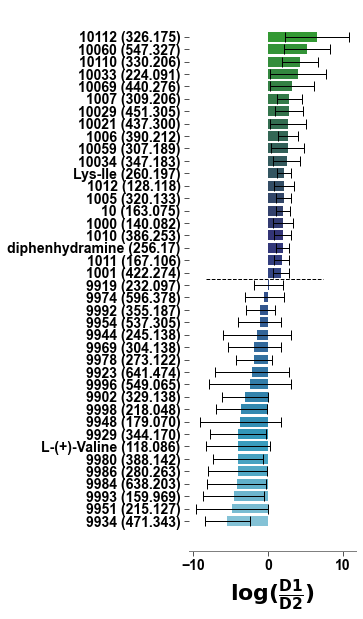

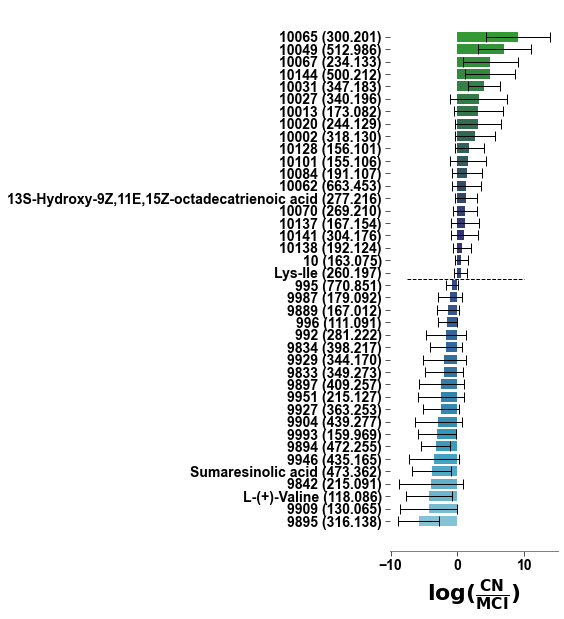

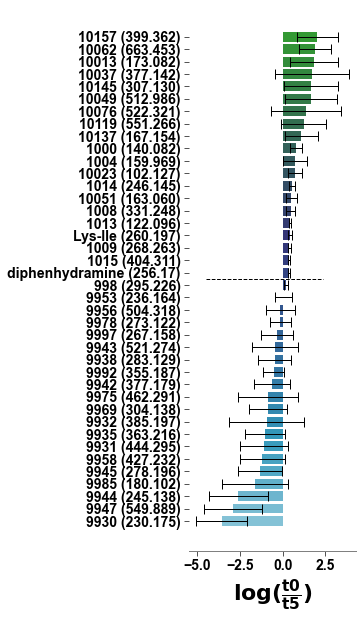

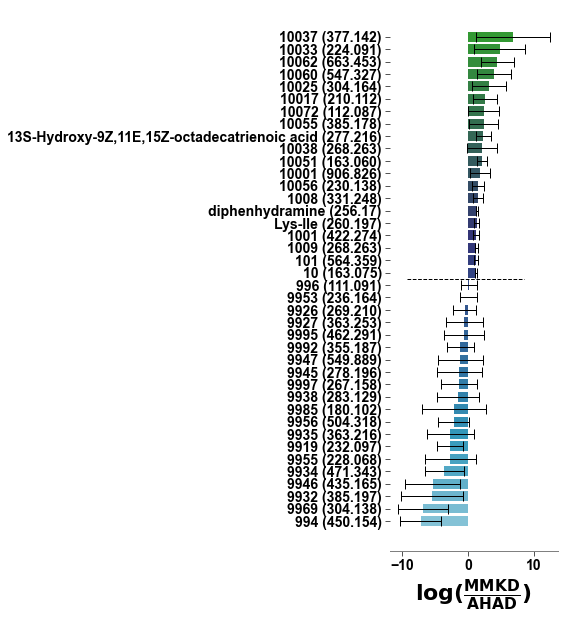

In [4]:
diff_plot = {"D1:D2":"first_diet_mean",
             "CN:MCI":"cog[T.NC]_mean",
             "t0:t5":"timepoint_encoded_mean",
             "MMKD:AHAD":"diet_nocross[T.Ketogenic Diet]_mean"}


metab_diff_df_plot = diffs_metabolomics.copy()

level = 'ids'

birdman_filttmp = {}

for label, diff_col in diff_plot.items():
    
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 10))

    metab_comparedf = metab_diff_df_plot.copy()
    metab_comparedf = metab_comparedf[metab_comparedf[diff_col].abs() > (metab_comparedf[diff_col.replace('_mean','_std')].abs()/2)]

    title_ = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label.split(':')[0], label.split(':')[1])
    ax, df_tmp = differential_plot(metab_comparedf,
                                   level, diff_col, diff_col,
                                   ax,
                                   annot_map,
                                   quartile_partition=False,
                                   ntfilter=0,
                                   n_top_bottom_filter=True,
                                   n_top_bottom=40,
                                   xtitle=title_)
    birdman_filttmp[label] = df_tmp

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    #ax.set_xlim(-3, 3)
    #ax.spines['bottom'].set_bounds(-2, 2)
    ax.axhline((len(list(ax.get_yticklabels())) // 2) - .5,
               c='black', ls='--', lw=1,
               xmin=0.1, xmax=0.8)

    
    #plt.tight_layout()
    """plt.savefig('../results/figures/ranking_%s.pdf' % (diff_col),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.savefig('../results/figures/low-res-ranking_%s.png' % (diff_col),dpi=250, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')"""
    plt.show()
    

In [5]:
num_ = birdman_filttmp['MMKD:AHAD'].index[-5:]
den_ = birdman_filttmp['MMKD:AHAD'].index[:5]
df_all_matabs_table_ps = df_all_matabs_table.copy() + 0.1
metadata_lr = metadata.copy().reindex(df_all_matabs_table_ps.columns)
metadata_lr['log_ratio'] = df_all_matabs_table_ps.loc[num_, :].sum(0) - df_all_matabs_table_ps.loc[den_, :].sum(0)
metadata_lr.head(5)


age anonymized_name bmi_pbl           box_name cog_visit_date  \
13662.5556815  60         1263024      21  31102 Stool Box 1        2/25/16   
13662.5556668  63         1263011   22.26  31102 Stool Box 1        6/11/15   
13662.5556717  66         1263017    27.8  31102 Stool Box 1        3/28/16   
13662.5556776  55         1263021   41.46  31102 Stool Box 1       11/30/15   
13662.5556749  57         1263019   30.26  31102 Stool Box 1        1/12/16   

              collection_timestamp                            description  \
13662.5556815           2016-02-23        fecal sample Post 1 3BCCR001024   
13662.5556668           2015-06-17        fecal sample Post 2 3BSLA000746   
13662.5556717           2016-03-28  fecal sample FU 1 / Pre 2 3TFBO000818   
13662.5556776           2015-12-01        fecal sample Post 2 3CDMA000951   
13662.5556749           2016-01-28          fecal sample FU 2 3LDMO000125   

               elevation           empo_1  empo_2  ...     timepoint  \
13662.5556815      300.0  Host-associated  Animal  ...        Post 1   
13662.5556668      300.0  Host-associated  Animal  ...        Post 2   
13662.5556717      300.0  Host-associated  Animal  ...  FU 1 / Pre 2   
13662.5556776      300.0  Host-associated  Animal  ...        Post 2   
13662.5556749      300.0  Host-associated  Animal  ...          FU 2   

                  title     tube_id uom visit_type  cog  \
13662.5556815  BEAM_U19  0005556815  mg  POSTA-COG   NC   
13662.5556668  BEAM_U19  0005556668  mg  POSTA-COG   NC   
13662.5556717  BEAM_U19  0005556717  mg   PREB-COG   NC   
13662.5556776  BEAM_U19  0005556776  mg  POSTA-COG   NC   
13662.5556749  BEAM_U19  0005556749  mg   POSTB-FU  MCI   

                                diet    diet_nocross timepoint_encoded  \
13662.5556815         Ketogenic Diet  Ketogenic Diet               2.0   
13662.5556668               AHA Diet        AHA Diet               2.0   
13662.5556717  Keto-to-AHA Crossover        AHA Diet               3.0   
13662.5556776               AHA Diet        AHA Diet               2.0   
13662.5556749               AHA Diet        AHA Diet               5.0   

                  log_ratio  
13662.5556815  3.099645e+06  
13662.5556668  0.000000e+00  
13662.5556717 -9.473533e+05  
13662.5556776 -8.019180e+06  
13662.5556749 -2.248461e+05  

[5 rows x 62 columns]

In [6]:
def diet_plotting_col(x):
    if x['timepoint_encoded']==3: 
        if x['diet']=='AHA-to-Keto Crossover':
            return 'AHA Washout'
        elif x['diet']=='Keto-to-AHA Crossover':
            return 'Keto Washout'
    elif x['timepoint_encoded']==5:
        if x['diet']=='AHA Diet':
            return 'AHA Washout'
        elif x['diet']=='Ketogenic Diet':
            return 'Keto Washout'
    return x['diet'] 

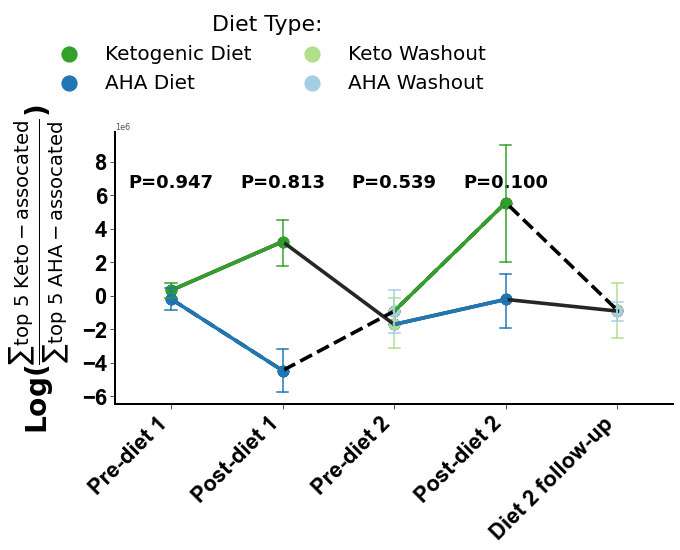

In [7]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
            'AHA Washout':'#a6cee3',
            'Keto Washout':'#b2df8a',
            'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)



axn_i = 0

orddf = metadata_lr.copy()

"""denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
num_use_label = [x.replace('[', '').replace(']', '') for x in num_]

label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
"""
label_x = 'Log($\\frac{\mathrm{\\sum{top\,\,5\,\,Keto-assocated}}}{\mathrm{\\sum{top\,\,5\,\,AHA-assocated}}}$)'

sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
              data=orddf, color='black', ci=None, ax=ax,
              linestyles=['-','--'], errwidth=0)

# draw from point 1 to point 2 
# make nans at PC1 for everything except point1 and point2 
orddf_12 = orddf.copy()
orddf_12.loc[orddf_12['timepoint_encoded'] > 2, 'log_ratio'] = np.nan
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_nocross',
             data=orddf_12, palette=cmap_man, ax=ax, ci=None)

# draw from point 3 to point 4 
# make nans at PC1 for everything except point3 and point4 
orddf_34 = orddf.copy()
orddf_34.loc[(orddf_34['timepoint_encoded'] < 3) | (orddf_34['timepoint_encoded'] == 5),'log_ratio'] = np.nan
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_nocross',
             data=orddf_34, palette=cmap_man, ax=ax, ci=None)

orddf['diet_plotting'] = orddf.apply(diet_plotting_col, axis=1)
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_plotting',
              data=orddf, ci=68, ax=ax, palette=cmap_man,
              errwidth=1.5, capsize=0.1, join=False)

relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 
                 3:'Pre-diet 2', 4:'Post-diet 2', 
                 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(22)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=28)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(0, 8)
ax.set_ylim(0, 8)"""

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=24,
              fontsize=24)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[6:], labels[6:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=24,
              fontsize=24)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                 orddf,
                 groups=orddf["host_subject_id"])
mdf = md.fit()
mdf_table = mdf.summary().tables[1]

for x_i, ind in enumerate(['Period[T.Pre-diet 1]', 'Period[T.Post-diet 1]',
                           'Period[T.Pre-diet 2]', 'Period[T.Post-diet 2]']):

    p_str = "P=%s" % (mdf_table.loc[ind, 'P>|z|'])
    ax.text(x_i , 6.5e6,
            p_str,
            horizontalalignment='center',
            fontsize=18, color='black', weight='semibold')

    
plt.show()


In [8]:
mdf_table

Coef.     Std.Err.       z  P>|z|  \
Intercept                     -204230.527  2217181.992  -0.092  0.927   
Diet[T.Ketogenic Diet]        3090711.474   982030.183   3.147  0.002   
Period[T.Post-diet 1]          365637.025  1545201.361   0.237  0.813   
Period[T.Post-diet 2]         2509881.863  1524334.730   1.647  0.100   
Period[T.Pre-diet 1]           101865.874  1545201.361   0.066  0.947   
Period[T.Pre-diet 2]          -924499.372  1504993.597  -0.614  0.539   
cog[T.NC]                    -2564703.103  1337752.800  -1.917  0.055   
Sequence                       -70826.461  1385077.070  -0.051  0.959   
Group Var               4123565053185.351   807099.164                  

                              [0.025       0.975]  
Intercept               -4549827.378  4141366.324  
Diet[T.Ketogenic Diet]   1165967.683  5015455.264  
Period[T.Post-diet 1]   -2662901.991  3394176.041  
Period[T.Post-diet 2]    -477759.308  5497523.034  
Period[T.Pre-diet 1]    -2926673.142  3130404.890  
Period[T.Pre-diet 2]    -3874232.620  2025233.876  
cog[T.NC]               -5186650.412    57244.206  
Sequence                -2785527.634  2643874.712  
Group Var

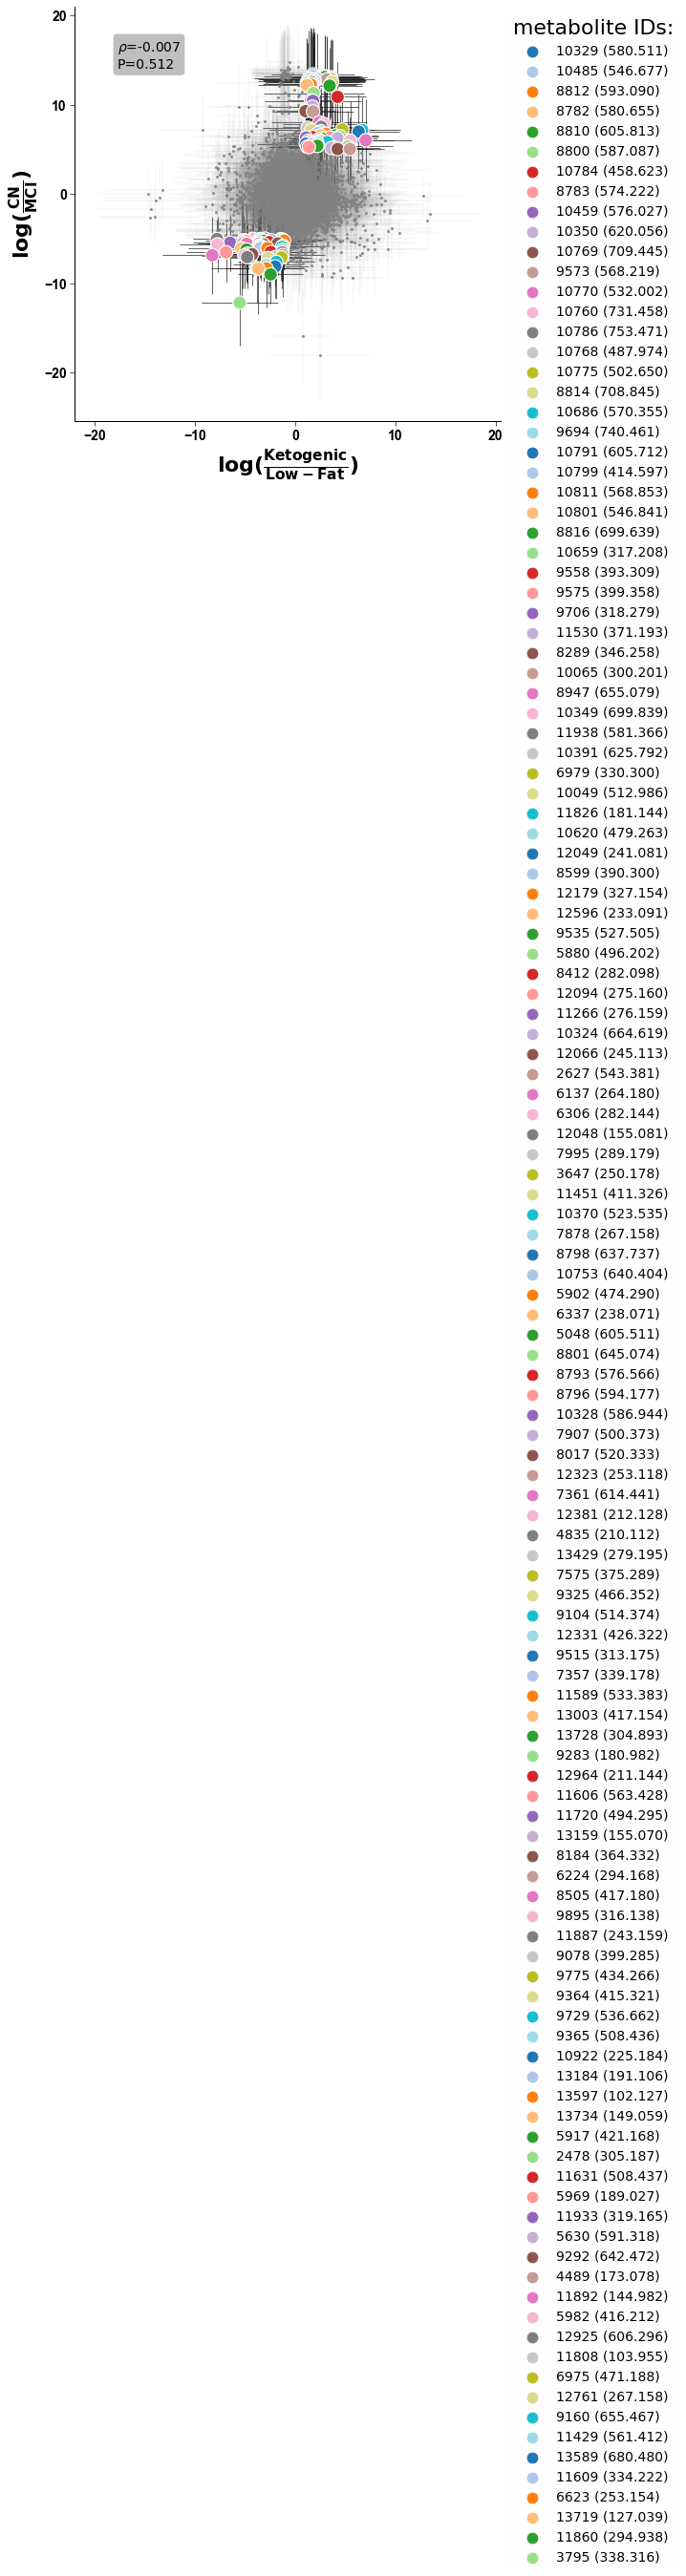

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
#micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]
micro_comparedf = diffs_metabolomics.copy()
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]
rho_, p_ = spearmanr(micro_comparedf['cog[T.NC]_mean'].values,
                     micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].values)
stats_txt = "$\\rho$=%.3f\nP=%.3f" % (rho_, p_)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
ax.text(0.1, 0.85, stats_txt, transform=ax.transAxes, bbox=props, ha='left', fontsize=14)

cut_off_x = 1
cut_off_y = 5
micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -1  * cut_off_x) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1  * cut_off_y) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > cut_off_x)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > cut_off_y)))]
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('ids')

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='ids', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)

handles, labels_scatter = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels_scatter[:],
                   loc=2, 
                         bbox_to_anchor=(1, 1),
                         prop={'size':14},
                         title="metabolite IDs:",
                         fancybox=True, framealpha=.01,
                         ncol=1, markerscale=5.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

In [10]:
num_ = labels_scatter[:5]
den_ = labels_scatter[-5:]
df_all_matabs_table_ps = df_all_matabs_table.copy() + 0
metadata_lr = metadata.copy().reindex(df_all_matabs_table_ps.columns)
metadata_lr['log_ratio'] = df_all_matabs_table_ps.loc[num_, :].sum(0) - df_all_matabs_table_ps.loc[den_, :].sum(0)
metadata_lr.head(5)


age anonymized_name bmi_pbl           box_name cog_visit_date  \
13662.5556815  60         1263024      21  31102 Stool Box 1        2/25/16   
13662.5556668  63         1263011   22.26  31102 Stool Box 1        6/11/15   
13662.5556717  66         1263017    27.8  31102 Stool Box 1        3/28/16   
13662.5556776  55         1263021   41.46  31102 Stool Box 1       11/30/15   
13662.5556749  57         1263019   30.26  31102 Stool Box 1        1/12/16   

              collection_timestamp                            description  \
13662.5556815           2016-02-23        fecal sample Post 1 3BCCR001024   
13662.5556668           2015-06-17        fecal sample Post 2 3BSLA000746   
13662.5556717           2016-03-28  fecal sample FU 1 / Pre 2 3TFBO000818   
13662.5556776           2015-12-01        fecal sample Post 2 3CDMA000951   
13662.5556749           2016-01-28          fecal sample FU 2 3LDMO000125   

               elevation           empo_1  empo_2  ...     timepoint  \
13662.5556815      300.0  Host-associated  Animal  ...        Post 1   
13662.5556668      300.0  Host-associated  Animal  ...        Post 2   
13662.5556717      300.0  Host-associated  Animal  ...  FU 1 / Pre 2   
13662.5556776      300.0  Host-associated  Animal  ...        Post 2   
13662.5556749      300.0  Host-associated  Animal  ...          FU 2   

                  title     tube_id uom visit_type  cog  \
13662.5556815  BEAM_U19  0005556815  mg  POSTA-COG   NC   
13662.5556668  BEAM_U19  0005556668  mg  POSTA-COG   NC   
13662.5556717  BEAM_U19  0005556717  mg   PREB-COG   NC   
13662.5556776  BEAM_U19  0005556776  mg  POSTA-COG   NC   
13662.5556749  BEAM_U19  0005556749  mg   POSTB-FU  MCI   

                                diet    diet_nocross timepoint_encoded  \
13662.5556815         Ketogenic Diet  Ketogenic Diet               2.0   
13662.5556668               AHA Diet        AHA Diet               2.0   
13662.5556717  Keto-to-AHA Crossover        AHA Diet               3.0   
13662.5556776               AHA Diet        AHA Diet               2.0   
13662.5556749               AHA Diet        AHA Diet               5.0   

                   log_ratio  
13662.5556815       0.000000  
13662.5556668       0.000000  
13662.5556717       0.000000  
13662.5556776       0.000000  
13662.5556749 -258405.342672  

[5 rows x 62 columns]

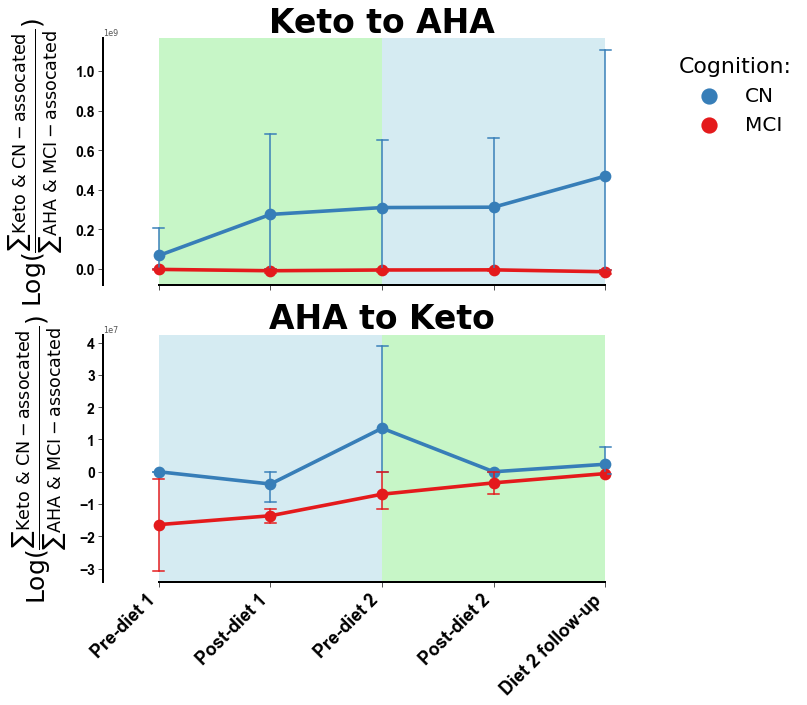

In [11]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,1, figsize=(10,10), sharex=True)

subset_use = [1, 2]
subset_use_label = {1.0:'Keto to AHA', 2.0:'AHA to Keto'}

for (axn_i, ax), fsub in zip(enumerate(axn.flatten()), subset_use):

    orddf = metadata_lr.copy().dropna(subset=['first_diet'])
    orddf = orddf[orddf.first_diet == fsub]

    #if fsub == 2:
    #    orddf = orddf[~((orddf.timepoint_encoded == 5.0) & (orddf.cog == 'MCI'))]
    
    ax.set_title(subset_use_label[fsub],
                  color='black',
                  weight='bold',
                  fontsize=33)
    
    if fsub == 1:
        # keto
        ax.axvspan(0, 2, facecolor='lightgreen', alpha=0.5)
        # low-fat
        ax.axvspan(2, 4, facecolor='lightblue', alpha=0.5)
    else:
        # low-fat
        ax.axvspan(0, 2, facecolor='lightblue', alpha=0.5)
        # keto
        ax.axvspan(2, 4, facecolor='lightgreen', alpha=0.5)

    denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in num_]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    #label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
    #                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
    label_x = 'Log($\\frac{\mathrm{\sum{Keto\,\,&\,\,CN-assocated}}}{\mathrm{\sum{AHA\,\,&\,\,MCI-assocated}}}$)'

    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded',
                  hue='cog',
                 data=orddf, palette=cmap_man,
                  ci=95, ax=ax,
                 errwidth=1.5,
                  capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='normal',
                  labelpad=10,
                  fontsize=25)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    """ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
                                 orddf['log_ratio'].max().round(1) - 2)
    ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
                 orddf['log_ratio'].max().round(1) - 2)"""

    if axn_i < 2:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.legend_.remove()
        if axn_i== 0:

            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[:],
                               [l.replace('NC','CN') for l in labels[:]],
                               loc=2, 
                                     bbox_to_anchor=(1, 1.),
                                     prop={'size':20},
                                     title="Cognition:",
                                     fancybox=False, framealpha=.0,
                                     ncol=1, markerscale=1.5)
            legend.get_title().set_fontsize('22')
            # increase the line width in the legend 
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        ax.legend_.remove()
    
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    
    

plt.show()


# microbiome related

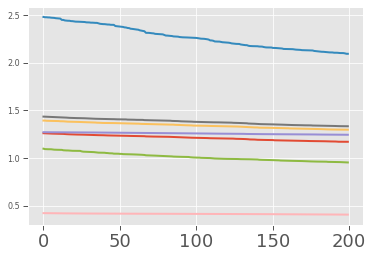

Akkermansia muciniphila  Alistipes sp. CAG:514  \
8885 (162.906)                 0.421073               2.151248   
9225 (439.142)                 1.150991               1.804427   
8271 (415.321)                -0.808103               0.179397   
8891 (330.176)                 1.016115               2.247081   
7573 (345.237)                 1.166827               0.758813   

                Clostridium sp. CAG:568  Akkermansia muciniphila CAG:154  \
8885 (162.906)                 0.729365                         0.474480   
9225 (439.142)                -0.202578                         1.307590   
8271 (415.321)                 1.250900                        -0.924100   
8891 (330.176)                -0.401991                         1.156680   
7573 (345.237)                -0.829609                         1.328719   

                Akkermansia muciniphila  Akkermansia sp. UNK.MGS-1  \
8885 (162.906)                 0.447354                   0.589689   
9225 (439.142)                 1.262485                   0.997215   
8271 (415.321)                -0.909428                  -0.507705   
8891 (330.176)                 1.123902                   1.023826   
7573 (345.237)                 1.291590                   0.853167   

                Bifidobacterium adolescentis  
8885 (162.906)                     -0.085516  
9225 (439.142)                      0.269163  
8271 (415.321)                     -0.385559  
8891 (330.176)                      0.188859  
7573 (345.237)                      0.407757

In [12]:
from scipy import stats


# from the previous notebook
# G000160055
diff_microbes = ['G000020225','G000431015','G000434395','G000436395','G000723745','G000980515','G000010425']
# get the all metabolomics results
mmvec_conditionals_df = q2.Artifact.load('../results/mmvec/fecalall-microbe-model-conditionals.qza').view(pd.DataFrame)
mmvec_conditionals_df.index = [id_feature_map[x.replace('metab','f')] for x in mmvec_conditionals_df.index]
mmvec_conditionals_df = mmvec_conditionals_df.loc[set(mmvec_conditionals_df.index) & set(diffs_metabolomics.index),:]
mmvec_biplot = q2.Artifact.load('../results/mmvec/fecalall-microbe-model-biplot.qza')

mmvec_conditionals_df = pd.DataFrame(stats.zscore(mmvec_conditionals_df, axis=1), 
                                     mmvec_conditionals_df.index,
                                     mmvec_conditionals_df.columns)

# take top k ranked metabolites for each microbe
k = 200
top_k = []
for diff_microbes_c in diff_microbes:
    plt.plot(mmvec_conditionals_df[diff_microbes_c].sort_values(ascending=False)[:k].values)
    top_k += list(mmvec_conditionals_df[diff_microbes_c].sort_values(ascending=False).index[:k])
plt.show()
mmvec_conditionals_subset = mmvec_conditionals_df.loc[set(top_k), diff_microbes]
#mmvec_conditionals_subset = mmvec_conditionals_df.loc[:, diff_microbes].copy()

# label taxonomy
taxonomy = q2.Artifact.load('../data/metaG/wol_taxonomy.qza').view(q2.Metadata).to_dataframe()
taxonomy = split_taxonomy(taxonomy)
taxonomy = taxonomy.dropna(subset=['genus'])
taxonomy = taxonomy[~taxonomy.genus.isin(['Haemophilus','Yersinia','Brachyspira','Vibrio','Basfia',
                                          'Gallibacterium','Azospirillum'])]
taxonomy = taxonomy[~taxonomy.species.isin(['Acinetobacter sp. CAG:196','Dialister invisus CAG:218',
                                            'Sutterella wadsworthensis CAG:135', 'Bacillus sp. CAG:988', 
                                            'Candidatus Methanomassiliicoccus intestinalis',])]
taxonomy['strain'] = taxonomy.species + ' (' + taxonomy.index + ')'
mmvec_conditionals_subset.columns = taxonomy.loc[diff_microbes, 'species'].values

mmvec_conditionals_subset.head(5)
    


In [13]:
#mmvec_conditionals_subset['ps'] = [ketodf.loc[x, 'keto'] for x in mmvec_conditionals_subset.index]

gene_color_map = {'no':'#377eb8',
                  'yes':'#4daf4a'}

#metabclass = mmvec_conditionals_subset.pop("ps")
#row_colors = metabclass.map(gene_color_map)

#mmvec_conditionals_subset.loc['sp', :] = [taxonomy.loc[str(i), 'species'].replace('_','').replace(']','').replace('[','').lstrip().rstrip()
#                                          for i in mmvec_conditionals_subset.columns]

#sp_dict = taxonomy[taxonomy.species.isin(use_sp)]['species'].to_dict()
#mmvec_conditionals_subset.columns = [sp_dict[x] for x in mmvec_conditionals_subset.columns]

mmvec_conditionals_subset.loc['sp', :] = [i
                                          for i in mmvec_conditionals_subset.columns]
use_sp = mmvec_conditionals_subset.columns
taxonclass = mmvec_conditionals_subset.T.pop('sp').dropna()
#color = cm.RdBu(np.linspace(0, 1, len(use_sp)))  
#micro_color_map = {sp:to_hex(c) for sp, c in zip(use_sp, color)}
micro_color_map= {'Akkermansia muciniphila':'#4daf4a', 
        'Dialister invisus':'#4daf4a',
        'Alistipes sp. CAG:514':'#377eb8', 
                  'Bifidobacterium adolescentis':'#4daf4a',
        'Akkermansia muciniphila CAG:154':'#4daf4a',
        'Clostridium sp. CAG:568':'#377eb8',
        'Akkermansia muciniphila':'#4daf4a', 
        'Akkermansia sp. UNK.MGS-1':'#4daf4a'}
col_colors = taxonclass.map(micro_color_map)

mmvec_conditionals_subset = mmvec_conditionals_subset.drop('sp')
mmvec_conditionals_subset = mmvec_conditionals_subset.astype(float)



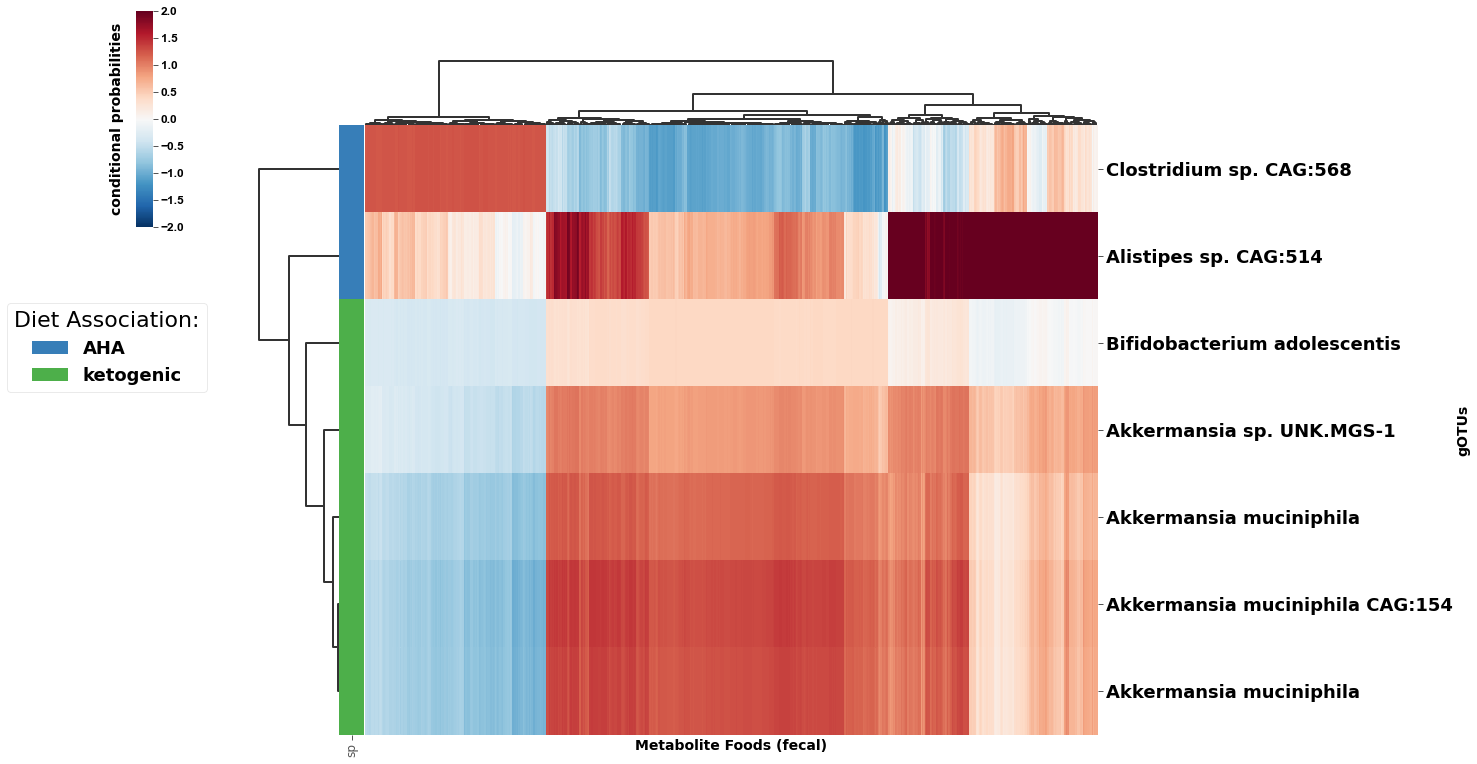

In [14]:
from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)

g = sns.clustermap(mmvec_conditionals_subset.T,
                   vmax=2.0,
                   vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   #col_colors=col_colors,
                   row_colors=col_colors,
                   yticklabels=True,
                   xticklabels=False,
                   figsize=(15, 10),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=None)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','ketogenic').replace('no','AHA') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('conditional probabilities', rotation=90, 
                 labelpad=-75,
                 fontsize=14, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=18, weight='bold',)

g.ax_heatmap.set_ylabel('gOTUs' ,color='black',weight='bold',fontsize=14)
g.ax_heatmap.set_xlabel('Metabolite Foods (fecal)' ,color='black',weight='bold',fontsize=14)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
"""

plt.show()



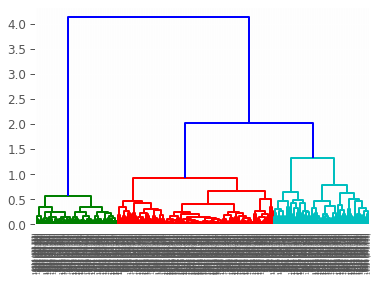

In [15]:
import seaborn
import scipy

#g = seaborn.clustermap(df,method='average')
#df = mmvec_conditionals_subset.loc[mmvec_conditionals_subset.sem(1) > 0.25, :].copy()
df = mmvec_conditionals_subset.copy()
den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_col.linkage,
                                         labels = df.index,
                                         color_threshold=2)  
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

clusters = get_cluster_classes(den)

cluster = []
for i in df.index:
    included=False
    for j in clusters.keys():
        if i in clusters[j]:
            cluster.append(j)
            included=True
    if not included:
        cluster.append(None)

df["cluster"] = cluster


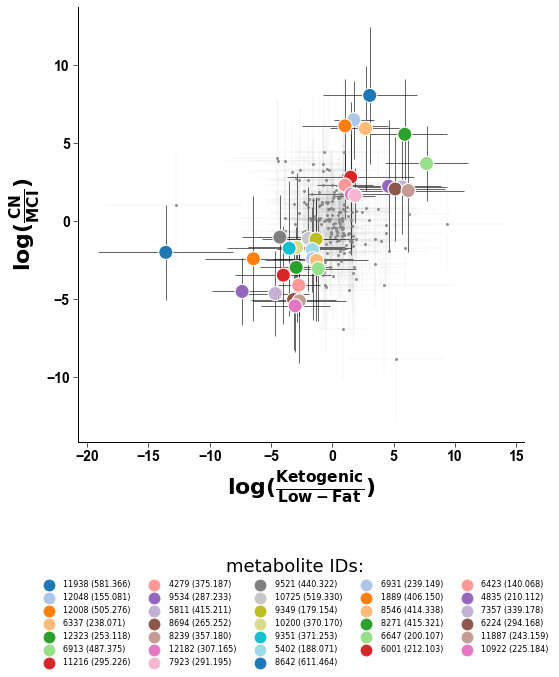

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
#micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]

#micro_comparedf = diffs_metabolomics.loc[mmvec_conditionals_df_subset.index, :].copy().dropna()
micro_comparedf = diffs_metabolomics.loc[df[df.cluster.isin(['g'])].index, :].copy().dropna()

#micro_comparedf = micro_comparedf.drop(['13734 (149.059)'])

micro_comparedf[diff_col] -= micro_comparedf[diff_col].mean()
micro_comparedf['cog[T.NC]_mean'] -= micro_comparedf['cog[T.NC]_mean'].mean()
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]
rho_, p_ = spearmanr(micro_comparedf['cog[T.NC]_mean'].values,
                     micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].values)
stats_txt = "$\\rho$=%.3f\nP=%.3f" % (abs(rho_), p_)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
#ax.text(0.1, 0.85, stats_txt, transform=ax.transAxes, bbox=props, ha='left', fontsize=14)

cut_off_x = 1
cut_off_y = 1
micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -1  * cut_off_x) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1  * cut_off_y) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > cut_off_x)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > cut_off_y)))]
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('ids')

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='ids', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)

handles, labels_scatter = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels_scatter[:],
                   loc=2, 
                         bbox_to_anchor=(-0.1, -0.25),
                         prop={'size':8},
                         title="metabolite IDs:",
                         fancybox=True, framealpha=.01,
                         ncol=5, markerscale=5.5)
legend.get_title().set_fontsize('18')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

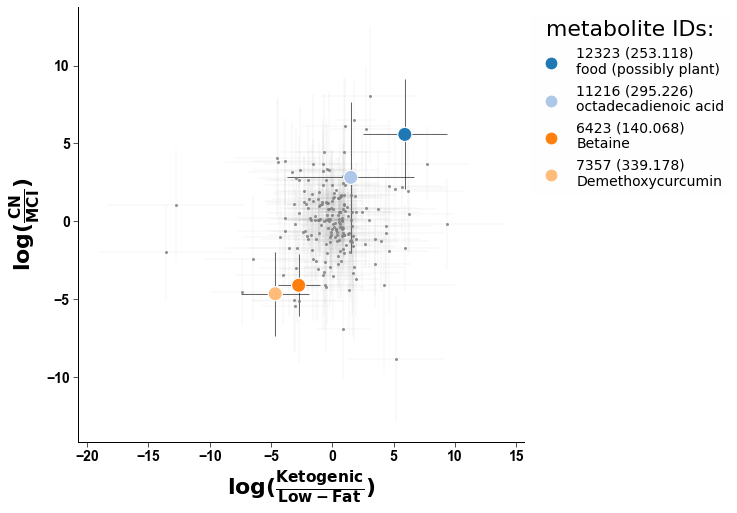

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
#micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]

#micro_comparedf = diffs_metabolomics.loc[mmvec_conditionals_df_subset.index, :].copy().dropna()
micro_comparedf = diffs_metabolomics.loc[df[df.cluster.isin(['g'])].index, :].copy().dropna()

#micro_comparedf = micro_comparedf.drop(['13734 (149.059)'])

micro_comparedf[diff_col] -= micro_comparedf[diff_col].mean()
micro_comparedf['cog[T.NC]_mean'] -= micro_comparedf['cog[T.NC]_mean'].mean()
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]
rho_, p_ = spearmanr(micro_comparedf['cog[T.NC]_mean'].values,
                     micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].values)
stats_txt = "$\\rho$=%.3f\nP=%.3f" % (abs(rho_), p_)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
#ax.text(0.1, 0.85, stats_txt, transform=ax.transAxes, bbox=props, ha='left', fontsize=14)

cut_off_x = 1
cut_off_y = 1
micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -1  * cut_off_x) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1  * cut_off_y) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > cut_off_x)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > cut_off_y)))]
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('ids')

fix_labels = {'11216 (295.226)':'11216 (295.226)\noctadecadienoic acid',
              '12323 (253.118)':'12323 (253.118)\nfood (possibly plant)',
             '6423 (140.068)':'6423 (140.068)\nBetaine',
             '7357 (339.178)':'7357 (339.178)\nDemethoxycurcumin'}
micro_comparedf_subset_color = micro_comparedf_subset_color.loc[fix_labels.keys(), :]

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='ids', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)


handles, labels_scatter = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], [fix_labels[l_] if l_ in fix_labels.keys() else l_
                                for l_ in labels_scatter[:]],
                   loc=2, 
                         bbox_to_anchor=(1, 1),
                         prop={'size':14},
                         title="metabolite IDs:",
                         fancybox=True, framealpha=.01,
                         ncol=1, markerscale=5.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

In [18]:
fecal_metaball_subset = fecal_metaball[fecal_metaball.id_plus.isin(labels_scatter)]
fecal_metaball_subset.index = [f.replace('f','') for f in fecal_metaball_subset.index]
fecal_metaball_subset[['row m/z', 'row retention time']].to_csv('../results/birdman-metab/identified-metabolites.csv')


In [19]:
fecal_metaball[fecal_metaball['row m/z'].round(2) == 104.07]


row m/z  row retention time         id_plus clean_annot  \
row ID                                                               
f1940   104.070683            0.254313  1940 (104.070)         NaN   

       clean_annot_plus  
row ID                   
f1940    1940 (104.070)

### Betaine

In [20]:
##num_ = [labels_scatter[2]]
#num_ = labels_scatter[2:14]
num_ = ['11216 (295.226)','12323 (253.118)']
##den_ = [labels_scatter[-2]]
#den_ = labels_scatter[14:-2]
den_ = ['7357 (339.178)']
den_ = ['6423 (140.068)']

df_all_matabs_table_ps = df_all_matabs_table.copy() + 1

#from skbio.stats.composition import closure, clr
#df_all_matabs_table_ps = pd.DataFrame(clr(df_all_matabs_table.values + 1),df_all_matabs_table.index, df_all_matabs_table.columns)

metadata_lr = metadata.copy().reindex(df_all_matabs_table_ps.columns)
metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[num_, :].sum(0)) - np.log(df_all_matabs_table_ps.loc[den_, :].sum(0))
#metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[num_, :].sum(0))
#metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[den_, :].sum(0))

metadata_lr.head(5)

age anonymized_name bmi_pbl           box_name cog_visit_date  \
13662.5556815  60         1263024      21  31102 Stool Box 1        2/25/16   
13662.5556668  63         1263011   22.26  31102 Stool Box 1        6/11/15   
13662.5556717  66         1263017    27.8  31102 Stool Box 1        3/28/16   
13662.5556776  55         1263021   41.46  31102 Stool Box 1       11/30/15   
13662.5556749  57         1263019   30.26  31102 Stool Box 1        1/12/16   

              collection_timestamp                            description  \
13662.5556815           2016-02-23        fecal sample Post 1 3BCCR001024   
13662.5556668           2015-06-17        fecal sample Post 2 3BSLA000746   
13662.5556717           2016-03-28  fecal sample FU 1 / Pre 2 3TFBO000818   
13662.5556776           2015-12-01        fecal sample Post 2 3CDMA000951   
13662.5556749           2016-01-28          fecal sample FU 2 3LDMO000125   

               elevation           empo_1  empo_2  ...     timepoint  \
13662.5556815      300.0  Host-associated  Animal  ...        Post 1   
13662.5556668      300.0  Host-associated  Animal  ...        Post 2   
13662.5556717      300.0  Host-associated  Animal  ...  FU 1 / Pre 2   
13662.5556776      300.0  Host-associated  Animal  ...        Post 2   
13662.5556749      300.0  Host-associated  Animal  ...          FU 2   

                  title     tube_id uom visit_type  cog  \
13662.5556815  BEAM_U19  0005556815  mg  POSTA-COG   NC   
13662.5556668  BEAM_U19  0005556668  mg  POSTA-COG   NC   
13662.5556717  BEAM_U19  0005556717  mg   PREB-COG   NC   
13662.5556776  BEAM_U19  0005556776  mg  POSTA-COG   NC   
13662.5556749  BEAM_U19  0005556749  mg   POSTB-FU  MCI   

                                diet    diet_nocross timepoint_encoded  \
13662.5556815         Ketogenic Diet  Ketogenic Diet               2.0   
13662.5556668               AHA Diet        AHA Diet               2.0   
13662.5556717  Keto-to-AHA Crossover        AHA Diet               3.0   
13662.5556776               AHA Diet        AHA Diet               2.0   
13662.5556749               AHA Diet        AHA Diet               5.0   

               log_ratio  
13662.5556815  14.289183  
13662.5556668 -12.601056  
13662.5556717 -12.124464  
13662.5556776 -12.528814  
13662.5556749 -12.805548  

[5 rows x 62 columns]

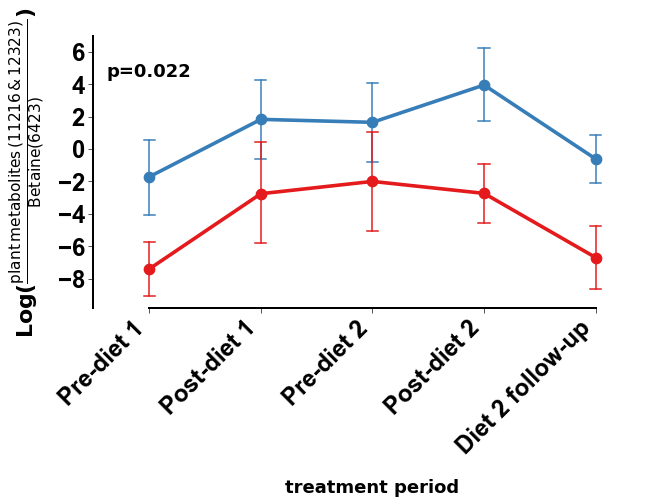

In [21]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, ax = plt.subplots(1,1, figsize=(10, 5), sharex=True)


orddf = metadata_lr.copy()

label_x = 'Log($\\frac{\mathrm{plant\,metabolites\,(11216\,&\,12323)}}{\mathrm{Betaine (6423)}}$)'

#sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
#             data=orddf, color='black', ci=68, ax=ax,
#              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='cog',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(24)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(24)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
#                             orddf['log_ratio'].max().round(1) - 2)
#ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
#             orddf['log_ratio'].max().round(1) - 2)



if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:],
                       [l.replace('NC','CN') for l in labels[:]],
                       loc=2, 
                             bbox_to_anchor=(0.25, 1.3),
                             prop={'size':20},
                             title="Cognition:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)

    #ax.spines['left'].set_bounds(-10, 0)
    #ax.set_ylim(-10, 0)

    orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
    orddf['Sequence'] = orddf['first_diet']
    orddf['Diet'] = orddf['diet_nocross']
    md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                     orddf,
                     groups=orddf["host_subject_id"])
    mdf = md.fit()
    mdf_table = mdf.summary().tables[1]
    p_str = "P=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
    ax.text(-.1, 4, p_str, fontsize=14,
                horizontalalignment='center',
                color='black', weight='semibold')


else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

    orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
    orddf['Sequence'] = orddf['first_diet']
    orddf['Diet'] = orddf['diet_nocross']
    md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                     orddf,
                     groups=orddf["host_subject_id"])
    mdf = md.fit()
    mdf_table = mdf.summary().tables[1]
    p_str = "p=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
    ax.text(0, 4.5, p_str, fontsize=18,
                horizontalalignment='center',
                color='black', weight='semibold')


plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()

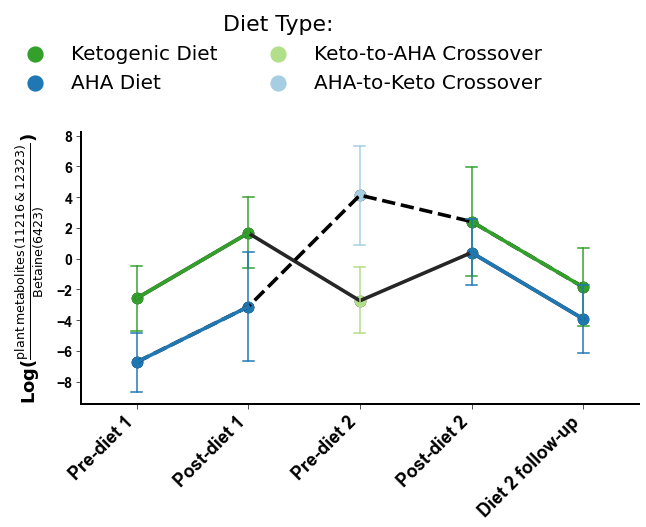

In [22]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)



axn_i = 0

orddf = metadata_lr.copy()

"""denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
num_use_label = [x.replace('[', '').replace(']', '') for x in num_]

label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
"""
label_x = 'Log($\\frac{\mathrm{plant\,metabolites\,(11216\,&\,12323)}}{\mathrm{Betaine (6423)}}$)'

sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 
                 3:'Pre-diet 2', 4:'Post-diet 2', 
                 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=18)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(0, 8)
ax.set_ylim(0, 8)"""

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[2:], labels[2:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                 orddf,
                 groups=orddf["host_subject_id"])
mdf = md.fit()
mdf_table = mdf.summary().tables[1]

"""for x_i, ind in enumerate(['Period[T.Pre-diet 1]', 'Period[T.Post-diet 1]',
                           'Period[T.Pre-diet 2]', 'Period[T.Post-diet 2]']):

    p_str = "P=%s" % (mdf_table.loc[ind, 'P>|z|'])
    ax.text(x_i , 0.5e6,
            p_str,
            horizontalalignment='center',
            size='medium', color='black', weight='semibold')
"""
    
plt.show()

In [23]:
mdf_table

Coef. Std.Err.       z  P>|z|   [0.025 0.975]
Intercept               -5.533    3.729  -1.484  0.138  -12.843  1.776
Diet[T.Ketogenic Diet]   3.812    1.446   2.637  0.008    0.978  6.645
Period[T.Post-diet 1]    1.898    2.274   0.835  0.404   -2.558  6.355
Period[T.Post-diet 2]    3.932    2.242   1.754  0.080   -0.463  8.326
Period[T.Pre-diet 1]    -2.111    2.274  -0.929  0.353   -6.568  2.345
Period[T.Pre-diet 2]     2.882    2.213   1.302  0.193   -1.456  7.221
cog[T.NC]                5.243    2.286   2.294  0.022    0.763  9.724
Sequence                -1.248    2.352  -0.531  0.596   -5.858  3.361
Group Var               15.655    1.509

### Demethoxycurcumin

In [24]:
##num_ = [labels_scatter[2]]
#num_ = labels_scatter[2:14]
num_ = ['11216 (295.226)','12323 (253.118)']
#num_ = ['12323 (253.118)']
##den_ = [labels_scatter[-2]]
#den_ = labels_scatter[14:-2]
den_ = ['7357 (339.178)']

df_all_matabs_table_ps = df_all_matabs_table.copy() + 1

#from skbio.stats.composition import closure, clr
#df_all_matabs_table_ps = pd.DataFrame(clr(df_all_matabs_table.values + 1),df_all_matabs_table.index, df_all_matabs_table.columns)

metadata_lr = metadata.copy().reindex(df_all_matabs_table_ps.columns)
metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[num_, :].sum(0)) - np.log(df_all_matabs_table_ps.loc[den_, :].sum(0))
#metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[num_, :].sum(0))
#metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[den_, :].sum(0))

metadata_lr.head(5)

age anonymized_name bmi_pbl           box_name cog_visit_date  \
13662.5556815  60         1263024      21  31102 Stool Box 1        2/25/16   
13662.5556668  63         1263011   22.26  31102 Stool Box 1        6/11/15   
13662.5556717  66         1263017    27.8  31102 Stool Box 1        3/28/16   
13662.5556776  55         1263021   41.46  31102 Stool Box 1       11/30/15   
13662.5556749  57         1263019   30.26  31102 Stool Box 1        1/12/16   

              collection_timestamp                            description  \
13662.5556815           2016-02-23        fecal sample Post 1 3BCCR001024   
13662.5556668           2015-06-17        fecal sample Post 2 3BSLA000746   
13662.5556717           2016-03-28  fecal sample FU 1 / Pre 2 3TFBO000818   
13662.5556776           2015-12-01        fecal sample Post 2 3CDMA000951   
13662.5556749           2016-01-28          fecal sample FU 2 3LDMO000125   

               elevation           empo_1  empo_2  ...     timepoint  \
13662.5556815      300.0  Host-associated  Animal  ...        Post 1   
13662.5556668      300.0  Host-associated  Animal  ...        Post 2   
13662.5556717      300.0  Host-associated  Animal  ...  FU 1 / Pre 2   
13662.5556776      300.0  Host-associated  Animal  ...        Post 2   
13662.5556749      300.0  Host-associated  Animal  ...          FU 2   

                  title     tube_id uom visit_type  cog  \
13662.5556815  BEAM_U19  0005556815  mg  POSTA-COG   NC   
13662.5556668  BEAM_U19  0005556668  mg  POSTA-COG   NC   
13662.5556717  BEAM_U19  0005556717  mg   PREB-COG   NC   
13662.5556776  BEAM_U19  0005556776  mg  POSTA-COG   NC   
13662.5556749  BEAM_U19  0005556749  mg   POSTB-FU  MCI   

                                diet    diet_nocross timepoint_encoded  \
13662.5556815         Ketogenic Diet  Ketogenic Diet               2.0   
13662.5556668               AHA Diet        AHA Diet               2.0   
13662.5556717  Keto-to-AHA Crossover        AHA Diet               3.0   
13662.5556776               AHA Diet        AHA Diet               2.0   
13662.5556749               AHA Diet        AHA Diet               5.0   

               log_ratio  
13662.5556815  14.289183  
13662.5556668   0.693147  
13662.5556717   0.693147  
13662.5556776 -12.519384  
13662.5556749   0.693147  

[5 rows x 62 columns]

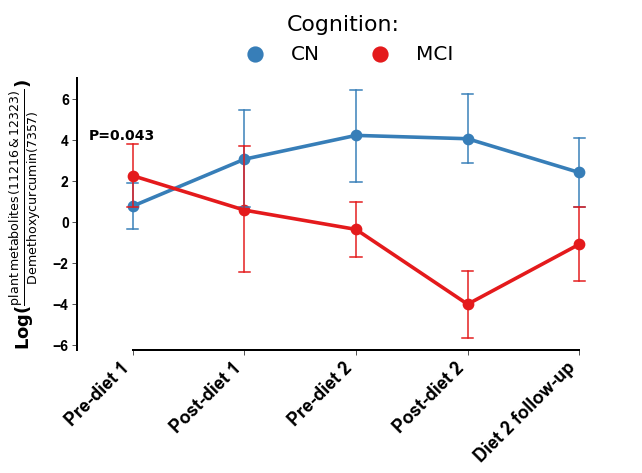

In [25]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, ax = plt.subplots(1,1, figsize=(10, 5), sharex=True)


orddf = metadata_lr.copy()

label_x = 'Log($\\frac{\mathrm{plant\,metabolites\,(11216\,&\,12323)}}{\mathrm{Demethoxycurcumin (7357)}}$)'

#sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
#             data=orddf, color='black', ci=68, ax=ax,
#              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='cog',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=18)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
#                             orddf['log_ratio'].max().round(1) - 2)
#ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
#             orddf['log_ratio'].max().round(1) - 2)



if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:],
                       [l.replace('NC','CN') for l in labels[:]],
                       loc=2, 
                             bbox_to_anchor=(0.25, 1.3),
                             prop={'size':20},
                             title="Cognition:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)

    #ax.spines['left'].set_bounds(-10, 0)
    #ax.set_ylim(-10, 0)

    orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
    orddf['Sequence'] = orddf['first_diet']
    orddf['Diet'] = orddf['diet_nocross']
    md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                     orddf,
                     groups=orddf["host_subject_id"])
    mdf = md.fit()
    mdf_table = mdf.summary().tables[1]
    p_str = "P=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
    ax.text(-.1, 4, p_str, fontsize=14,
                horizontalalignment='center',
                color='black', weight='semibold')


else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

    orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
    orddf['Sequence'] = orddf['first_diet']
    orddf['Diet'] = orddf['diet_nocross']
    md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                     orddf,
                     groups=orddf["host_subject_id"])
    mdf = md.fit()
    mdf_table = mdf.summary().tables[1]
    p_str = "P=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
    ax.text(-.1, 3.5, p_str, fontsize=14,
                horizontalalignment='center',
                color='black', weight='semibold')


plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()

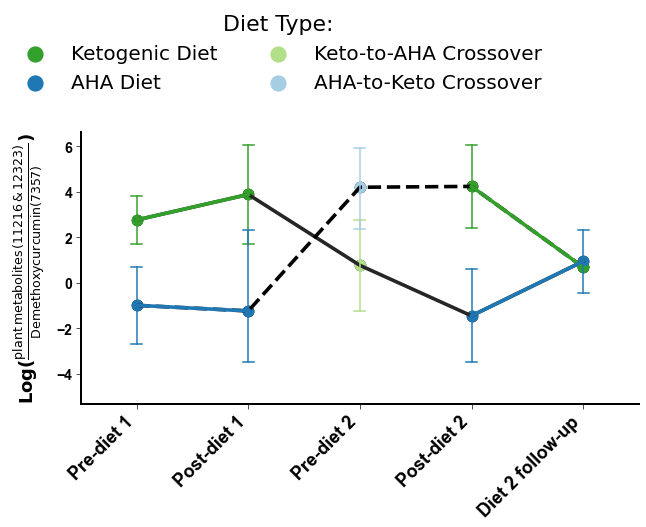

In [26]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)



axn_i = 0

orddf = metadata_lr.copy()

"""denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
num_use_label = [x.replace('[', '').replace(']', '') for x in num_]

label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
"""
label_x = 'Log($\\frac{\mathrm{plant\,metabolites\,(11216\,&\,12323)}}{\mathrm{Demethoxycurcumin (7357)}}$)'

sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 
                 3:'Pre-diet 2', 4:'Post-diet 2', 
                 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=18)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(0, 8)
ax.set_ylim(0, 8)"""

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[2:], labels[2:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                 orddf,
                 groups=orddf["host_subject_id"])
mdf = md.fit()
mdf_table = mdf.summary().tables[1]

"""for x_i, ind in enumerate(['Period[T.Pre-diet 1]', 'Period[T.Post-diet 1]',
                           'Period[T.Pre-diet 2]', 'Period[T.Post-diet 2]']):

    p_str = "P=%s" % (mdf_table.loc[ind, 'P>|z|'])
    ax.text(x_i , 0.5e6,
            p_str,
            horizontalalignment='center',
            size='medium', color='black', weight='semibold')
"""
    
plt.show()

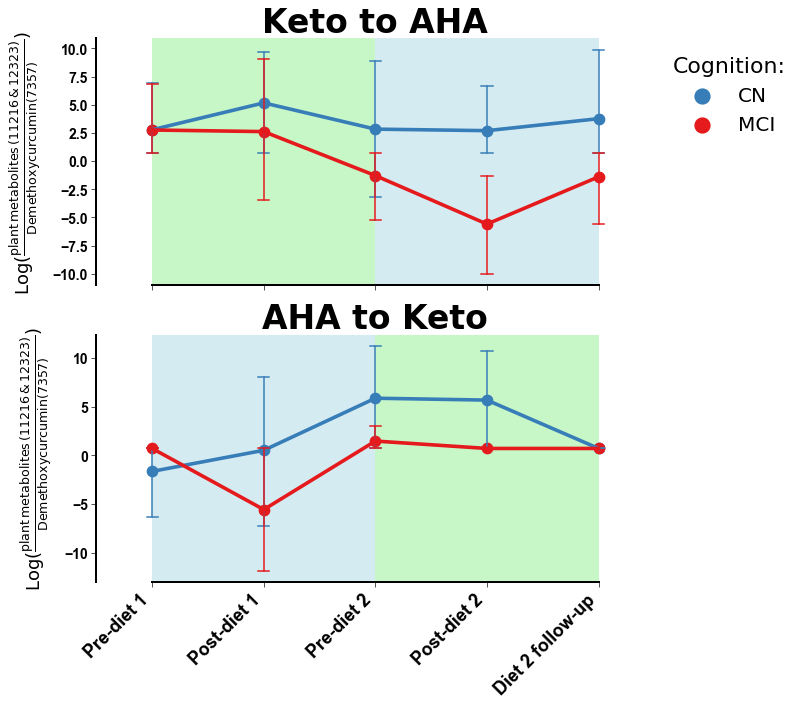

In [27]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,1, figsize=(10,10), sharex=True)

subset_use = [1, 2]
subset_use_label = {1.0:'Keto to AHA', 2.0:'AHA to Keto'}

for (axn_i, ax), fsub in zip(enumerate(axn.flatten()), subset_use):

    orddf = metadata_lr.copy().dropna(subset=['first_diet'])
    orddf = orddf[orddf.first_diet == fsub]

    #if fsub == 2:
    #    orddf = orddf[~((orddf.timepoint_encoded == 5.0) & (orddf.cog == 'MCI'))]
    
    ax.set_title(subset_use_label[fsub],
                  color='black',
                  weight='bold',
                  fontsize=33)
    
    if fsub == 1:
        # keto
        ax.axvspan(0, 2, facecolor='lightgreen', alpha=0.5)
        # low-fat
        ax.axvspan(2, 4, facecolor='lightblue', alpha=0.5)
    else:
        # low-fat
        ax.axvspan(0, 2, facecolor='lightblue', alpha=0.5)
        # keto
        ax.axvspan(2, 4, facecolor='lightgreen', alpha=0.5)

    denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in num_]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    #label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
    #                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
    label_x = 'Log($\\frac{\mathrm{plant\,metabolites\,(11216\,&\,12323)}}{\mathrm{Demethoxycurcumin (7357)}}$)'
    
    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded',
                  hue='cog',
                 data=orddf, palette=cmap_man,
                  ci=95, ax=ax,
                 errwidth=1.5,
                  capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='normal',
                  labelpad=10,
                  fontsize=18)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    """ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
                                 orddf['log_ratio'].max().round(1) - 2)
    ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
                 orddf['log_ratio'].max().round(1) - 2)"""

    if axn_i < 2:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.legend_.remove()
        if axn_i== 0:

            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[:],
                               [l.replace('NC','CN') for l in labels[:]],
                               loc=2, 
                                     bbox_to_anchor=(1, 1.),
                                     prop={'size':20},
                                     title="Cognition:",
                                     fancybox=False, framealpha=.0,
                                     ncol=1, markerscale=1.5)
            legend.get_title().set_fontsize('22')
            # increase the line width in the legend 
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        ax.legend_.remove()
    
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    
    

plt.show()

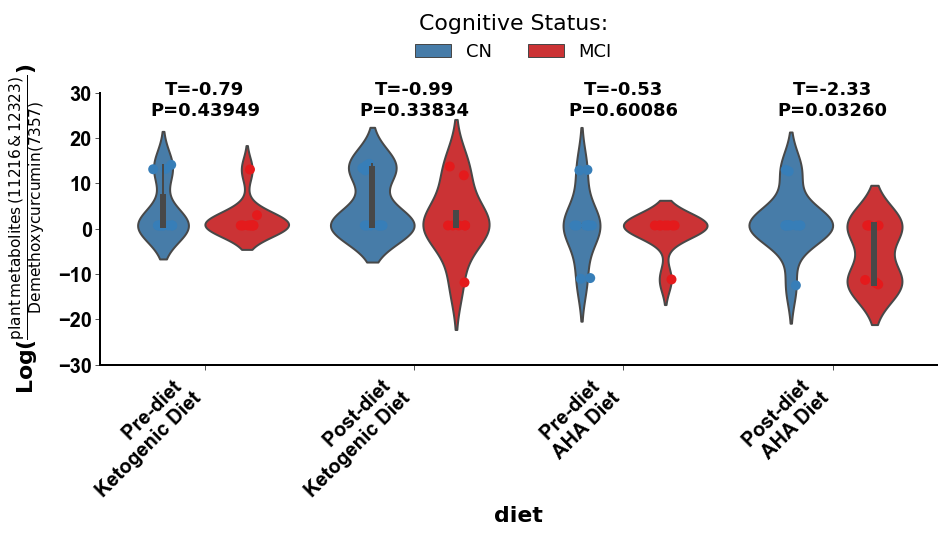

In [28]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'MCI':'#e41a1c', 'NC':'#377eb8'}

order_xaxis = ['Pre-diet \nKetogenic Diet',
                'Post-diet \nKetogenic Diet',
                'Pre-diet \nAHA Diet',
                'Post-diet \nAHA Diet']

fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)


orddf = metadata_lr.copy().dropna(subset=['first_diet'])
#num_use_label = ['Alistipes sp. CAG:514']
#denom_use_label = ['Bifidobacterium adolescentis']
relabel_ticks = {1:'Pre-diet \n', 2:'Post-diet \n', 
                 3:'Pre-diet \n', 4:'Post-diet \n', 
                 5:'Post-dit \n'}

orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
orddf['p_plus_diet'] = orddf.Period + orddf.Diet


#label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
#                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))

label_x = 'Log($\\frac{\mathrm{plant\,metabolites\,(11216\,&\,12323)}}{\mathrm{Demethoxycurcumin (7357)}}$)'
    

"""sns.pointplot(y='log_ratio', x='diet', hue='cog',rder=order_xaxis,
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)"""


sns.violinplot(x='p_plus_diet', y='log_ratio', hue='cog',order=order_xaxis,
             data=orddf, palette=cmap_man, ax=ax)

sns.stripplot(x='p_plus_diet', y='log_ratio', hue='cog',order=order_xaxis,
              data=orddf, palette=cmap_man, ax=ax, dodge=True, s=10)

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(20)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(20)
    tick.set_rotation(45)
    tick.set_ha('right')

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

#ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(0, 8)
#ax.set_ylim(0, 8)

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=22)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[2:], labels[2:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('18')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('diet',
              color='black',
              weight='bold',
              labelpad=5,
              fontsize=22)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


for x_i, ind in enumerate(order_xaxis):
    
    orddf_ = orddf[orddf.p_plus_diet == ind]
    x_ = orddf_[orddf_.cog == 'MCI'].log_ratio.values
    y_ = orddf_[orddf_.cog == 'NC'].log_ratio.values
    t_ = ttest_ind(x_, y_)
    p_str = "T=%.2f\nP=%.5f" % (t_.statistic, t_.pvalue)

    ax.text(x_i , 25,
            p_str,
            horizontalalignment='center',
            fontsize=18, color='black', weight='semibold')
ax.set_ylim(-30, 30)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:],
                   [l.replace('NC','CN') for l in labels[:]],
                   loc=1, 
                         bbox_to_anchor=(.63, 1.35),
                         prop={'size':18},
                         title="Cognitive Status:",
                         fancybox=False, framealpha=.0,
                         ncol=2, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.show()

### Turmeric

In [29]:
mmvec_conditionals_subset.loc[['11216 (295.226)','12323 (253.118)','7357 (339.178)'], :]


Akkermansia muciniphila  Alistipes sp. CAG:514  \
11216 (295.226)                -0.643633               0.554696   
12323 (253.118)                -0.568324               0.227661   
7357 (339.178)                 -0.664373               0.298351   

                 Clostridium sp. CAG:568  Akkermansia muciniphila CAG:154  \
11216 (295.226)                 1.255338                        -0.737341   
12323 (253.118)                 1.247094                        -0.652344   
7357 (339.178)                  1.272049                        -0.761268   

                 Akkermansia muciniphila  Akkermansia sp. UNK.MGS-1  \
11216 (295.226)                -0.729340                  -0.345180   
12323 (253.118)                -0.649103                  -0.366113   
7357 (339.178)                 -0.753581                  -0.407292   

                 Bifidobacterium adolescentis  
11216 (295.226)                     -0.359854  
12323 (253.118)                     -0.300969  
7357 (339.178)                      -0.344625

## Bile acids analysis

In [30]:
metabolomics_ba = pd.read_csv('../data/metabolomics/BEAM_BA.csv').dropna(subset=['Compound_Name'])
print(metabolomics_ba.shape)
metabolomics_ba['Precursor_MZ'] =[x[:7] for x in  metabolomics_ba['Precursor_MZ'].astype(str)]
metabolomics_ba['#Scan#'] = metabolomics_ba['#Scan#'].astype(str)
name_map = {x:y for x in metabolomics_ba['#Scan#'] for y in df_all_matabs_table.index if int(x) == int(y.split(' (')[0])}
metabolomics_ba.index = [name_map[x] for x in metabolomics_ba['#Scan#']]
#other_ba = list(set(df_all_matabs_table.index) & set(metabolomics_ba.index))
metabolomics_ba['name_new'] = [x.lower().replace('"','') for x in metabolomics_ba.Compound_Name]
metabolomics_ba['name_new'] = [x.split('suspect related to ')[1].split(' (')[0].replace('spectral match to ', '').replace(' from nist14','').replace(' sulfate' ,'').replace(' putative','') if 'suspect related to' in x else x.replace('spectral match to ', '').replace(' from nist14','') for x in metabolomics_ba['name_new']]
                
names_ba = pd.read_csv('../data/metabolomics/ba-map.csv', index_col=0)
names_ba.index = [x.lower() for x in names_ba.index]
names_ba = names_ba[~names_ba.index.duplicated(keep='first')]
metabolomics_ba['name_new'] = [names_ba.loc[x, 'common_name '] if x in names_ba.index else 'unknown bile acid' for x in metabolomics_ba['name_new']]
names_ba_cn = names_ba.set_index('common_name ')
names_ba_cn = names_ba_cn[~names_ba_cn.index.duplicated(keep='first')]
metabolomics_ba['status'] = [names_ba_cn.loc[x.replace(' putative','').replace(' methyl ester',''), 'status'] for x in metabolomics_ba['name_new']]
metabolomics_ba['kind'] = [names_ba_cn.loc[x.replace(' putative','').replace(' methyl ester',''), 'kind'] for x in metabolomics_ba['name_new']]
other_ba = list(metabolomics_ba.loc[metabolomics_ba.name_new != 'unknown bile acid'].index)
print(metabolomics_ba.shape)
metabolomics_ba.head(5)

(56, 47)
(56, 50)


Library                                      Compound_Name  \
5942 (407.279)  BILELIB19  "(R)-4-((3S,5S,7R,8R,9S,10S,13R,14S,17R)-3,7-d...   
7515 (391.284)  BILELIB19  "(R)-4-((3S,5S,7S,8R,9S,10S,12S,13R,14S,17R)-3...   
5403 (375.289)  BILELIB19  "(R)-4-((5R,8R,9S,10S,13R,14S,17R)-10,13-dimet...   
430 (158.154)   BILELIB19                                     hyocholic acid   
6128 (415.281)  BILELIB19  "(4R)-4-((3R,5R,7R,9S,10S,13R,14S,17R)-3,7-dih...   

               Ion_Source Instrument Compound_Source          PI  \
5942 (407.279)        ESI       qTof           crude  Dorrestein   
7515 (391.284)        ESI       qTof           crude  Dorrestein   
5403 (375.289)        ESI       qTof           crude  Dorrestein   
430 (158.154)         ESI   Orbitrap      commercial  Dorrestein   
6128 (415.281)        ESI       qTof           crude  Dorrestein   

               Data_Collector   Adduct Precursor_MZ  ExactMass  ...  \
5942 (407.279)   Emily Gentry      M+H      407.279    406.272  ...   
7515 (391.284)   Emily Gentry  M-H2O+H      391.284    408.288  ...   
5403 (375.289)   Emily Gentry      M+H      375.289    374.282  ...   
430 (158.154)     A. Jarmusch      M+H      158.154    408.288  ...   
6128 (415.281)   Emily Gentry     M+Na      415.282    392.293  ...   

                                     superclass  \
5942 (407.279)  Lipids and lipid-like molecules   
7515 (391.284)  Lipids and lipid-like molecules   
5403 (375.289)  Lipids and lipid-like molecules   
430 (158.154)   Lipids and lipid-like molecules   
6128 (415.281)  Lipids and lipid-like molecules   

                                           class  \
5942 (407.279)  Steroids and steroid derivatives   
7515 (391.284)  Steroids and steroid derivatives   
5403 (375.289)  Steroids and steroid derivatives   
430 (158.154)   Steroids and steroid derivatives   
6128 (415.281)  Steroids and steroid derivatives   

                                            subclass npclassifier_superclass  \
5942 (407.279)  Bile acids, alcohols and derivatives                Steroids   
7515 (391.284)  Bile acids, alcohols and derivatives                Steroids   
5403 (375.289)  Bile acids, alcohols and derivatives                Steroids   
430 (158.154)   Bile acids, alcohols and derivatives                Steroids   
6128 (415.281)  Bile acids, alcohols and derivatives                Steroids   

               npclassifier_class  npclassifier_pathway  internalFilename  \
5942 (407.279)   Cholane steroids            Terpenoids      specs_ms.mgf   
7515 (391.284)   Cholane steroids            Terpenoids      specs_ms.mgf   
5403 (375.289)   Cholane steroids            Terpenoids      specs_ms.mgf   
430 (158.154)    Cholane steroids            Terpenoids      specs_ms.mgf   
6128 (415.281)   Cholane steroids            Terpenoids      specs_ms.mgf   

                                 name_new        status     kind  
5942 (407.279)          unknown bile acid       unknown  unknown  
7515 (391.284)          unknown bile acid       unknown  unknown  
5403 (375.289)          unknown bile acid       unknown  unknown  
430 (158.154)              hyocholic acid  unconjugated  primary  
6128 (415.281)  allochenodeoxycholic acid  unconjugated  primary  

[5 rows x 50 columns]

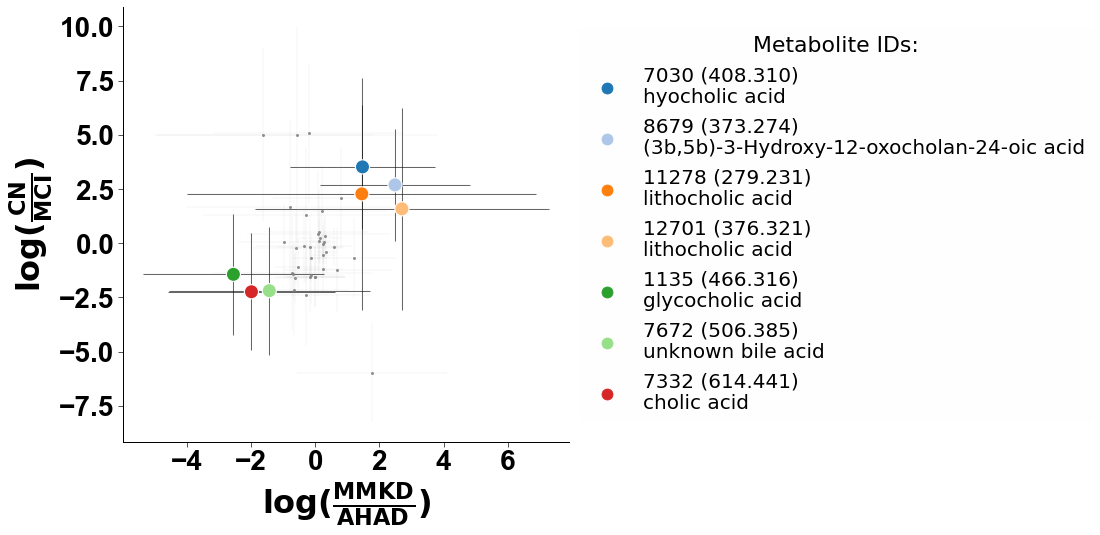

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "MMKD:AHAD"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
#micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]

#micro_comparedf = diffs_metabolomics.loc[mmvec_conditionals_df_subset.index, :].copy().dropna()
micro_comparedf = diffs_metabolomics.loc[list(df[df.cluster.isin(['C1'])].index) + list(metabolomics_ba.index), :].copy().dropna()

#micro_comparedf = micro_comparedf.drop(['13734 (149.059)'])

micro_comparedf[diff_col] -= micro_comparedf[diff_col].mean()
micro_comparedf['cog[T.NC]_mean'] -= micro_comparedf['cog[T.NC]_mean'].mean()
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]
rho_, p_ = spearmanr(micro_comparedf['cog[T.NC]_mean'].values,
                     micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].values)
stats_txt = "$\\rho$=%.3f\nP=%.3f" % (abs(rho_), p_)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
#ax.text(0.1, 0.85, stats_txt, transform=ax.transAxes, bbox=props, ha='left', fontsize=14)

cut_off_x = 1
cut_off_y = 1
micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -1  * cut_off_x) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1  * cut_off_y) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > cut_off_x)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > cut_off_y)))]
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('ids')

fix_labels = {'11216 (295.226)':'11216 (295.226)\noctadecadienoic acid',
              '12323 (253.118)':'12323 (253.118)\nfood (possibly plant)',
             '6423 (140.068)':'6423 (140.068)\nBetaine',
             '7357 (339.178)':'7357 (339.178)\nDemethoxycurcumin'}
order_rows = metabolomics_ba.index
metabolomics_ba_fix_add = metabolomics_ba.loc[order_rows, 'name_new'].dropna()
metabolomics_ba_fix_add = metabolomics_ba_fix_add[~metabolomics_ba_fix_add.index.duplicated(keep='first')]
metabolomics_ba_fix_add = dict(metabolomics_ba_fix_add)
metabolomics_ba_fix_add = {k:k+'\n'+v.replace(' putative','') for k, v in metabolomics_ba_fix_add.items()}
fix_labels = {**fix_labels, **metabolomics_ba_fix_add}

micro_comparedf_subset_color = micro_comparedf_subset_color.loc[fix_labels.keys(), :]

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='ids', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)


handles, labels_scatter = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], [fix_labels[l_] if l_ in fix_labels.keys() else l_
                                for l_ in labels_scatter[:]],
                   loc='center left', 
                         bbox_to_anchor=(1, 0.5),
                         prop={'size':20},
                         title="Metabolite IDs:",
                         fancybox=True, framealpha=.01,
                         ncol=1, markerscale=5.5)

legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=32)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=32)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(28)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(28)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

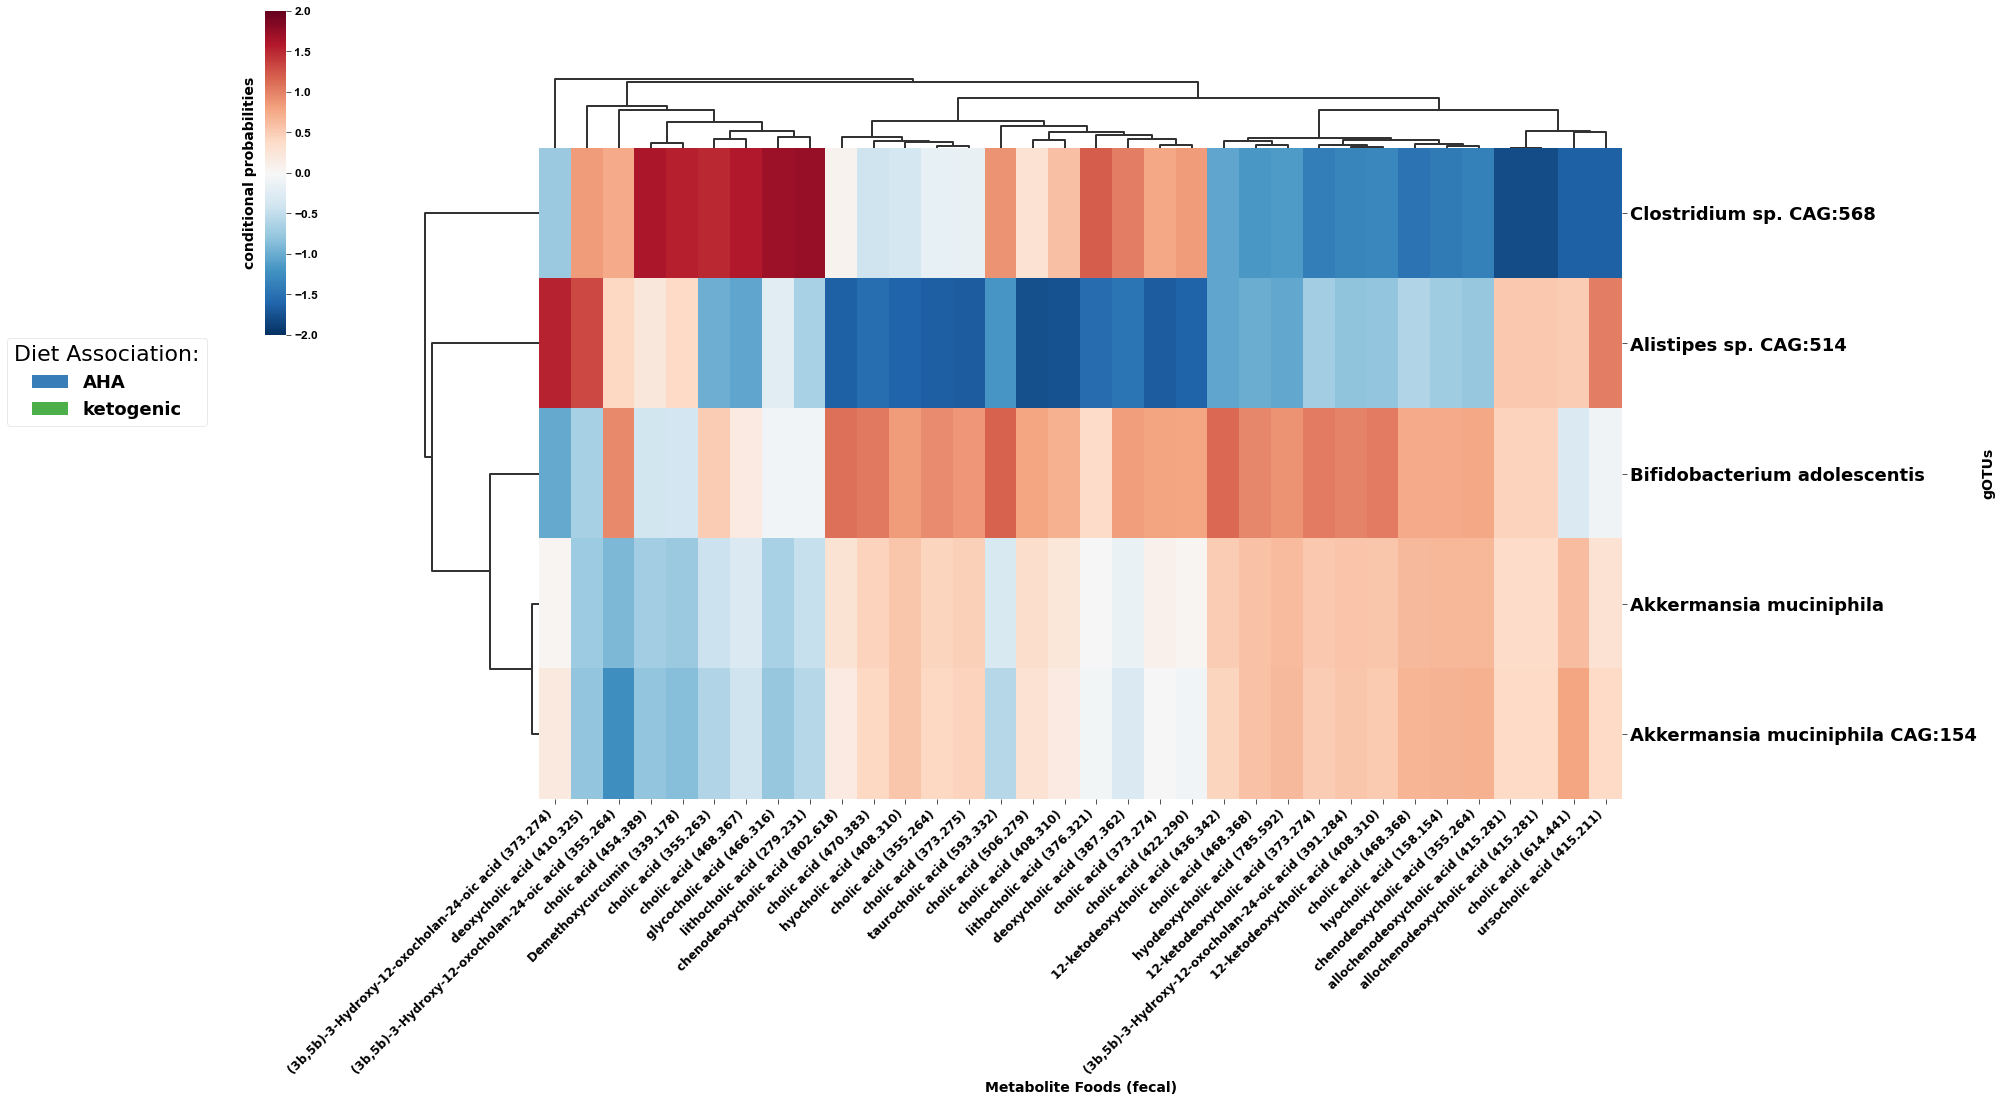

In [32]:
from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)

diff_microbes_ba = ['G000020225', 'G000431015', 'G000434395', 'G000436395', 'G000010425']
mmvec_conditionals_ba_subset = mmvec_conditionals_df.loc[other_ba + ['7357 (339.178)'], diff_microbes_ba].dropna()
mmvec_conditionals_ba_subset.columns = taxonomy.loc[diff_microbes_ba, 'species'].values

order_rows = other_ba
metabolomics_ba_fix_add = metabolomics_ba.loc[order_rows, 'name_new'].dropna()
metabolomics_ba_fix_add = metabolomics_ba_fix_add[~metabolomics_ba_fix_add.index.duplicated(keep='first')]
metabolomics_ba_fix_add = dict(metabolomics_ba_fix_add)
metabolomics_ba_fix_add = {k:v + ' '+ k.split(' ')[1] for k, v in metabolomics_ba_fix_add.items()}
metabolomics_ba_fix_add['7357 (339.178)'] = 'Demethoxycurcumin (339.178)'
#metabolomics_ba_fix_add['11216 (295.226)'] = '11216 (295.226): octadecadienoic acid'
#metabolomics_ba_fix_add['12323 (253.118)'] = '12323 (253.118): food (possibly plant)'

mmvec_conditionals_ba_subset_plot = mmvec_conditionals_ba_subset.copy()
mmvec_conditionals_ba_subset_plot.index = [metabolomics_ba_fix_add[x] for x in mmvec_conditionals_ba_subset.index]

g = sns.clustermap(mmvec_conditionals_ba_subset_plot.T,
                   vmax=2.0,
                   vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   #col_colors=col_colors[1:],
                   #row_colors=col_colors[:-1],
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(20, 15),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=1)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','ketogenic').replace('no','AHA') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('conditional probabilities', rotation=90, 
                 labelpad=-75,
                 fontsize=14, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=18, weight='bold',)

g.ax_heatmap.set_ylabel('gOTUs' ,color='black',weight='bold',fontsize=14)
g.ax_heatmap.set_xlabel('Metabolite Foods (fecal)' ,color='black',weight='bold',fontsize=14)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
"""

plt.show()

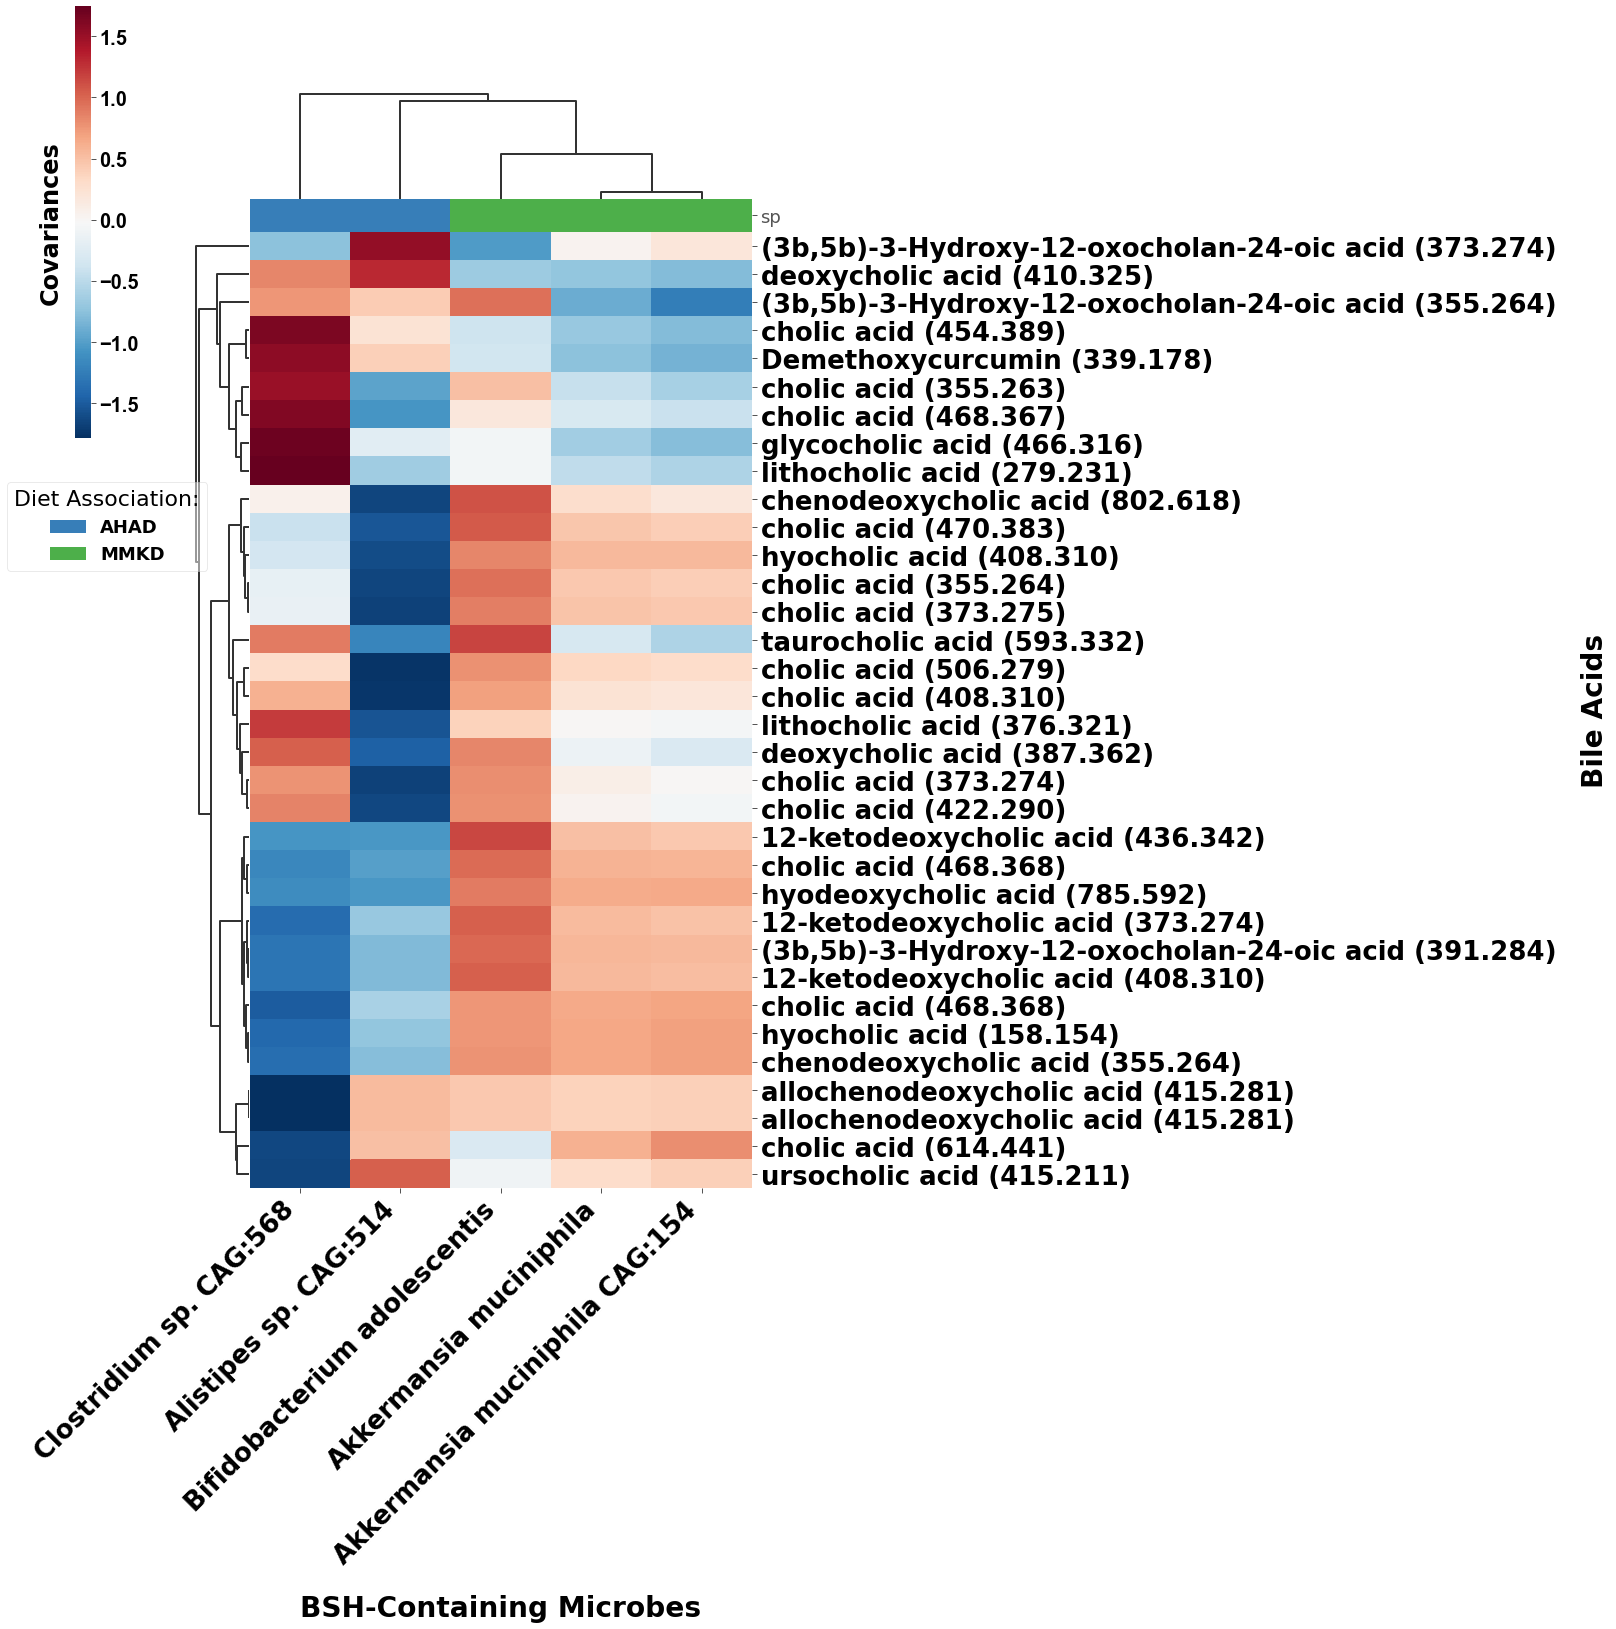

In [33]:
from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)

diff_microbes_ba = ['G000020225', 'G000431015', 'G000434395', 'G000436395', 'G000010425']
mmvec_conditionals_ba_subset = mmvec_conditionals_df.loc[other_ba + ['7357 (339.178)'], diff_microbes_ba].dropna()
mmvec_conditionals_ba_subset.columns = taxonomy.loc[diff_microbes_ba, 'species'].values


order_rows = other_ba
metabolomics_ba_fix_add = metabolomics_ba.loc[order_rows, 'name_new'].dropna()
metabolomics_ba_fix_add = metabolomics_ba_fix_add[~metabolomics_ba_fix_add.index.duplicated(keep='first')]
metabolomics_ba_fix_add = dict(metabolomics_ba_fix_add)
metabolomics_ba_fix_add = {k:v + ' '+ k.split(' ')[1] for k, v in metabolomics_ba_fix_add.items()}
metabolomics_ba_fix_add['7357 (339.178)'] = 'Demethoxycurcumin (339.178)'
#metabolomics_ba_fix_add['11216 (295.226)'] = '11216 (295.226): octadecadienoic acid'
#metabolomics_ba_fix_add['12323 (253.118)'] = '12323 (253.118): food (possibly plant)'

mmvec_conditionals_ba_subset_plot = mmvec_conditionals_ba_subset.copy()
mmvec_conditionals_ba_subset_plot.index = [metabolomics_ba_fix_add[x] for x in mmvec_conditionals_ba_subset.index]

g = sns.clustermap(mmvec_conditionals_ba_subset_plot,
                   #vmax=2.0,
                   #vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=col_colors[1:],
                   #row_colors=col_colors[:-1],
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(15, 20),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=0)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','MMKD').replace('no','AHAD') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('Covariances', rotation=90, 
                 labelpad=-100,
                 fontsize=24, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(20)


    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', fontsize=26, weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=26, weight='bold',)

    
g.ax_heatmap.set_ylabel('Bile Acids' ,color='black',weight='bold',fontsize=28, labelpad=25)
g.ax_heatmap.set_xlabel('BSH-Containing Microbes' ,color='black',weight='bold',fontsize=28, labelpad=25)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
"""

plt.show()


In [34]:
# taxonomy_map
taxonomy_map = pd.read_csv('../data/wol/wol-organism-tax.tsv', sep='\t', index_col=0, header=None)
taxonomy_map.columns = ['strain']
taxonomy_map['genus'] = [x.split(' ')[0] for x in taxonomy_map['strain']]
taxonomy_map['species'] = [' '.join(x.split(' ')[:2]) for x in taxonomy_map['strain']]


# each genome prot
genome_to_prot = pd.read_csv('../data/wol/metacyc/protein.map.xz', sep='\t', header=None)

# prot to enzrxn
prot_to_enzrxn_file = open('../data/wol/metacyc/protein-to-gene.txt', 'r')
prot_to_enzrxn = [[l.lstrip().rstrip().replace('\n', '') for l in line.split('\t')] 
                  for line in prot_to_enzrxn_file]
prot_to_enzrxn_file.close()
prot_to_enzrxn_map = {names_tmp[0]:names_tmp[1:] for names_tmp in prot_to_enzrxn}
genome_to_prot[2] = [prot_to_enzrxn_map[v] if v in prot_to_enzrxn_map.keys() else np.nan for v in genome_to_prot[1]]
genome_to_prot = genome_to_prot.dropna(subset=[2])


In [35]:
gene_names = pd.read_csv('../data/wol/metacyc/gene_name.txt', sep='\t', header=None)
gaba_genes = list(gene_names[gene_names[1].isin(['gadA','gadB','gadC'])][0])
gaba_genes_genomes = genome_to_prot.loc[[any(y in x for y in gaba_genes) for x in genome_to_prot[2]], :]

bsh_sp = set(taxonomy_map.loc[[x.split('_')[0] for x in genome_to_prot[genome_to_prot[1] == 'MONOMER-15684'][0]], :].species)
other_genomes = set(taxonomy.species) - bsh_sp

bacteroides_genomes = list(taxonomy_map[taxonomy_map.genus.isin(['Bacteroides'])].species)
#gaba_genomes = set(list(taxonomy_map.loc[set([x.split('_')[0] for x in gaba_genes_genomes[0]]), :].species) + bacteroides_genomes)
gaba_genomes = set(bacteroides_genomes)
other_genomes_gaba = set(list(taxonomy_map[taxonomy_map.genus.isin(['Acinetobacter',
                                                                    'Brevibacterium',
                                                                    'Pseudomonas',
                                                                    'Staphylococcus'])].species))
other_genomes_gaba = set(taxonomy.species) - gaba_genomes



In [36]:

#num_ = metabolomics_ba[(metabolomics_ba.status.isin(['unconjugated']))].index
num_ = metabolomics_ba[metabolomics_ba.name_new.isin(['cholic acid',
                                                      'ursocholic acid',
                                                      'cholic acid methyl ester',
                                                      'deoxycholic acid'])].index
#den_ = metabolomics_ba[(metabolomics_ba.status.isin(['conjugated']))].index
den_ = metabolomics_ba[(metabolomics_ba.name_new.isin(['taurocholic acid','glycocholic acid']))].index


df_all_matabs_table_ps = df_all_matabs_table.copy() + df_all_matabs_table.mean().mean()
metadata_lr = metadata.copy().reindex(df_all_matabs_table_ps.columns)
metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[num_, :].sum(0)) - np.log(df_all_matabs_table_ps.loc[den_, :].sum(0))

num_ = ['11216 (295.226)','12323 (253.118)']
den_ = ['7357 (339.178)']
metadata_lr['tumeric_log_ratio'] = df_all_matabs_table.loc[den_, :].sum(0)
metadata_lr['plant_log_ratio'] = df_all_matabs_table.loc[num_, :].sum(0)
metadata_lr.loc[['13662.5556748', '13662.5556882'], 'tumeric_log_ratio'] = 0

btlr_metag = table_metag.view(Table).to_dataframe() + 1
mflr_metag = metadata_metag.copy().reindex(btlr_metag.columns).dropna(subset=['timepoint_encoded'])

num_use = bsh_sp
denom_use = other_genomes
num = taxonomy[taxonomy.species.isin(num_use)].index
den = taxonomy[taxonomy.species.isin(denom_use)].index
lr = np.log(btlr_metag.loc[num, :].sum(0)) - np.log(btlr_metag.loc[den, :].sum(0))
lr[~np.isfinite(lr)] = np.nan
mflr_metag['log_ratio_microbe'] = lr

num_use = gaba_genomes 
denom_use = other_genomes_gaba
num = taxonomy[taxonomy.species.isin(num_use)].index
den = taxonomy[taxonomy.species.isin(denom_use)].index
lr = np.log(btlr_metag.loc[num, :].sum(0)) - np.log(btlr_metag.loc[den, :].sum(0))
lr[~np.isfinite(lr)] = np.nan
mflr_metag['log_ratio_microbe_gaba'] = lr

mflr_metag['log_ratio_metab'] = metadata_lr.loc[mflr_metag.index, 'log_ratio']
mflr_metag['tumeric_log_ratio'] = metadata_lr.loc[mflr_metag.index, 'tumeric_log_ratio']
mflr_metag['plant_log_ratio'] = metadata_lr.loc[mflr_metag.index, 'plant_log_ratio']

mflr_metag['log_ratio'] = mflr_metag['log_ratio_metab']
mflr_metag = mflr_metag.dropna(subset=['log_ratio_microbe','log_ratio_metab', 'tumeric_log_ratio'])

food_counts = q2.Artifact.load('../data/metabolomics/matched-table-L5-metaG.qza').view(Table).to_dataframe()
mflr_metag['spice_count'] =  mflr_metag['tumeric_log_ratio']


plants_ = ['artichoke',
         'arugula',
         'beet',
         'broccoli',
         'carrot',
         'cauliflower',
         'celery',
         'chard',
         'cucumber',
         'eggplant',
         'kale',
         'lettuce',
         'seaweed',
         'tomato']

"""plants_ = [
         'arugula',
         'kale',
         'lettuce',]"""

mflr_metag['plants_count'] = food_counts.loc[plants_, mflr_metag.index].sum(0) 
#+ mflr_metag['plant_log_ratio']



meat_feats = ['beef',
 'chicken',
 'duck',
 'fig',
 'fish_undetermined',
 'herring',
 'lamb',
 'mackerel',
 'meat_undetermined',
 'pig',
 'shrimp',
 'silversides',
 'smelt',
 'trout',
 'turkey',
 'veal']

meat_feats = ['beef']

mflr_metag['meat_count'] = food_counts.loc[meat_feats, mflr_metag.index].sum(0)
mflr_metag['plant_meat_ratio'] = np.log(mflr_metag['meat_count']) - np.log(mflr_metag['plants_count'])

mflr_metag['plant_meat_bool'] = 'low plant / high animal'
mflr_metag.loc[mflr_metag['plant_meat_ratio'] <= mflr_metag['plant_meat_ratio'].median() , ['plant_meat_bool']] = 'high plant / low animal'


mflr_metag['plant_bool'] = 'low dietary plant'
mflr_metag.loc[mflr_metag['plants_count'] > mflr_metag['plants_count'].median() , ['plant_bool']] = 'high dietary plant'

mflr_metag['tumeric_bool'] = 'no turmeric'
mflr_metag.loc[mflr_metag['spice_count'] > 0 , ['tumeric_bool']] = 'turmeric'
mflr_metag['diet_nocross_turmeric'] = mflr_metag['tumeric_bool'] + ' - ' + mflr_metag.diet_nocross

mflr_metag['bhi_hi'] = mflr_metag['log_ratio_microbe'] > mflr_metag['log_ratio_microbe'].median()

from skbio.stats.composition import closure
mflr_metag['GABA'] = df_all_matabs_table.apply(closure).loc['1940 (104.070)', mflr_metag.index].values




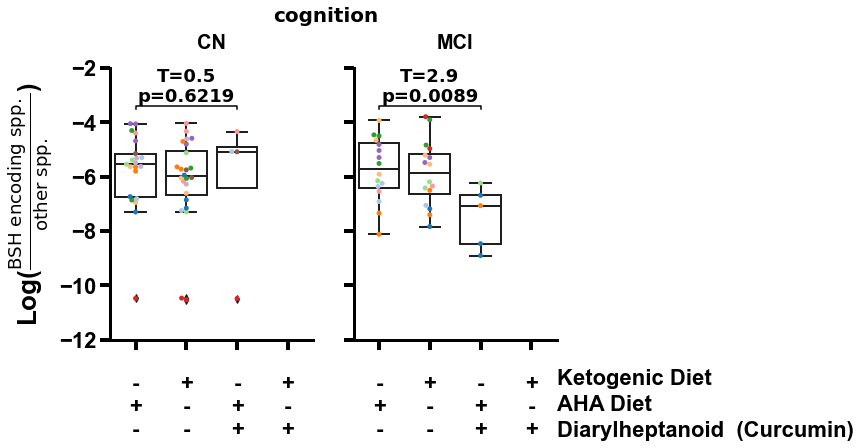

In [37]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'


label_ = 'Log($\\frac{\mathrm{BSH\,\,encoding\,\,spp.}}{\mathrm{other\,\,spp.}}$)'

fig, axn = plt.subplots(1, 2, figsize=(8,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mflr_metag.copy()
mf_lr_df_subset = mf_lr_df_subset[mf_lr_df_subset.diet_nocross_turmeric.isin([k for k, v in mf_lr_df_subset['diet_nocross_turmeric'].value_counts().items() if v > 1])]

for title_, ax in zip(['NC', 'MCI'], axn):

    y_ = 'log_ratio_microbe'
    
    map_pls_minus = {'no turmeric - AHA Diet':'\n-\n+\n-',
                     'no turmeric - Ketogenic Diet':'\n+\n-\n-',
                     'turmeric - AHA Diet':'\n-\n+\n+',
                     'turmeric - Ketogenic Diet':'\n+\n-\n+'}
    mf_lr_df_subset['diet_nocross_turmeric_code'] = [map_pls_minus[x] 
                                                     for x in mf_lr_df_subset.diet_nocross_turmeric]
    
    order_map = {'\n-\n+\n-':0,
                 '\n+\n-\n-':1,
                 '\n-\n+\n+':2,
                 '\n+\n-\n+':3}
    order_ = ['\n-\n+\n-', '\n+\n-\n-', '\n-\n+\n+', '\n+\n-\n+']
    
    
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.cog == title_].dropna(subset=[y_, 'diet_nocross_turmeric_code'])
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diet_nocross_turmeric_code')}
    comobos = [('\n-\n+\n-', '\n-\n+\n+')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot, 
                  palette='tab20',
                  hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.legend_.remove()
    ax.set_ylim(-12, -2)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1) - 3.5, 0.1, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\np=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\np=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=18,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)

val_ = 0.0
for yv_ in ['Ketogenic Diet', 'AHA Diet', 'Diarylheptanoid  (Curcumin)']:
    plt.figtext(0.9, val_, yv_, fontproperties='arial',
                weight='extra bold', fontsize=22,
                horizontalalignment='left')
    val_ -= 0.0725
    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()


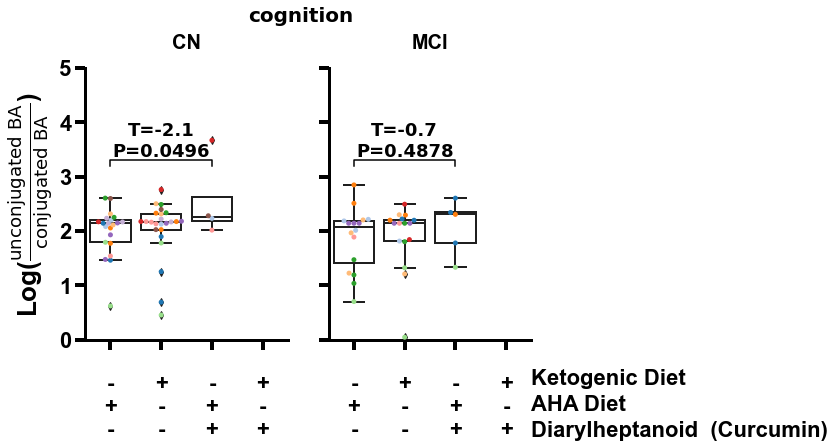

In [38]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

label_ = 'Log($\\frac{\mathrm{unconjugated\,\,BA}}{\mathrm{conjugated\,\,BA}}$)'

fig, axn = plt.subplots(1, 2, figsize=(8,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mflr_metag.copy()
mf_lr_df_subset = mf_lr_df_subset[mf_lr_df_subset.diet_nocross_turmeric.isin([k for k, v in mf_lr_df_subset['diet_nocross_turmeric'].value_counts().items() if v > 1])]

for title_, ax in zip(['NC', 'MCI'], axn):

    y_ = 'log_ratio_metab'
    
    map_pls_minus = {'no turmeric - AHA Diet':'\n-\n+\n-',
                     'no turmeric - Ketogenic Diet':'\n+\n-\n-',
                     'turmeric - AHA Diet':'\n-\n+\n+',
                     'turmeric - Ketogenic Diet':'\n+\n-\n+'}
    mf_lr_df_subset['diet_nocross_turmeric_code'] = [map_pls_minus[x] 
                                                     for x in mf_lr_df_subset.diet_nocross_turmeric]
    
    order_map = {'\n-\n+\n-':0,
                 '\n+\n-\n-':1,
                 '\n-\n+\n+':2,
                 '\n+\n-\n+':3}
    order_ = ['\n-\n+\n-', '\n+\n-\n-', '\n-\n+\n+', '\n+\n-\n+']
    
    
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.cog == title_].dropna(subset=[y_, 'diet_nocross_turmeric_code'])
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diet_nocross_turmeric_code')}
    comobos = [('\n-\n+\n-', '\n-\n+\n+')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot, 
                  palette='tab20',
                  hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.legend_.remove()
    ax.set_ylim(0, 5)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1) + 3.2, 0.1, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=18,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)

val_ = 0.0
for yv_ in ['Ketogenic Diet', 'AHA Diet', 'Diarylheptanoid  (Curcumin)']:
    plt.figtext(0.9, val_, yv_, fontproperties='arial',
                weight='extra bold', fontsize=22,
                horizontalalignment='left')
    val_ -= 0.0725
    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()



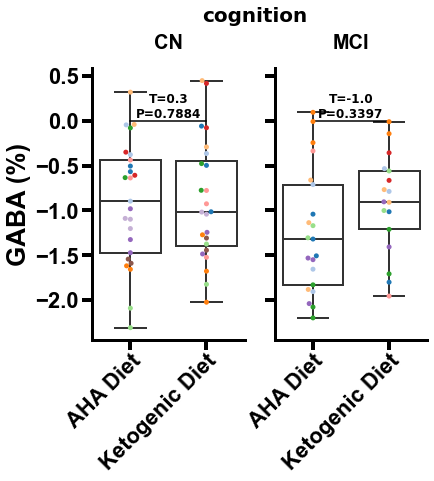

In [39]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

from scipy.stats import ttest_rel

label_ = 'GABA (%)'

fig, axn = plt.subplots(1, 2, figsize=(6,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mflr_metag.copy()

for title_, ax in zip(['NC', 'MCI'], axn):

    y_ = 'log_ratio_microbe_gaba'
    order_map = {'AHA Diet':0,
                 'Ketogenic Diet':1}
    order_ = ['AHA Diet', 'Ketogenic Diet']
    
    #lrdf_plot[lrdf_plot == 0.0]  = np.nan
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.cog == title_].dropna(subset=[y_, 'diet_nocross'])
    
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diet')}

    comobos = [('AHA Diet', 'Ketogenic Diet')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='diet_nocross', 
                  data=lrdf_plot, 
                  palette='tab20',
                  hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='diet_nocross', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.legend_.remove()
    #ax.set_ylim(0, 5)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1) + 0.0001, 0.00001, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=12,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)


    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

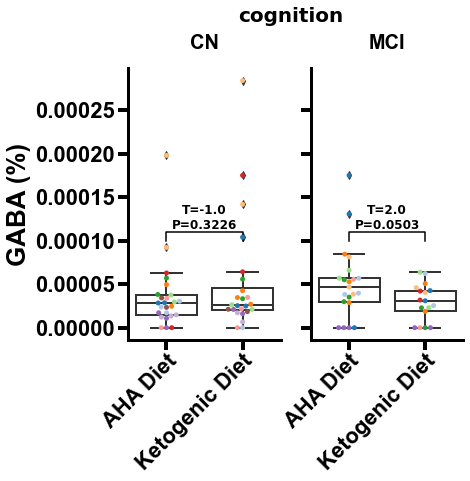

In [40]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'


label_ = 'GABA (%)'

fig, axn = plt.subplots(1, 2, figsize=(6,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mflr_metag.copy()

for title_, ax in zip(['NC', 'MCI'], axn):

    y_ = 'GABA'
    order_map = {'AHA Diet':0,
                 'Ketogenic Diet':1}
    order_ = ['AHA Diet', 'Ketogenic Diet']
    
    #lrdf_plot[lrdf_plot == 0.0]  = np.nan
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.cog == title_].dropna(subset=[y_, 'diet_nocross'])
    
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diet_nocross')}
    comobos = [('AHA Diet', 'Ketogenic Diet')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='diet_nocross', 
                  data=lrdf_plot, 
                  palette='tab20',
                  hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='diet_nocross', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.legend_.remove()
    #ax.set_ylim(0, 5)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1) + 0.0001, 0.00001, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=12,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)


    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

## Updated Annotations

In [41]:
metab_df = all_matabs_table.view(pd.DataFrame).T

In [42]:
metabolomics_ba = pd.read_csv('../data/metabolomics/BEAM_BA_new.csv').dropna(subset=['Compound_Name'])
print(metabolomics_ba.shape)
metabolomics_ba['Precursor_MZ'] =[x[:7] for x in  metabolomics_ba['Precursor_MZ'].astype(str)]
metabolomics_ba['#Scan#'] = metabolomics_ba['#Scan#'].astype(str)
name_map = {x:y for x in metabolomics_ba['#Scan#'] for y in df_all_matabs_table.index if int(x) == int(y.split(' (')[0])}
metabolomics_ba.index = [name_map[x] for x in metabolomics_ba['#Scan#']]
#other_ba = list(set(df_all_matabs_table.index) & set(metabolomics_ba.index))
#metabolomics_ba = metabolomics_ba.loc[other_ba, :]
metabolomics_ba['name_new'] = [x.lower().replace('"','') for x in metabolomics_ba.clean_annot]
#metabolomics_ba['name_new'] = [x.split('suspect related to ')[1].split(' (')[0].replace('spectral match to ', '').replace(' from nist14','').replace(' sulfate' ,'').replace(' putative','') if 'suspect related to' in x else x.replace('spectral match to ', '').replace(' from nist14','') for x in metabolomics_ba['name_new']]

names_ba = pd.read_csv('../data/metabolomics/ba-map.csv', index_col=0)
names_ba.index = [x.lower() for x in names_ba.index]
names_ba = names_ba[~names_ba.index.duplicated(keep='first')]
metabolomics_ba['name_new'] = [names_ba.loc[x, 'common_name '] if x in names_ba.index else 'unknown bile acid' for x in metabolomics_ba['name_new']]
names_ba_cn = names_ba.set_index('common_name ')
names_ba_cn = names_ba_cn[~names_ba_cn.index.duplicated(keep='first')]
metabolomics_ba['status'] = [names_ba_cn.loc[x.replace(' putative','').replace(' methyl ester',''), 'status'] for x in metabolomics_ba['name_new']]
metabolomics_ba['kind'] = [names_ba_cn.loc[x.replace(' putative','').replace(' methyl ester',''), 'kind'] for x in metabolomics_ba['name_new']]
other_ba = metabolomics_ba.loc[metabolomics_ba.name_new != 'unknown bile acid'].index 

print(metabolomics_ba.shape)
metabolomics_ba.head(5)


(73, 48)
(73, 51)


Unnamed: 0          SpectrumID  \
7079 (807.574)           31  CCMSLIB00005464838   
8934 (799.512)           46  CCMSLIB00005464801   
7077 (785.592)          105  CCMSLIB00003136484   
1391 (426.321)          114  CCMSLIB00003137151   
12331 (426.322)         130  CCMSLIB00003137151   

                                                     Compound_Name Ion_Source  \
7079 (807.574)   "(R)-4-((3S,5S,8R,9S,10S,12S,13R,14S,17R)-3,12...        ESI   
8934 (799.512)   "(R)-4-((5S,8S,9S,10R,13R,14S,17R)-10,13-dimet...        ESI   
7077 (785.592)      Spectral Match to Deoxycholic acid from NIST14        ESI   
1391 (426.321)           Spectral Match to Cholic acid from NIST14        ESI   
12331 (426.322)          Spectral Match to Cholic acid from NIST14        ESI   

                Instrument Compound_Source                       PI  \
7079 (807.574)        qTof           crude               Dorrestein   
8934 (799.512)        qTof           crude               Dorrestein   
7077 (785.592)       Q-TOF        Isolated  Data from Joshua Wollam   
1391 (426.321)         QQQ        Isolated  Data from Joshua Wollam   
12331 (426.322)        QQQ        Isolated  Data from Joshua Wollam   

                             Data_Collector Adduct Precursor_MZ  ...  \
7079 (807.574)                 Emily Gentry  2M+Na      807.575  ...   
8934 (799.512)                 Emily Gentry  2M+Na      799.512  ...   
7077 (785.592)   Data deposited by fevargas   2M+H      785.592  ...   
1391 (426.321)   Data deposited by fevargas  M+NH4      426.321  ...   
12331 (426.322)  Data deposited by fevargas  M+NH4      426.321  ...   

                                      superclass  \
7079 (807.574)   Lipids and lipid-like molecules   
8934 (799.512)   Lipids and lipid-like molecules   
7077 (785.592)                               NaN   
1391 (426.321)   Lipids and lipid-like molecules   
12331 (426.322)  Lipids and lipid-like molecules   

                                            class  \
7079 (807.574)   Steroids and steroid derivatives   
8934 (799.512)   Steroids and steroid derivatives   
7077 (785.592)                                NaN   
1391 (426.321)   Steroids and steroid derivatives   
12331 (426.322)  Steroids and steroid derivatives   

                                             subclass npclassifier_superclass  \
7079 (807.574)   Bile acids, alcohols and derivatives                Steroids   
8934 (799.512)   Bile acids, alcohols and derivatives                Steroids   
7077 (785.592)                                    NaN                     NaN   
1391 (426.321)   Bile acids, alcohols and derivatives                Steroids   
12331 (426.322)  Bile acids, alcohols and derivatives                Steroids   

                npclassifier_class npclassifier_pathway  \
7079 (807.574)    Cholane steroids           Terpenoids   
8934 (799.512)    Cholane steroids           Terpenoids   
7077 (785.592)                 NaN                  NaN   
1391 (426.321)    Cholane steroids           Terpenoids   
12331 (426.322)   Cholane steroids           Terpenoids   

                                                       clean_annot  \
7079 (807.574)   "(R)-4-((3S,5S,8R,9S,10S,12S,13R,14S,17R)-3,12...   
8934 (799.512)   "(R)-4-((5S,8S,9S,10R,13R,14S,17R)-10,13-dimet...   
7077 (785.592)                                    Deoxycholic acid   
1391 (426.321)                                         Cholic acid   
12331 (426.322)                                        Cholic acid   

                          name_new        status       kind  
7079 (807.574)   unknown bile acid       unknown    unknown  
8934 (799.512)   unknown bile acid       unknown    unknown  
7077 (785.592)    deoxycholic acid  deconjugated  secondary  
1391 (426.321)         cholic acid  unconjugated    primary  
12331 (426.322)        cholic acid  unconjugated    primary  

[5 rows x 51 columns]

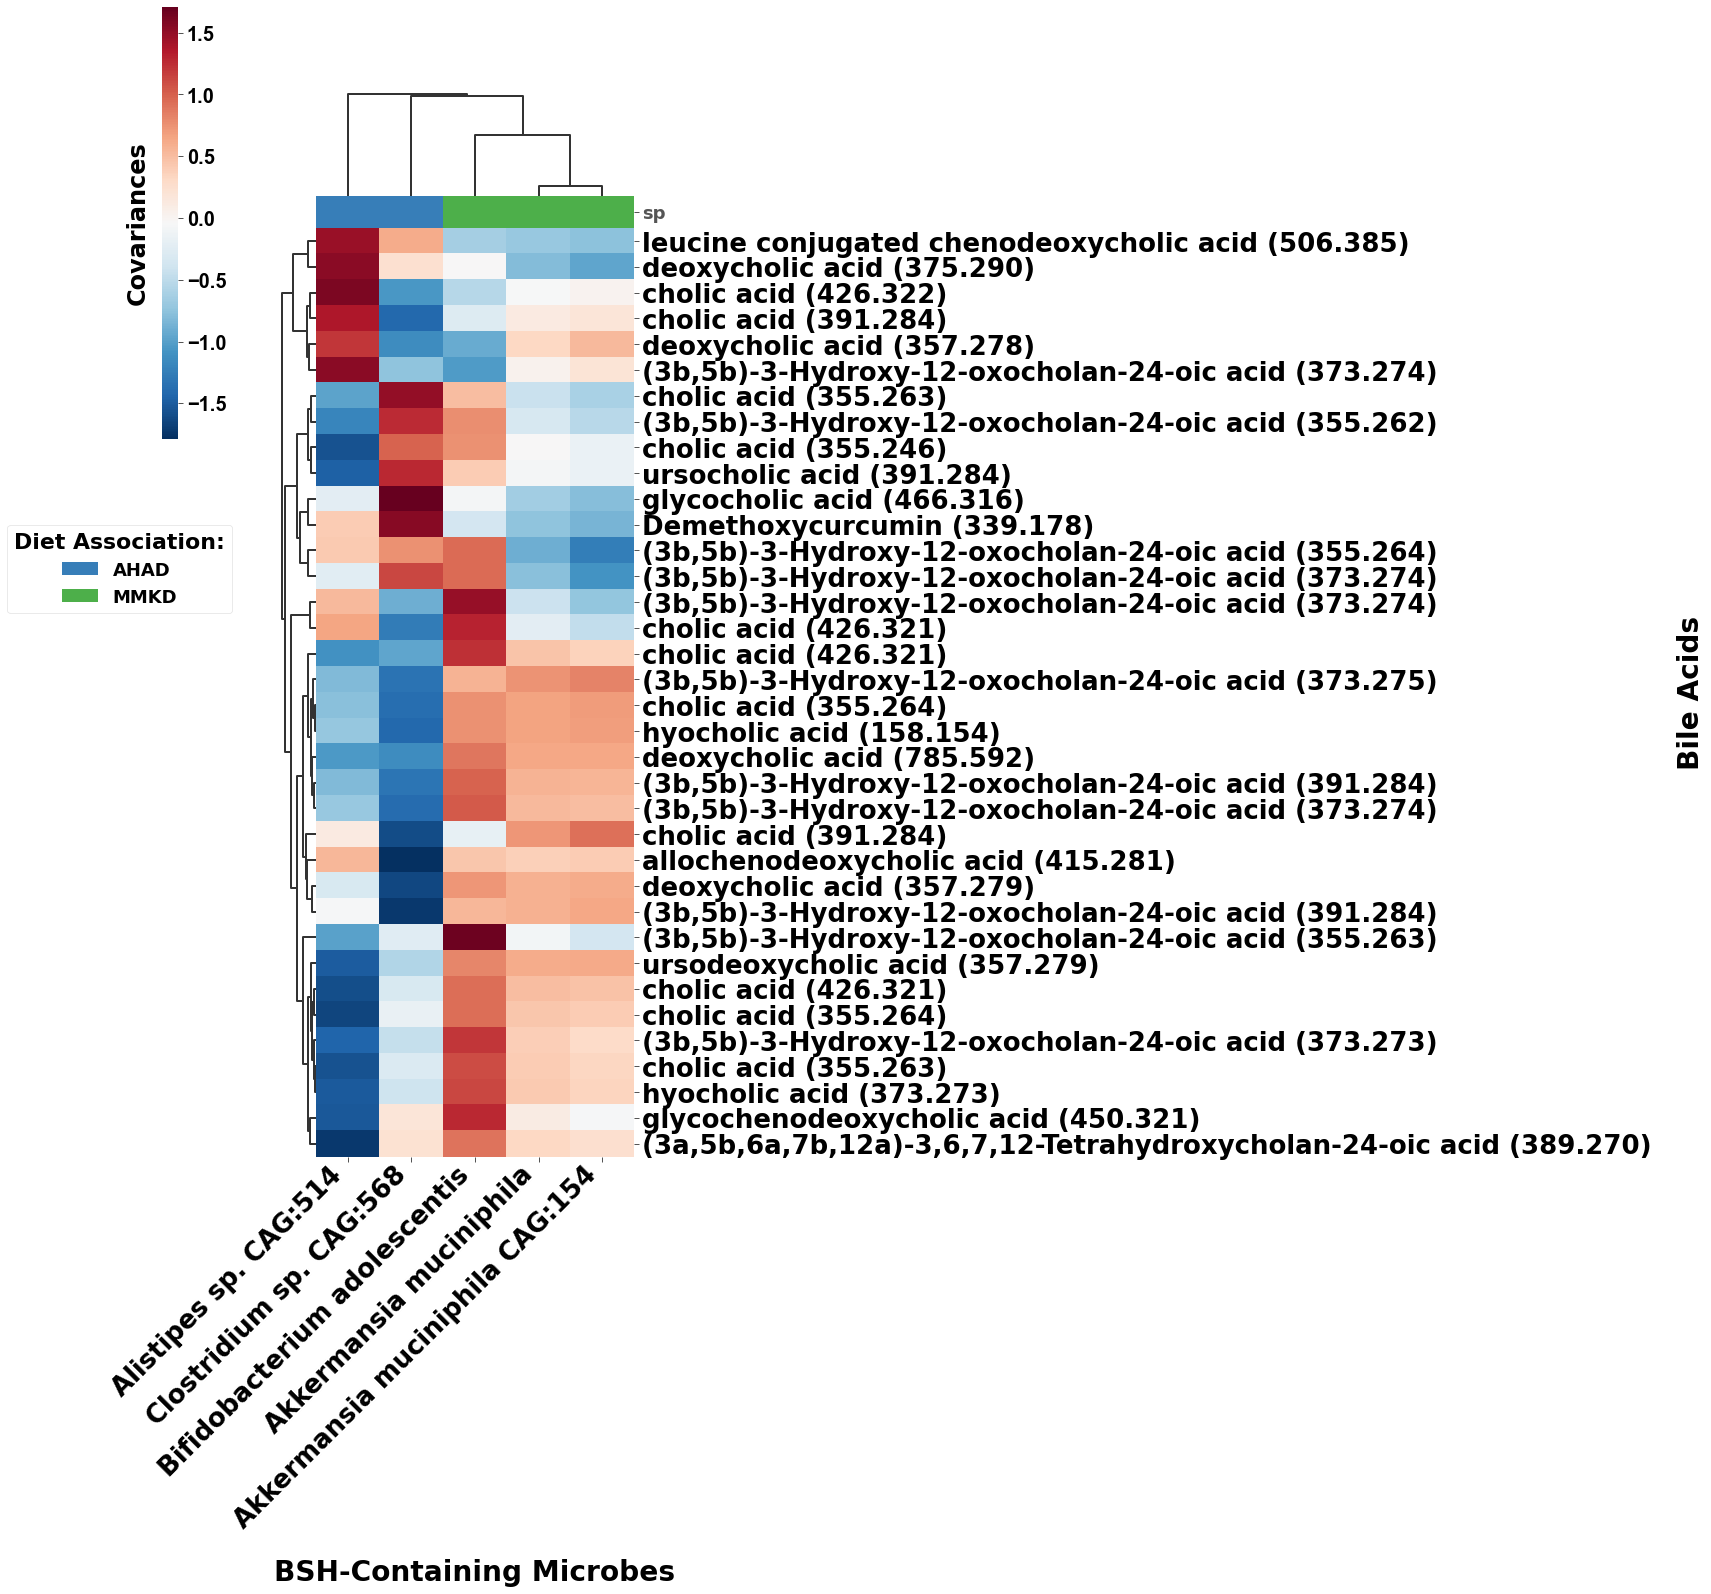

In [43]:
from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)

diff_microbes_ba = ['G000020225', 'G000431015', 'G000434395', 'G000436395', 'G000010425']
mmvec_conditionals_ba_subset = mmvec_conditionals_df.loc[list(other_ba) + ['7357 (339.178)'], 
                                                         diff_microbes_ba].dropna()
mmvec_conditionals_ba_subset.columns = taxonomy.loc[diff_microbes_ba, 'species'].values


order_rows = other_ba
metabolomics_ba_fix_add = metabolomics_ba.loc[order_rows, 'name_new'].dropna()
metabolomics_ba_fix_add = metabolomics_ba_fix_add[~metabolomics_ba_fix_add.index.duplicated(keep='first')]
metabolomics_ba_fix_add = dict(metabolomics_ba_fix_add)
metabolomics_ba_fix_add = {k:v + ' '+ k.split(' ')[1] for k, v in metabolomics_ba_fix_add.items()}
metabolomics_ba_fix_add['7357 (339.178)'] = 'Demethoxycurcumin (339.178)'
#metabolomics_ba_fix_add['11216 (295.226)'] = '11216 (295.226): octadecadienoic acid'
#metabolomics_ba_fix_add['12323 (253.118)'] = '12323 (253.118): food (possibly plant)'

mmvec_conditionals_ba_subset_plot = mmvec_conditionals_ba_subset.copy()
mmvec_conditionals_ba_subset_plot.index = [metabolomics_ba_fix_add[x] for x in mmvec_conditionals_ba_subset.index]

g = sns.clustermap(mmvec_conditionals_ba_subset_plot,
                   #vmax=2.0,
                   #vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=col_colors[1:],
                   #row_colors=col_colors[:-1],
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(15, 20),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=0)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','MMKD').replace('no','AHAD') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-1, -3),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('Covariances', rotation=90, 
                 labelpad=-100,
                 fontsize=24, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(20)


    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', fontsize=26, weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=26, weight='bold',)

    
g.ax_heatmap.set_ylabel('Bile Acids' ,color='black',weight='bold',fontsize=28, labelpad=25)
g.ax_heatmap.set_xlabel('BSH-Containing Microbes' ,color='black',weight='bold',fontsize=28, labelpad=25)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
"""

plt.show()


### unconjugated versus conjugated figure

In [46]:
metabolomics_ba.kind

7079 (807.574)       unknown
8934 (799.512)       unknown
7077 (785.592)     secondary
1391 (426.321)       primary
12331 (426.322)      primary
                     ...    
7575 (375.289)       unknown
4370 (373.273)       primary
7723 (389.270)       unknown
6310 (426.321)       primary
7510 (389.270)     secondary
Name: kind, Length: 73, dtype: object

In [47]:
# Unconj to Conj figure 
unconj = metabolomics_ba.loc[metabolomics_ba.status.isin(['unconjugated', 'deconjugated'])]
conj = metabolomics_ba.loc[metabolomics_ba.status == 'conjugated']

# primary to secondary
primary = metabolomics_ba.loc[metabolomics_ba.kind == 'primary']
secondary = metabolomics_ba.loc[metabolomics_ba.kind == 'secondary']

# GC to CA figure
gc = metabolomics_ba.loc[metabolomics_ba.name_new == 'glycocholic acid']
ca = metabolomics_ba.loc[metabolomics_ba.name_new == 'cholic acid']

In [48]:
metadata_lr = metadata.copy()
metadata_lr['log_ratio_unc'] = (np.log(df_all_matabs_table_ps.loc[unconj.index].sum()) - 
                                np.log(df_all_matabs_table_ps.loc[conj.index].sum()))
metadata_lr['log_ratio_p_s'] = (np.log(df_all_matabs_table_ps.loc[primary.index].sum()) - 
                                np.log(df_all_matabs_table_ps.loc[secondary.index].sum()))
metadata_lr['log_ratio_gc'] = (np.log(df_all_matabs_table_ps.loc[gc.index].sum()) - 
                               np.log(df_all_matabs_table_ps.loc[ca.index].sum()))

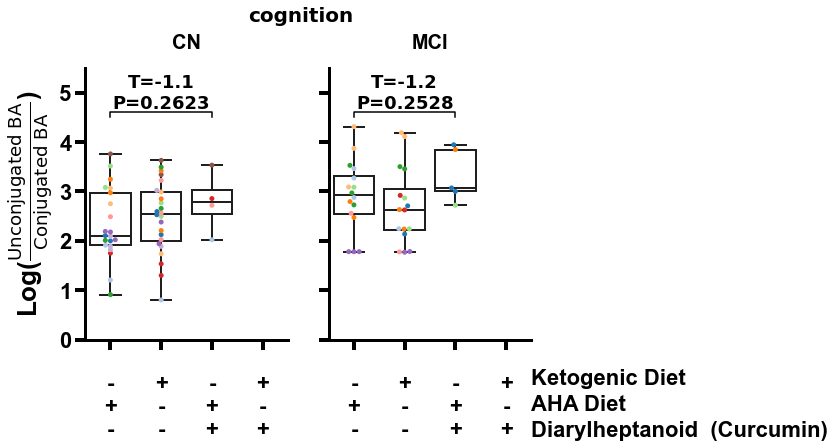

In [50]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

label_ = 'Log($\\frac{\mathrm{Unconjugated\,\, BA}}{\mathrm{Conjugated\,\, BA}}$)'

fig, axn = plt.subplots(1, 2, figsize=(8,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mflr_metag.copy().merge(metadata_lr[['log_ratio_unc']], right_index=True, left_index=True)
mf_lr_df_subset = mf_lr_df_subset[mf_lr_df_subset.diet_nocross_turmeric.isin([k for k, v in mf_lr_df_subset['diet_nocross_turmeric'].value_counts().items() if v > 1])]

for title_, ax in zip(['NC', 'MCI'], axn):

    y_ = 'log_ratio_unc'
    
    map_pls_minus = {'no turmeric - AHA Diet':'\n-\n+\n-',
                     'no turmeric - Ketogenic Diet':'\n+\n-\n-',
                     'turmeric - AHA Diet':'\n-\n+\n+',
                     'turmeric - Ketogenic Diet':'\n+\n-\n+'}
    mf_lr_df_subset['diet_nocross_turmeric_code'] = [map_pls_minus[x] 
                                                     for x in mf_lr_df_subset.diet_nocross_turmeric]
    
    order_map = {'\n-\n+\n-':0,
                 '\n+\n-\n-':1,
                 '\n-\n+\n+':2,
                 '\n+\n-\n+':3}
    order_ = ['\n-\n+\n-', '\n+\n-\n-', '\n-\n+\n+', '\n+\n-\n+']
    
    
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.cog == title_].dropna(subset=[y_, 'diet_nocross_turmeric_code'])
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diet_nocross_turmeric_code')}
    comobos = [('\n-\n+\n-', '\n-\n+\n+')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot, 
                  palette='tab20',
                  hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.legend_.remove()
    ax.set_ylim(0, 5.5)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1) + 4.5, 0.1, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=18,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)

val_ = 0.0
for yv_ in ['Ketogenic Diet', 'AHA Diet', 'Diarylheptanoid  (Curcumin)']:
    plt.figtext(0.9, val_, yv_, fontproperties='arial',
                weight='extra bold', fontsize=22,
                horizontalalignment='left')
    val_ -= 0.0725
    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()


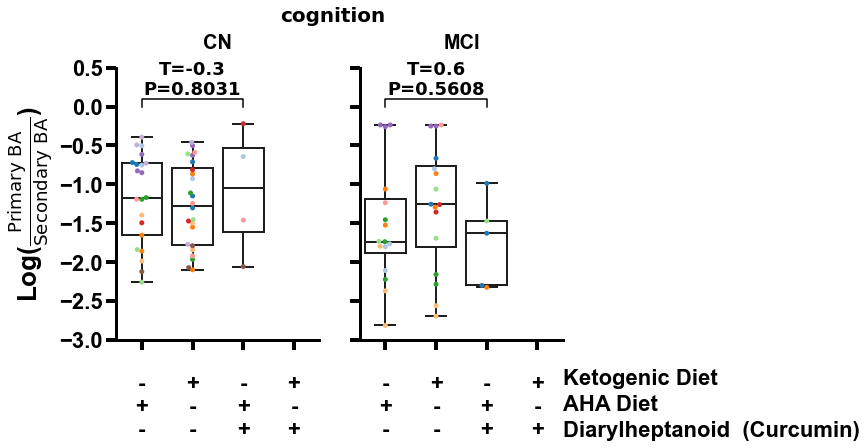

In [56]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

label_ = 'Log($\\frac{\mathrm{Primary\,\, BA}}{\mathrm{Secondary\,\, BA}}$)'

fig, axn = plt.subplots(1, 2, figsize=(8,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mflr_metag.copy().merge(metadata_lr[['log_ratio_p_s']], right_index=True, left_index=True)
mf_lr_df_subset = mf_lr_df_subset[mf_lr_df_subset.diet_nocross_turmeric.isin([k for k, v in mf_lr_df_subset['diet_nocross_turmeric'].value_counts().items() if v > 1])]

for title_, ax in zip(['NC', 'MCI'], axn):

    y_ = 'log_ratio_p_s'
    
    map_pls_minus = {'no turmeric - AHA Diet':'\n-\n+\n-',
                     'no turmeric - Ketogenic Diet':'\n+\n-\n-',
                     'turmeric - AHA Diet':'\n-\n+\n+',
                     'turmeric - Ketogenic Diet':'\n+\n-\n+'}
    mf_lr_df_subset['diet_nocross_turmeric_code'] = [map_pls_minus[x] 
                                                     for x in mf_lr_df_subset.diet_nocross_turmeric]
    
    order_map = {'\n-\n+\n-':0,
                 '\n+\n-\n-':1,
                 '\n-\n+\n+':2,
                 '\n+\n-\n+':3}
    order_ = ['\n-\n+\n-', '\n+\n-\n-', '\n-\n+\n+', '\n+\n-\n+']
    
    
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.cog == title_].dropna(subset=[y_, 'diet_nocross_turmeric_code'])
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diet_nocross_turmeric_code')}
    comobos = [('\n-\n+\n-', '\n-\n+\n+')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot, 
                  palette='tab20',
                  hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.legend_.remove()
    ax.set_ylim(-3, 0.5)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1), 0.1, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=18,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)

val_ = 0.0
for yv_ in ['Ketogenic Diet', 'AHA Diet', 'Diarylheptanoid  (Curcumin)']:
    plt.figtext(0.9, val_, yv_, fontproperties='arial',
                weight='extra bold', fontsize=22,
                horizontalalignment='left')
    val_ -= 0.0725
    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

### collapse bile acids with same annotations, similar retention times

In [53]:
metabolomics_ba.loc[metabolomics_ba.name_new != 'unknown bile acid'].shape

(46, 51)

In [54]:
# counts - cholic acid: 15
# deoxycholic acid: 4
# glycocholic acid: 1
# 12-ketodeoxycholic acid: 1
# ursodeoxycholic acid: 2
# Phe-DCA: 1
# glycochenodeoxycholic acid: 1
# lithocholic acid: 1
# hyocholic acid: 2
# (3b,5b)-3-Hydroxy-12-oxocholan-24-oic acid: 14
# allochenodeoxycholic acid: 1
# ursocholic acid: 1
# (3a,5b,6a,7b,12a)-3,6,7,12-Tetrahydroxycholan-24-oic acid: 1
metabolomics_ba.loc[metabolomics_ba.name_new != 'unknown bile acid']['name_new'].unique()

array(['deoxycholic acid', 'cholic acid', 'glycocholic acid',
       '12-ketodeoxycholic acid', 'ursodeoxycholic acid',
       'Phenylalanine-conjugated deoxycholic acid',
       'glycochenodeoxycholic acid',
       'leucine conjugated chenodeoxycholic acid', 'lithocholic acid',
       'hyocholic acid', '(3b,5b)-3-Hydroxy-12-oxocholan-24-oic acid',
       'allochenodeoxycholic acid', 'ursocholic acid',
       '(3a,5b,6a,7b,12a)-3,6,7,12-Tetrahydroxycholan-24-oic acid'],
      dtype=object)

In [55]:
collapsed_annotations = {'CA_RT_3.8': ['f7148', 'f6493', 'f2172', 'f5156', 'f13419', 'f7502', 'f6918', 'f6310', 
                                       'f2081'],
                         'CA_RT_4.2': ['f1391', 'f12331', 'f7226', 'f7439', 'f4813'],
                         'CA_RT_5': ['f4858'],
                         'CA-1beta-ol': ['f7510'], 
                         'DCA_RT_4.7': ['f9249', 'f2046', 'f7077'],
                         'DCA_RT_7.3': ['f10291'], 
                         '3Beta-DCA_RT_4': ['f9011'], 
                         '3Beta-DCA_RT_4.6': ['f1038', 'f7784', 'f5250', 'f348', 'f62', 'f11833', 'f9171', 'f541', 
                                              'f6360'],
                         '3Beta-DCA_RT_6.1': ['f1982', 'f8679', 'f13871', 'f8555'], 
                         'flat-CDCA' : ['f6128'], 
                         '12-ketoDCA': ['f13796'],
                         'LCA': ['f13360'],
                         'HCA': ['f430', 'f4370'],
                         'UC': ['f7483'], 
                         'UDCA_RT_4.2': ['f9524'], 
                         'UDCA_RT_6.95': ['f13088'], 
                         'GC': ['f1135'], 
                         'Phe-DCA': ['f12251'], 
                         'Gly-CDCA': ['f853'], 
                         'Leu-CDCA': ['f7672']}

collapsed_quants = pd.DataFrame(index=collapsed_annotations.keys(), columns=metab_df.columns)

for a in collapsed_annotations.keys(): 
    collapsed_quants.loc[a] = metab_df.loc[collapsed_annotations[a]].sum()

In [45]:
# import collapsed quants into Q2
# remove the sample that does not overlap from the metaG table 

# create the metadata & train/test 
# run mmvec! 

In [46]:
metag_table = q2.Artifact.load('../data/metaG/metaG-matched-table.qza')
metag_table_df = metag_table.view(pd.DataFrame)
shared_ids = metag_table_df.index & collapsed_quants.columns

metag_table_shared = metag_table_df.loc[shared_ids]

metag_table_filt = q2.Artifact.import_data('FeatureTable[Frequency]', metag_table_shared)
ba_table = q2.Artifact.import_data('FeatureTable[Frequency]', collapsed_quants.T)

# save tables 
metag_table_filt.save('../data/bile_acids_mmvec/metag_table.qza')
ba_table.save('../data/bile_acids_mmvec/ba_table.qza')

'../data/bile_acids_mmvec/ba_table.qza'

In [47]:
'''
metadata_metag = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza').to_dataframe()

metadata_filt = metadata_metag.loc[shared_ids]
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# build train-test groups

metadata_filt['merge_groups'] = metadata_filt['first_diet'].astype(str) + metadata_filt['diet'].astype(str) + metadata_filt['timepoint_encoded'].astype(str)
metadata_filt['merge_groups_encode'] = le.fit_transform(metadata_filt['merge_groups'])

_, _, y_train, y_test = train_test_split(metadata_filt['diet_nocross'] , 
                                         metadata_filt['diet_nocross'], 
                                         test_size=0.5, random_state=28, 
                                         stratify=metadata_filt['diet_nocross'])
metadata_filt.loc[y_test.index, 'mmvec_train_test_splits'] = 'Test'
metadata_filt.loc[y_train.index, 'mmvec_train_test_splits'] = 'Train'

metadata_filt.rename_axis(index='SampleID', inplace=True)
metadata_filt.to_csv('../data/bile_acids_mmvec/metadata.tsv', sep='\t')
'''
metadata_filt = pd.read_csv('../data/bile_acids_mmvec/metadata.tsv', sep='\t', dtype={'SampleID':'str'})
metadata_filt = metadata_filt.set_index('SampleID')

In [49]:
from qiime2.plugins import mmvec

In [50]:
res = mmvec.methods.paired_omics(microbes=metag_table_filt, 
                                 metabolites=ba_table, 
                                 metadata = q2.Metadata(metadata_filt), 
                                 training_column = 'mmvec_train_test_splits',
                                 latent_dim = 0,
                                 batch_size = 1000,
                                 epochs = 300)



Instructions for updating:
Use `tf.random.categorical` instead.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




100%|██████████| 25896/25896 [00:39<00:00, 657.80it/s]


In [99]:
collapsed_cond_df = res.conditionals.view(pd.DataFrame)

### collapsed mmvec figure 

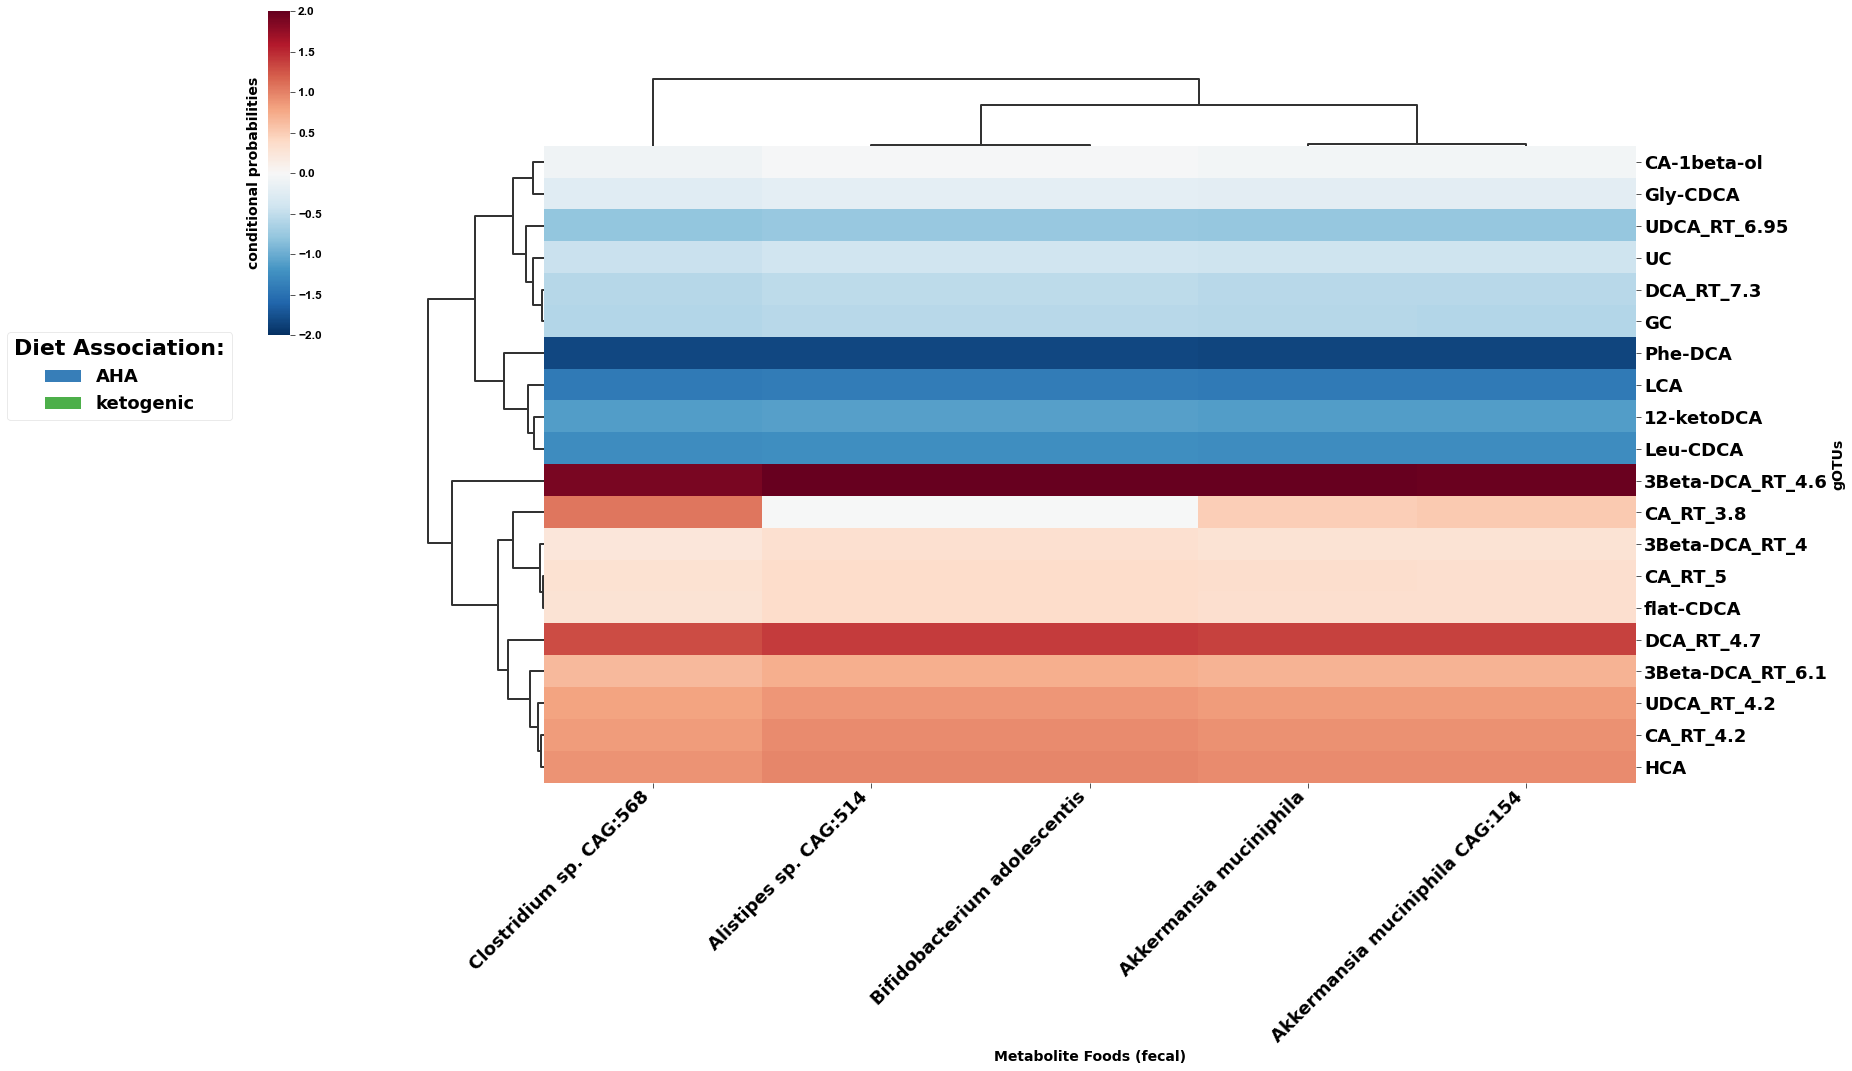

In [106]:
diff_microbes_ba = ['G000020225', 'G000431015', 'G000434395', 'G000436395', 'G000010425']
mmvec_conditionals_ba_subset = collapsed_cond_df[diff_microbes_ba]
mmvec_conditionals_ba_subset.columns = taxonomy.loc[diff_microbes_ba, 'species'].values

g = sns.clustermap(mmvec_conditionals_ba_subset,
                   vmax=2.0,
                   vmin=-2.0,
                   row_cluster=True,
                   col_cluster=True,
                   #col_colors=col_colors[1:],
                   #row_colors=col_colors[:-1],
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(20, 15),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=1)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','ketogenic').replace('no','AHA') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('conditional probabilities', rotation=90, 
                 labelpad=-75,
                 fontsize=14, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=18, weight='bold',)

g.ax_heatmap.set_ylabel('gOTUs' ,color='black',weight='bold',fontsize=14)
g.ax_heatmap.set_xlabel('Metabolite Foods (fecal)' ,color='black',weight='bold',fontsize=14)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
"""

plt.show()

### unconjugated versus conjugated figure 

In [136]:
unconj = collapsed_quants.loc[['HCA', 'CA_RT_3.8', 'CA_RT_4.2', 'CA_RT_5', '3Beta-DCA_RT_4', '3Beta-DCA_RT_4.6', 
                       '3Beta-DCA_RT_6.1', 'DCA_RT_4.7', 'DCA_RT_7.3', 'flat-CDCA', '12-ketoDCA', 'CA-1beta-ol']]
conj = collapsed_quants.loc[['UDCA_RT_4.2', 'UDCA_RT_6.95', 'Leu-CDCA', 'LCA', 'Phe-DCA', 'GC', 'UC', 'Gly-CDCA']]

primary = collapsed_quants.loc[['HCA', 'CA_RT_3.8', 'CA_RT_4.2', 'CA_RT_5', 'Gly-CDCA', 'Leu-CDCA', 'flat-CDCA', ]]
secondary = collapsed_quants.loc[['3Beta-DCA_RT_4', '3Beta-DCA_RT_4.6', '3Beta-DCA_RT_6.1', 'DCA_RT_4.7', 'DCA_RT_7.3',
                          '12-ketoDCA', 'CA-1beta-ol', 'UDCA_RT_4.2', 'UDCA_RT_6.95', 'LCA', 'Phe-DCA', 'GC', 'UC']]

In [161]:
collap_num = collapsed_quants.loc[['GC']]
collap_dem = collapsed_quants.loc[['CA_RT_3.8', 'CA_RT_4.2', 'CA_RT_5']]

In [176]:
valid_gc = collapsed_quants.loc['GC'][collapsed_quants.loc['GC'] > 10000].index
collap_num_gc = collap_num[valid_gc]
collap_dem_gc = collap_num[valid_gc]

In [177]:
metadata_lr = metadata.copy()
metadata_lr['log_ratio_unc'] = np.log(unconj.sum() + 1) - np.log(conj.sum() + 1)
metadata_lr['log_ratio_p_s'] = np.log(primary.sum() + 1) - np.log(secondary.sum() + 1)
metadata_lr['log_ratio_gc'] = np.log(collap_num.sum() + 1) - np.log(collap_dem.sum() + 1)
metadata_lr['log_ratio_gc_valid'] = np.log(collap_num.sum()) - np.log(collap_dem.sum())

In [ ]:
unconj_num_ = metabolomics_ba.loc[unconj.abbreviation.unique()]

conj_den_ = metabolomics_ba.loc[conj.abbreviation.unique()]


df_all_matabs_table_ps = df_all_matabs_table.copy() + df_all_matabs_table.mean().mean()
metadata_lr = metadata.copy()
metadata_lr['log_ratio'] = np.log(df_all_matabs_table_ps.loc[num_, :].sum(0)) - np.log(df_all_matabs_table_ps.loc[den_, :].sum(0))

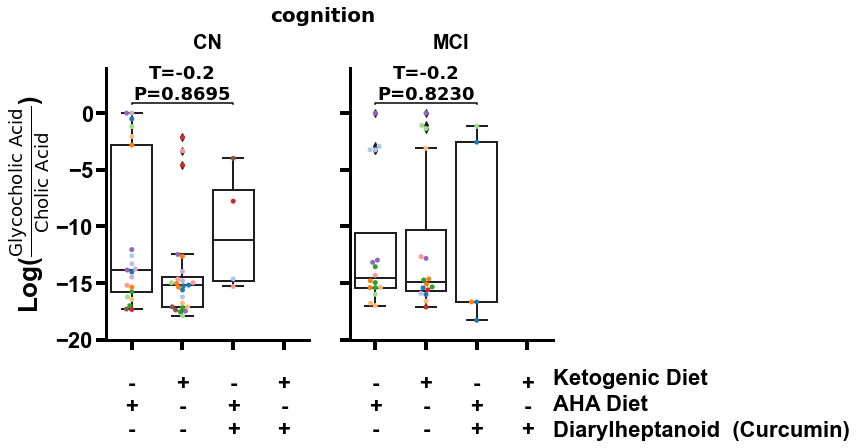

In [192]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

label_ = 'Log($\\frac{\mathrm{Glycocholic\,\, Acid}}{\mathrm{Cholic\,\, Acid}}$)'

fig, axn = plt.subplots(1, 2, figsize=(8,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mflr_metag.copy().merge(metadata_lr[['log_ratio_unc', 'log_ratio_p_s', 'log_ratio_gc', 
                                                       'log_ratio_gc_valid']], right_index=True, left_index=True)
mf_lr_df_subset = mf_lr_df_subset[mf_lr_df_subset.diet_nocross_turmeric.isin([k for k, v in mf_lr_df_subset['diet_nocross_turmeric'].value_counts().items() if v > 1])]

for title_, ax in zip(['NC', 'MCI'], axn):

    y_ = 'log_ratio_gc'
    
    map_pls_minus = {'no turmeric - AHA Diet':'\n-\n+\n-',
                     'no turmeric - Ketogenic Diet':'\n+\n-\n-',
                     'turmeric - AHA Diet':'\n-\n+\n+',
                     'turmeric - Ketogenic Diet':'\n+\n-\n+'}
    mf_lr_df_subset['diet_nocross_turmeric_code'] = [map_pls_minus[x] 
                                                     for x in mf_lr_df_subset.diet_nocross_turmeric]
    
    order_map = {'\n-\n+\n-':0,
                 '\n+\n-\n-':1,
                 '\n-\n+\n+':2,
                 '\n+\n-\n+':3}
    order_ = ['\n-\n+\n-', '\n+\n-\n-', '\n-\n+\n+', '\n+\n-\n+']
    
    
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.cog == title_].dropna(subset=[y_, 'diet_nocross_turmeric_code'])
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diet_nocross_turmeric_code')}
    comobos = [('\n-\n+\n-', '\n-\n+\n+')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot, 
                  palette='tab20',
                  hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='diet_nocross_turmeric_code', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.legend_.remove()
    ax.set_ylim(-20, 4)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1) + 0.8, 0.1, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=18,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)

val_ = 0.0
for yv_ in ['Ketogenic Diet', 'AHA Diet', 'Diarylheptanoid  (Curcumin)']:
    plt.figtext(0.9, val_, yv_, fontproperties='arial',
                weight='extra bold', fontsize=22,
                horizontalalignment='left')
    val_ -= 0.0725
    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()


In [80]:
#csf_beam = pd.read_excel('../data/BEAM_meta_data_071221.xls', sheet_name='CSF-Biomarkers-py', index_col=[0,1])



# wisc


In [47]:
wisc_micro = q2.Artifact.load('../data/wisc-WGS-csf/nomatch134894_filtered_table-no_rarefied.qza')
wisc_micro_bt_df  = wisc_micro.view(Table).to_dataframe()
wisc_mf = pd.read_csv('../data/wisc-WGS-csf/13663_20220114-125656.txt', index_col=0, sep='\t')
wisc_mf = wisc_mf[wisc_mf['reggieid'] != 'not applicable']
wisc_mf['reggieid'] = wisc_mf['reggieid'].astype(int)

wisc_csf = q2.Artifact.load('../data/wisc-WGS-csf/csf_metabolon.qza')
wisc_csf_bt_df  = wisc_csf.view(Table).to_dataframe()
wisc_mf_csf = pd.read_csv('../data/wisc-WGS-csf/metadata.tsv', index_col=0, sep='\t').drop(['#q2:types'])
csf_met_lbls = pd.read_csv('../data/wisc-WGS-csf/metabolite/csf_metabolite_info_updated_9_6_2019.csv', index_col=0)


In [48]:

#wisc_csf_bt_df_ps = pd.DataFrame(closure(wisc_csf_bt_df.T).T * 100,
#                                 wisc_csf_bt_df.index, wisc_csf_bt_df.columns)
wisc_csf_bt_df_ps = wisc_csf_bt_df.copy()
wisc_csf_bt_df_ps = wisc_csf_bt_df_ps.reindex(wisc_mf_csf.index, axis=1)

gaba_metabs = ['met40007'] #GABA
plant_metabs = csf_met_lbls[csf_met_lbls.SUB_PATHWAY.isin(['Food Component/Plant'])].index

lr = wisc_csf_bt_df_ps.loc[gaba_metabs, :].sum(0)
lr[~np.isfinite(lr)] = np.nan
wisc_mf_csf['gaba_log_ratio_metab'] = lr


In [49]:
wisc_micro_bt_df_ps = wisc_micro_bt_df + 0
wisc_micro_bt_df_ps = wisc_micro_bt_df_ps.reindex(wisc_mf.index, axis=1)

num_use = [x for x in bsh_sp if 'adolescentis' in x]
denom_use = set(other_genomes) & set(other_genomes_gaba)
num = taxonomy[taxonomy.species.isin(num_use)].index
den = taxonomy[taxonomy.species.isin(denom_use)].index
lr = np.log(wisc_micro_bt_df_ps.loc[num, :].sum(0)) - np.log(wisc_micro_bt_df_ps.loc[den, :].sum(0))
lr[~np.isfinite(lr)] = np.nan
wisc_mf['bsh_log_ratio_microbe'] = lr

num_use = gaba_genomes 
denom_use = other_genomes_gaba 
num = taxonomy[taxonomy.species.isin(num_use)].index
den = taxonomy[taxonomy.species.isin(denom_use)].index
lr = np.log(wisc_micro_bt_df_ps.loc[num, :].sum(0)) - np.log(wisc_micro_bt_df_ps.loc[den, :].sum(0))
lr[~np.isfinite(lr)] = np.nan
wisc_mf['gaba_log_ratio_microbe'] = lr
wisc_mf['bsh_high'] = wisc_mf['bsh_log_ratio_microbe'] > wisc_mf['bsh_log_ratio_microbe'].median()


In [50]:

plasma_metab = pd.read_csv('../data/wisc-WGS-csf/metabolite/plasma_metabolite_data_raw.csv')
plasma_metab = plasma_metab.sort_values('age_at_metabolite_sample').set_index('reggieid').drop(['DBID','age_at_metabolite_sample'], axis=1)
shared_ = (set(plasma_metab.index) & set(wisc_mf['reggieid']))
plasma_metab = plasma_metab.loc[shared_, :]
plasma_metab = plasma_metab[~plasma_metab.index.duplicated(keep='first')]
mf_plasma = pd.DataFrame({k:[v['apoe4'].values[0], v['diagnosis'].values[0].lower(), v['bsh_high'].values[0]] for k, v in wisc_mf.groupby('reggieid')}, ['apoe4','diagnosis','bsh_high']).T
mf_plasma = mf_plasma.loc[plasma_metab.index, :]
#.drop([10233,3745,3912, 2275])
plasma_metab  = plasma_metab.T
plasma_met_lbls = pd.read_csv('../data/wisc-WGS-csf/metabolite/plasma_metabolite_info_updated_9_6_2019.csv', index_col=0)



In [51]:
plasma_metab_ps = plasma_metab.copy()
plasma_metab_ps = plasma_metab_ps.reindex(mf_plasma.index, axis=1)

#gaba_metabs = ['met40007'] #GABA
plant_metabs = plasma_met_lbls[plasma_met_lbls.SUB_PATHWAY.isin(['Short Chain Fatty Acid'])].index

bamap_metabolon = pd.read_csv('../data/wisc-WGS-csf/metabolite/metabolonba.csv')
num_ = set(bamap_metabolon[bamap_metabolon.status.isin(['unconjugated'])].biochem)
num_ = ['cholate','cholic acid glucuronide']
den_ = set(bamap_metabolon[bamap_metabolon.status.isin(['conjugated'])].biochem)
den_ = ['taurocholate','glycocholate']
num_ = plasma_met_lbls[plasma_met_lbls.BIOCHEMICAL.isin(num_)].index
den_ = plasma_met_lbls[plasma_met_lbls.BIOCHEMICAL.isin(den_)].index

lr = np.log(plasma_metab_ps.loc[num_, :].sum(0)) - np.log(plasma_metab_ps.loc[den_, :].sum(0))
lr[~np.isfinite(lr)] = np.nan
mf_plasma['ba_log_ratio_metab'] = lr
mf_plasma['bsh_high'] = mf_plasma['bsh_high'].replace(True,"high BSH").replace(False,"low BSH")
mf_plasma['plant_amount'] = plasma_metab_ps.loc[plant_metabs, mf_plasma.index].sum(0)


mf_plasma['plant_high'] = mf_plasma['plant_amount'] > mf_plasma['plant_amount'].median()
mf_plasma['plant_high'] = mf_plasma['plant_high'].replace(True,"high plant").replace(False,"low plant")

mf_plasma['bsh_plant_high'] = mf_plasma['plant_high'] + ' - ' + mf_plasma['bsh_high']

mf_plasma['apoe4']= [v.lower() for v in mf_plasma['apoe4']]
mf_plasma['diagnosis']= [v.lower() for v in mf_plasma['diagnosis']]
mf_plasma['apoe4_diag'] = mf_plasma['plant_high'] + ' - ' + mf_plasma['bsh_high'] + ' - ' + mf_plasma['diagnosis']

#drug_ind = plasma_met_lbls[plasma_met_lbls.SUB_PATHWAY.isin([x for x in plasma_met_lbls.SUB_PATHWAY if 'drug' in x.lower()])].index
#mf_plasma['drug'] = plasma_metab_ps.loc[drug_ind, mf_plasma.index].sum(0)



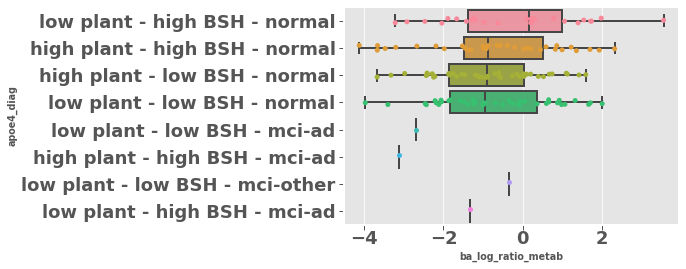

In [52]:

sns.boxplot(x='ba_log_ratio_metab', y='apoe4_diag', data=mf_plasma)
sns.stripplot(x='ba_log_ratio_metab', y='apoe4_diag', data=mf_plasma)

plt.show()


In [53]:
mf_plasma['diagnosis'].value_counts()

normal       160
mci-ad         3
mci-other      1
Name: diagnosis, dtype: int64

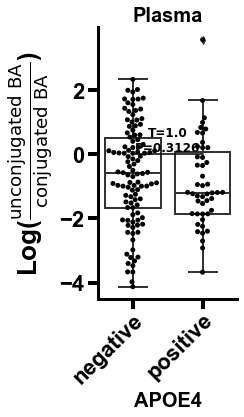

In [54]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'


label_ = 'Log($\\frac{\mathrm{unconjugated\,\,BA}}{\mathrm{conjugated\,\,BA}}$)'

fig, ax = plt.subplots(1, 1, figsize=(2.5,5), sharey=True)

from collections import Counter


lrdf_plot = mf_plasma.copy()

y_ = 'ba_log_ratio_metab'
order_map = {'negative':0, 'positive':1}
order_ = ['negative', 'positive']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('apoe4')}
comobos = [('negative', 'positive')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='apoe4', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='apoe4', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
#ax.set_ylim(0, 800000)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')
     

ax.set_xlabel('APOE4',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_title('Plasma',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 0.01, 0.00015, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.00007,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

In [55]:
set(bamap_metabolon[bamap_metabolon.status.isin(['unconjugated'])].biochem)

{'chenodeoxycholate',
 'chenodeoxycholic acid sulfate (1)',
 'cholate',
 'cholic acid glucuronide'}

In [56]:
set(bamap_metabolon[bamap_metabolon.status.isin(['conjugated'])].biochem)

{'glycochenodeoxycholate',
 'glycochenodeoxycholate glucuronide (1)',
 'glycochenodeoxycholate sulfate',
 'glycocholate',
 'glycocholate glucuronide (1)',
 'glycocholenate sulfate*',
 'glycodeoxycholate',
 'glycodeoxycholate sulfate',
 'glycohyocholate',
 'glycolithocholate',
 'glycolithocholate sulfate*',
 'glycoursodeoxycholate',
 'glycoursodeoxycholic acid sulfate (1)',
 'isoursodeoxycholate',
 'isoursodeoxycholate sulfate (1)',
 'lithocholate sulfate (1)',
 'taurochenodeoxycholate',
 'taurochenodeoxycholic acid 3-sulfate',
 'taurocholate',
 'taurocholenate sulfate',
 'taurodeoxycholate',
 'taurodeoxycholic acid 3-sulfate',
 'taurolithocholate 3-sulfate',
 'tauroursodeoxycholate'}

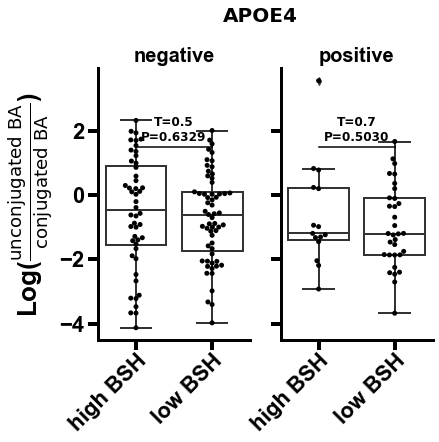

In [57]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

label_ = 'Log($\\frac{\mathrm{unconjugated\,\,BA}}{\mathrm{conjugated\,\,BA}}$)'


fig, axn = plt.subplots(1, 2, figsize=(6,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mf_plasma.copy()

for title_, ax in zip(['negative', 'positive'], axn):

    y_ = 'ba_log_ratio_metab'
    order_map = {'high BSH':0, 'low BSH':1}
    order_ = ['high BSH', 'low BSH']
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.apoe4 == title_].dropna(subset=[y_, 'bsh_high'])

    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('bsh_high')}
    comobos = [('high BSH', 'low BSH')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='bsh_high', 
                  data=lrdf_plot, 
                  color='black',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='bsh_high', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    #ax.set_ylim(-3, 3)

    if title_ == 'negative':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1.2) + 1.5, 0.0001, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.1,
                 p_, ha='center',fontsize=12,
                 va='bottom', color=col)

plt.suptitle('APOE4', fontsize=20, color='black', weight='bold', y=1.05)
        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

In [58]:
set(plasma_met_lbls.SUB_PATHWAY)

{'Acetylated Peptides',
 'Alanine and Aspartate Metabolism',
 'Aminosugar Metabolism',
 'Androgenic Steroids',
 'Ascorbate and Aldarate Metabolism',
 'Bacterial/Fungal',
 'Benzoate Metabolism',
 'Carnitine Metabolism',
 'Ceramides',
 'Chemical',
 'Corticosteroids',
 'Creatine Metabolism',
 'Diacylglycerol',
 'Dipeptide',
 'Drug - Analgesics, Anesthetics',
 'Drug - Antibiotic',
 'Drug - Antiinflammatory, Immunosuppressant',
 'Drug - Antineoplastic',
 'Drug - Cardiovascular',
 'Drug - Gastrointestinal',
 'Drug - Metabolic',
 'Drug - Neurological',
 'Drug - Other',
 'Drug - Psychoactive',
 'Drug - Respiratory',
 'Drug - Topical Agents',
 'Endocannabinoid',
 'Estrogenic Steroids',
 'Fatty Acid Metabolism (Acyl Carnitine, Medium Chain)',
 'Fatty Acid Metabolism (Acyl Carnitine, Monounsaturated)',
 'Fatty Acid Metabolism (Acyl Choline)',
 'Fatty Acid Metabolism (Acyl Glutamine)',
 'Fatty Acid Metabolism (Acyl Glycine)',
 'Fatty Acid Metabolism (also BCAA Metabolism)',
 'Fatty Acid Metabolism

In [59]:
set(mf_plasma['bsh_plant_high'])

{'high plant - high BSH',
 'high plant - low BSH',
 'low plant - high BSH',
 'low plant - low BSH'}

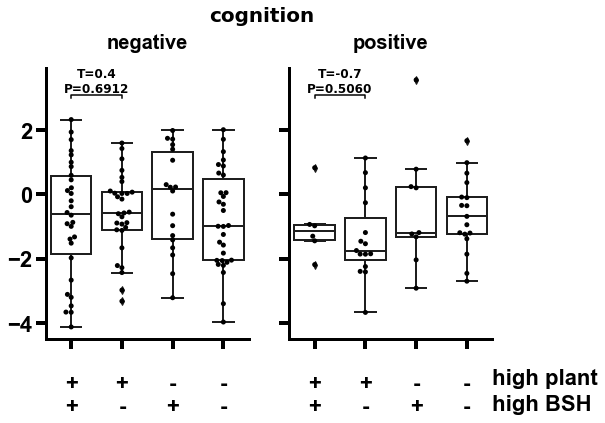

In [60]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

label_ = 'Log($\\frac{\mathrm{unconjugated\,\,BA}}{\mathrm{conjugated\,\,BA}}$)'

fig, axn = plt.subplots(1, 2, figsize=(8,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mf_plasma[mf_plasma.ba_log_ratio_metab > -5.5].copy()
mf_lr_df_subset = mf_plasma.copy()

for title_, ax in zip(['negative', 'positive'], axn):

    y_ = 'ba_log_ratio_metab'
    
    map_pls_minus = {'high plant - high BSH':'\n+\n+',
                     'high plant - low BSH':'\n+\n-',
                     'low plant - high BSH':'\n-\n+',
                     'low plant - low BSH':'\n-\n-'}
    mf_lr_df_subset['bsh_plant_high_code'] = [map_pls_minus[x] 
                                                     for x in mf_lr_df_subset.bsh_plant_high]
    
    order_map = {'\n+\n+':0,
                 '\n+\n-':1,
                 '\n-\n+':2,
                 '\n-\n-':3}
    order_ = ['\n+\n+', '\n+\n-', '\n-\n+', '\n-\n-']
    
    
    
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.apoe4 == title_].dropna(subset=[y_, 'bsh_plant_high_code'])
    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('bsh_plant_high_code')}
    comobos = [('\n+\n-', '\n+\n+')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='bsh_plant_high_code', 
                  data=lrdf_plot, 
                  color='black',
                  #hue='host_subject_id',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='bsh_plant_high_code', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)

    #ax.set_ylim(0, 5)

    if title_ == 'NC':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  y=1.05,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1) + 3, 0.1, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.0000001,
                 p_, ha='center',fontsize=12,
                 va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)

val_ = 0.0
for yv_ in ['high plant', 'high BSH']:
    plt.figtext(0.9, val_, yv_, fontproperties='arial',
                weight='extra bold', fontsize=22,
                horizontalalignment='left')
    val_ -= 0.0725
    
    
    
    
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()


In [61]:
met18335, 

NameError: name 'met18335' is not defined

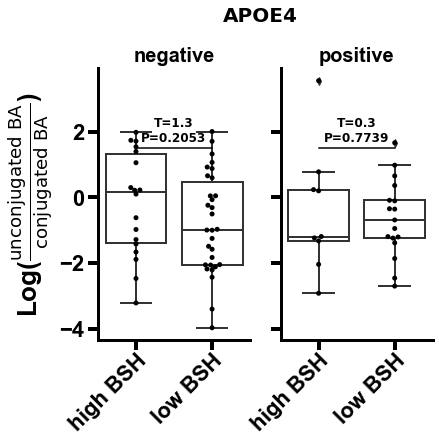

In [62]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

label_ = 'Log($\\frac{\mathrm{unconjugated\,\,BA}}{\mathrm{conjugated\,\,BA}}$)'


fig, axn = plt.subplots(1, 2, figsize=(6,5), sharey=True)

from collections import Counter

mf_lr_df_subset = mf_plasma[mf_plasma.plant_high != 'high plant'].copy()

for title_, ax in zip(['negative', 'positive'], axn):

    y_ = 'ba_log_ratio_metab'
    order_map = {'high BSH':0, 'low BSH':1}
    order_ = ['high BSH', 'low BSH']
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.apoe4 == title_].dropna(subset=[y_, 'bsh_high'])

    t_res = {}
    lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('bsh_high')}
    comobos = [('high BSH', 'low BSH')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='bsh_high', 
                  data=lrdf_plot, 
                  color='black',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='bsh_high', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    #ax.set_ylim(-3, 3)

    if title_ == 'negative':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_.replace('NC', 'CN'),
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1.2) + 1.5, 0.0001, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.1,
                 p_, ha='center',fontsize=12,
                 va='bottom', color=col)

plt.suptitle('APOE4', fontsize=20, color='black', weight='bold', y=1.05)
        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

met22842


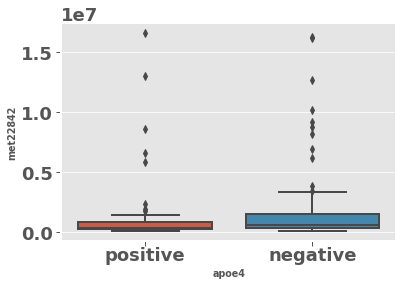

met48772


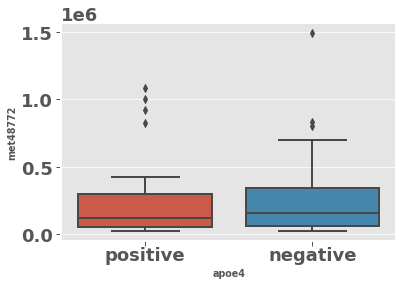

In [63]:
#increase
for i in num_:
    print(i)
    sns.boxplot(x='apoe4', y=i, data=pd.concat([plasma_metab_ps.loc[i, ], mf_plasma],axis=1))
    plt.show()

met18476


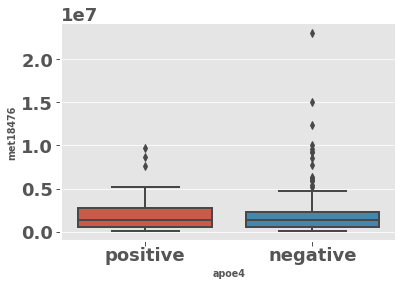

met18497


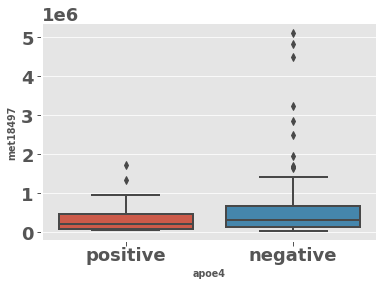

In [64]:
#decrease
for i in den_:
    print(i)
    sns.boxplot(x='apoe4', y=i, data=pd.concat([plasma_metab_ps.loc[i, ], mf_plasma],axis=1))
    plt.show()

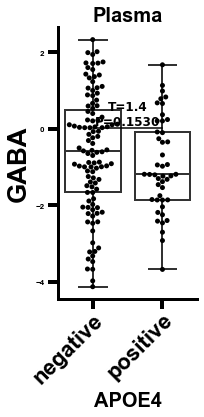

In [65]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'GABA'
fig, ax = plt.subplots(1, 1, figsize=(2.5,5), sharey=True)

from collections import Counter


lrdf_plot = mf_plasma.dropna().sort_values('ba_log_ratio_metab').drop([2275,3745]).copy()

y_ = 'ba_log_ratio_metab'
order_map = {'negative':0, 'positive':1}
order_ = ['negative', 'positive']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('apoe4')}
comobos = [('negative', 'positive')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='apoe4', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='apoe4', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(8)
#ax.set_ylim(0, 800000)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')
     

ax.set_xlabel('APOE4',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_title('Plasma',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 0.01, 0.00015, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.00007,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

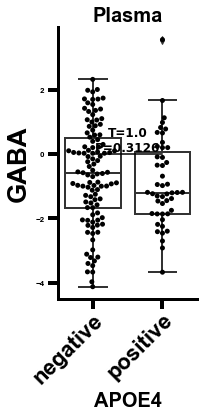

In [66]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'GABA'
fig, ax = plt.subplots(1, 1, figsize=(2.5,5), sharey=True)

from collections import Counter


lrdf_plot = mf_plasma.copy()

y_ = 'ba_log_ratio_metab'
order_map = {'negative':0, 'positive':1}
order_ = ['negative', 'positive']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('apoe4')}
comobos = [('negative', 'positive')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='apoe4', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='apoe4', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(8)
#ax.set_ylim(0, 800000)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')
     

ax.set_xlabel('APOE4',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_title('Plasma',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 0.01, 0.00015, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.00007,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

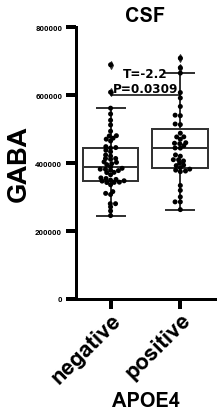

In [67]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'GABA'
fig, ax = plt.subplots(1, 1, figsize=(2.5,5), sharey=True)

from collections import Counter


lrdf_plot = wisc_mf_csf.copy()

y_ = 'gaba_log_ratio_metab'
order_map = {'negative':0, 'positive':1}
order_ = ['negative', 'positive']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('apoe4')}
comobos = [('negative', 'positive')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='apoe4', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='apoe4', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(8)
ax.set_ylim(0, 800000)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')
     

ax.set_xlabel('APOE4',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_title('CSF',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 6e5, 0.00015, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.00007,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()


KeyError: 'negative'

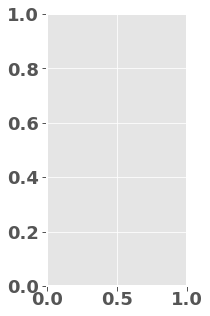

In [68]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'Log($\\frac{\mathrm{BSH\,\,encoded\,\,spp.}}{\mathrm{other\,\,spp.}}$)'
fig, ax = plt.subplots(1, 1, figsize=(2.5,5), sharey=True)

from collections import Counter


lrdf_plot = wisc_mf.copy()

y_ = 'bsh_log_ratio_microbe'
order_map = {'negative':0, 'positive':1}
order_ = ['negative', 'positive']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('apoe4')}
comobos = [('negative', 'positive')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='apoe4', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='apoe4', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
#ax.set_ylim(-10, 2)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')
     

ax.set_xlabel('APOE4',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 0.05, 0.15, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.1,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()


KeyError: 'negative'

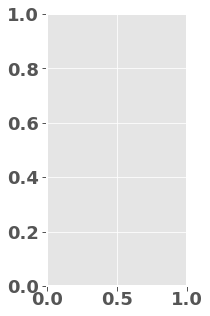

In [69]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'Log($\\frac{\mathrm{GABA\,\,encoded\,\,spp.}}{\mathrm{other\,\,spp.}}$)'
fig, ax = plt.subplots(1, 1, figsize=(2.5,5), sharey=True)

from collections import Counter


lrdf_plot = wisc_mf.copy()

y_ = 'gaba_log_ratio_microbe'
order_map = {'negative':0, 'positive':1}
order_ = ['negative', 'positive']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('apoe4')}
comobos = [('negative', 'positive')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='apoe4', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='apoe4', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
ax.set_ylim(-5, 2)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')
     

ax.set_xlabel('APOE4',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 0.5, 0.15, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.1,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

KeyError: 'normal'

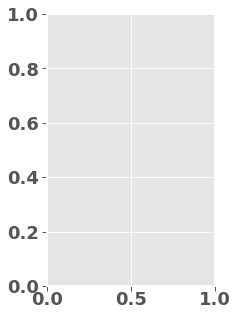

In [70]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'Log($\\frac{\mathrm{BSH\,\,encoded\,\,spp.}}{\mathrm{other\,\,spp.}}$)'
fig, ax = plt.subplots(1, 1, figsize=(3,5), sharey=True)

from collections import Counter


#lrdf_plot = wisc_mf.loc[wisc_mf.pub_selection == 'True', :].copy()
lrdf_plot = wisc_mf[wisc_mf.diagnosis.isin(['normal','dementia-ad'])].copy()

y_ = 'bsh_log_ratio_microbe'
order_map = {'normal':0,  'dementia-ad':1}
order_ = ['normal','dementia-ad']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diagnosis')}
comobos = [('normal', 'dementia-ad')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}


sns.swarmplot(y=y_, x='diagnosis', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='diagnosis', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
#ax.set_ylim(-1, 4)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')

ax.set_xlabel('',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 0.05, 0.15, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.1,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)
        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()


KeyError: 'normal'

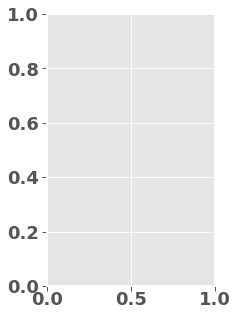

In [71]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'Log($\\frac{\mathrm{GABA\,\,encoded\,\,spp.}}{\mathrm{other\,\,spp.}}$)'
fig, ax = plt.subplots(1, 1, figsize=(3,5), sharey=True)

from collections import Counter


#lrdf_plot = wisc_mf.loc[wisc_mf.pub_selection == 'True', :].copy()
lrdf_plot = wisc_mf[wisc_mf.diagnosis.isin(['normal','dementia-ad'])].copy()

y_ = 'gaba_log_ratio_microbe'
order_map = {'normal':0,  'dementia-ad':1}
order_ = ['normal','dementia-ad']

t_res = {}
lrs_ds = {ds_:dsdf_[y_].dropna().values for ds_, dsdf_ in lrdf_plot.groupby('diagnosis')}
comobos = [('normal', 'dementia-ad')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2], equal_var=False)
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='diagnosis', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='diagnosis', 
              data=lrdf_plot,
              palette='gray',
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
#ax.set_ylim(-1, 4)

ax.set_ylabel(label_,
              fontsize=26,
              family = 'arial',
              weight='bold',
              color='black')

ax.set_xlabel('',
              fontsize=20,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    y, h, col = (i_v * 1.2) + 0.05, 0.15, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.1,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

plt.suptitle('cognition', fontsize=20, color='black', weight='bold', y=1.05)
        
"""plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')"""

plt.show()

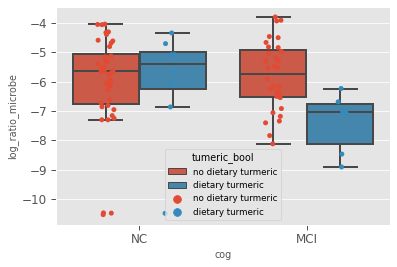

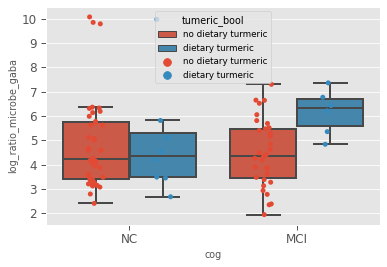

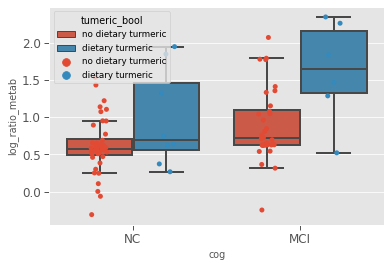

In [1712]:
sns.boxplot(x='cog', hue='tumeric_bool', y='log_ratio_microbe', data=mflr_metag, showfliers=False)
sns.stripplot(x='cog', hue='tumeric_bool', dodge=True, y='log_ratio_microbe', data=mflr_metag)

plt.show()

sns.boxplot(x='cog', hue='tumeric_bool', y='log_ratio_microbe_gaba', data=mflr_metag, showfliers=False)
sns.stripplot(x='cog', hue='tumeric_bool', dodge=True, y='log_ratio_microbe_gaba', data=mflr_metag)

plt.show()


sns.boxplot(x='cog', hue='tumeric_bool', y='log_ratio_metab',  data=mflr_metag, showfliers=False)
sns.stripplot(x='cog',hue='tumeric_bool', y='log_ratio_metab', dodge=True, data=mflr_metag)

plt.show()


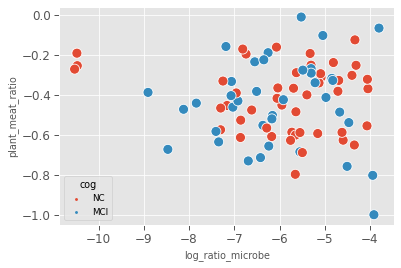

In [1659]:


sns.scatterplot(x='log_ratio_microbe', y='plant_meat_ratio', hue='cog', data=mflr_metag, s=100)
plt.show()




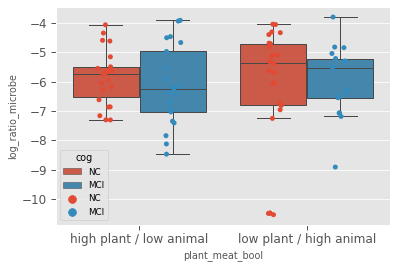

{'high plant / low animal': Ttest_indResult(statistic=0.825503011099984, pvalue=0.4146094264874911),
 'low plant / high animal': Ttest_indResult(statistic=-0.3848393255591904, pvalue=0.7023663503824218)}

In [1660]:
sns.boxplot(x='plant_meat_bool', hue='cog', y='log_ratio_microbe', data=mflr_metag, showfliers=False)
sns.stripplot(x='plant_meat_bool', hue='cog', dodge=True, y='log_ratio_microbe', data=mflr_metag)

plt.show()

{k:ttest_ind(v.loc[v.cog=='NC','log_ratio_microbe'].dropna().values,
             v.loc[v.cog=='MCI','log_ratio_microbe'].dropna().values, equal_var=False)
 for k, v in mflr_metag.groupby('plant_meat_bool')}

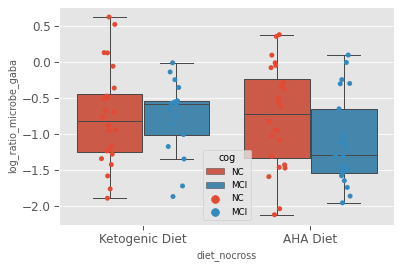

In [1661]:
sns.boxplot(x='diet_nocross', hue='cog', y='log_ratio_microbe_gaba', data=mflr_metag, showfliers=False)
sns.stripplot(x='diet_nocross', hue='cog', dodge=True, y='log_ratio_microbe_gaba', data=mflr_metag)

plt.show()

In [ ]:
sns.scatterplot(x='log_ratio_microbe', y='log_ratio_microbe_gaba', data=mflr_metag_, s=100)
plt.show()


In [1510]:
{k:spearmanr(v['log_ratio_microbe'], v['log_ratio_metab']) for k, v in mflr_metag_.groupby('cog')}


{'MCI': SpearmanrResult(correlation=-0.09486814749972645, pvalue=0.5710190435195157),
 'NC': SpearmanrResult(correlation=-0.13784355179704016, pvalue=0.3722331914739586)}

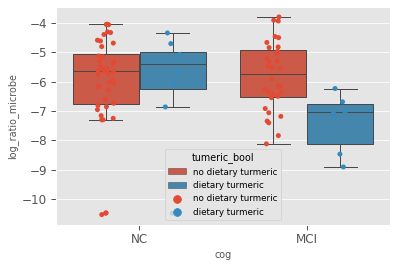

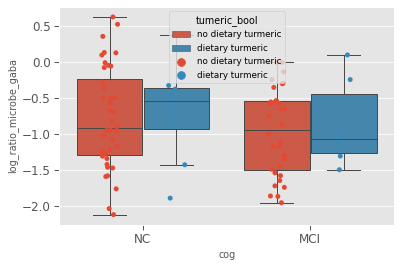

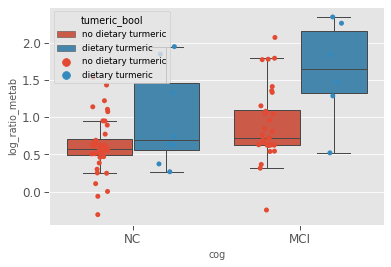

In [1662]:
sns.boxplot(x='cog', hue='tumeric_bool', y='log_ratio_microbe', data=mflr_metag, showfliers=False)
sns.stripplot(x='cog', hue='tumeric_bool', dodge=True, y='log_ratio_microbe', data=mflr_metag)

plt.show()


sns.boxplot(x='cog', hue='tumeric_bool', y='log_ratio_microbe_gaba', data=mflr_metag, showfliers=False)
sns.stripplot(x='cog', hue='tumeric_bool', dodge=True, y='log_ratio_microbe_gaba', data=mflr_metag)

plt.show()



sns.boxplot(x='cog', hue='tumeric_bool', y='log_ratio_metab',  data=mflr_metag, showfliers=False)
sns.stripplot(x='cog',hue='tumeric_bool', y='log_ratio_metab', dodge=True, data=mflr_metag)

plt.show()


In [1631]:
{k:ttest_ind(v.loc[v.tumeric_bool=='no dietary turmeric','log_ratio_microbe'].dropna().values,
             v.loc[v.tumeric_bool=='dietary turmeric','log_ratio_microbe'].dropna().values, equal_var=False)
 for k, v in mflr_metag.groupby('cog')}


{'MCI': Ttest_indResult(statistic=3.3437117909078555, pvalue=0.01123327517726319),
 'NC': Ttest_indResult(statistic=0.047213632597274506, pvalue=0.9633778370602359)}

In [1632]:
{k:ttest_ind(v.loc[v.tumeric_bool=='no dietary turmeric','log_ratio_microbe_gaba'].dropna().values,
             v.loc[v.tumeric_bool=='dietary turmeric','log_ratio_microbe_gaba'].dropna().values, equal_var=False)
 for k, v in mflr_metag.groupby('cog')}


{'MCI': Ttest_indResult(statistic=1.2786979552377593, pvalue=0.2413051652596644),
 'NC': Ttest_indResult(statistic=-0.024140487431685533, pvalue=0.9812684088913195)}

In [1633]:
{k:ttest_ind(v.loc[v.tumeric_bool=='no dietary turmeric','log_ratio_metab'].dropna().values,
             v.loc[v.tumeric_bool=='dietary turmeric','log_ratio_metab'].dropna().values, equal_var=False)
 for k, v in mflr_metag.groupby('cog')}


{'MCI': Ttest_indResult(statistic=-2.4954361670217575, pvalue=0.04674437605864061),
 'NC': Ttest_indResult(statistic=-1.4985644211692213, pvalue=0.17266081041248527)}

In [1384]:
moore_lm = ols('log_ratio_microbe ~ cog * tumeric_bool', data=mflr_metag).fit()
table = sm.stats.anova_lm(moore_lm, typ=2) 
table



sum_sq    df         F    PR(>F)
cog                 0.024862   1.0  0.011027  0.916626
tumeric_bool        1.174124   1.0  0.520743  0.472578
cog:tumeric_bool    0.968527   1.0  0.429557  0.514041
Residual          184.886203  82.0       NaN       NaN

13662.5556620    False
13662.5555663     True
13662.5556614    False
13662.5555659    False
13662.5555660    False
                 ...  
13662.5556832    False
13662.5556860     True
13662.5556910    False
13662.5556911    False
13662.5556883    False
Name: tumeric_bool, Length: 86, dtype: Sparse[object, False]

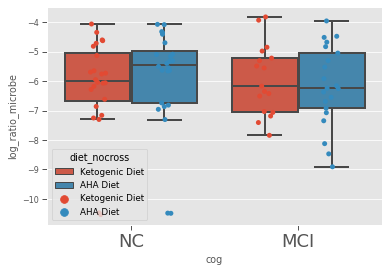

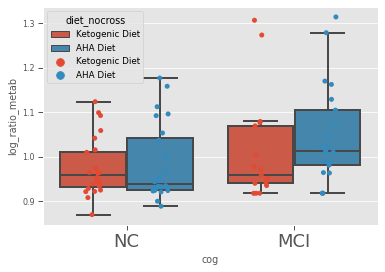

In [1362]:
sns.boxplot(x='cog', hue='diet_nocross', y='log_ratio_microbe', data=mflr_metag, showfliers=False)
sns.stripplot(x='cog', hue='diet_nocross', dodge=True, y='log_ratio_microbe', data=mflr_metag)

plt.show()


sns.boxplot(x='cog', hue='diet_nocross', y='log_ratio_metab',  data=mflr_metag, showfliers=False)
sns.stripplot(x='cog',hue='diet_nocross', y='log_ratio_metab', dodge=True, data=mflr_metag)

plt.show()

In [1360]:
mflr_metag.columns

Index(['age', 'anonymized_name', 'bmi_pbl', 'box_name', 'cog_visit_date',
       'collection_timestamp', 'description', 'elevation', 'empo_1', 'empo_2',
       'empo_3', 'env_biome', 'env_feature', 'env_material', 'env_package',
       'first_diet', 'gender', 'geo_loc_name', 'host_age', 'host_age_units',
       'host_body_habitat', 'host_body_mass_index', 'host_body_product',
       'host_body_site', 'host_common_name', 'host_height',
       'host_height_units', 'host_life_stage', 'host_scientific_name',
       'host_subject_id', 'host_taxid', 'host_weight', 'host_weight_units',
       'latitude', 'longitude', 'memdx', 'physical_specimen_location',
       'plasma', 'plasma_serum_box', 'plasma_serum_position', 'position',
       'qiita_study_id', 'sample_type', 'scientific_name', 'serum', 'sex',
       'specimen_quantity', 'status', 'stool', 'stool_box', 'stool_position',
       'taxon_id', 'timepoint', 'title', 'tube_id', 'uom', 'visit_type', 'cog',
       'diet', 'diet_nocross', 'time

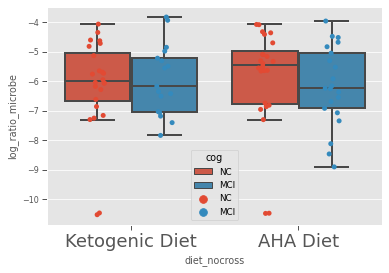

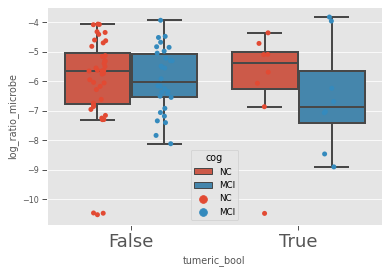

In [1346]:

sns.boxplot(x='diet_nocross', hue='cog', y='log_ratio_microbe', data=mflr_metag, showfliers=False)
sns.stripplot(x='diet_nocross', hue='cog', dodge=True, y='log_ratio_microbe', data=mflr_metag)

plt.show()





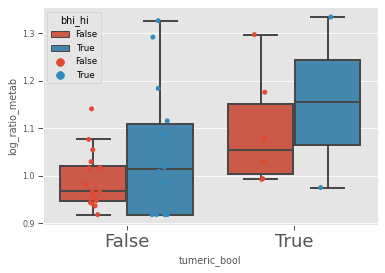

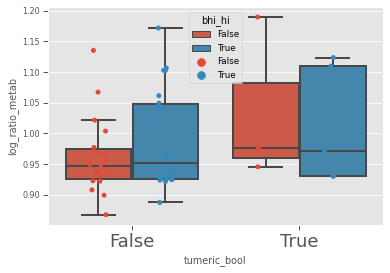

In [1348]:
mflr_metag_ = mflr_metag[mflr_metag.cog == 'MCI']
sns.boxplot(x='tumeric_bool', hue='bhi_hi', y='log_ratio_metab',  data=mflr_metag_, showfliers=False)
sns.stripplot(x='tumeric_bool',hue='bhi_hi', y='log_ratio_metab', dodge=True, data=mflr_metag_)

plt.show()


mflr_metag_ = mflr_metag[mflr_metag.cog == 'NC']
sns.boxplot(x='tumeric_bool', hue='bhi_hi', y='log_ratio_metab',  data=mflr_metag_, showfliers=False)
sns.stripplot(x='tumeric_bool',hue='bhi_hi', y='log_ratio_metab', dodge=True, data=mflr_metag_)

plt.show()




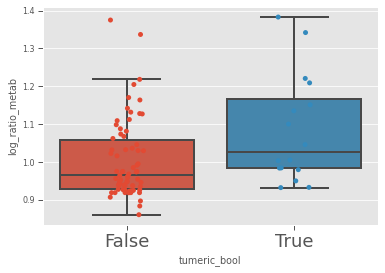

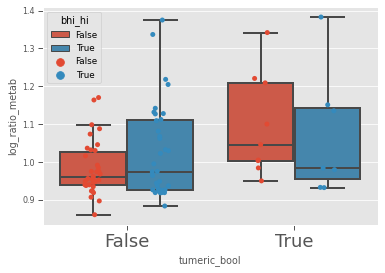

In [1324]:

sns.boxplot(x='tumeric_bool', y='log_ratio_metab',  data=mflr_metag, showfliers=False)
sns.stripplot(x='tumeric_bool', y='log_ratio_metab', data=mflr_metag)

plt.show()

sns.boxplot(x='tumeric_bool', hue='bhi_hi', y='log_ratio_metab',  data=mflr_metag, showfliers=False)
sns.stripplot(x='tumeric_bool', hue='bhi_hi', dodge=True, y='log_ratio_metab', data=mflr_metag)

plt.show()


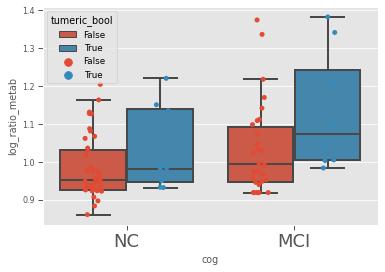

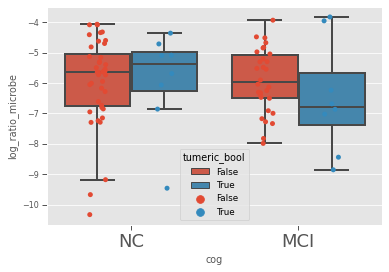

In [1325]:
sns.boxplot(x='cog', y='log_ratio_metab', hue='tumeric_bool', data=mflr_metag, showfliers=False)
sns.stripplot(x='cog', y='log_ratio_metab', hue='tumeric_bool', dodge=True, data=mflr_metag)

plt.show()

sns.boxplot(x='cog', y='log_ratio_microbe', hue='tumeric_bool', data=mflr_metag, showfliers=False)
sns.stripplot(x='cog', y='log_ratio_microbe', hue='tumeric_bool', dodge=True, data=mflr_metag)

plt.show()


In [ ]:
denom_use = ['Clostridium sp. CAG:568','Alistipes sp. CAG:514']
num_use = ['Akkermansia muciniphila']
num_use = ['Akkermansia muciniphila', 'Dialister invisus',
          'Alistipes sp. CAG:514', 
          'Akkermansia muciniphila CAG:154',
          'Clostridium sp. CAG:568',
          'Akkermansia muciniphila',
          'Akkermansia sp. UNK.MGS-1']

In [1061]:
protein_names = pd.read_csv('../data/wol/metacyc/protein_name.txt', sep='\t', header=None)



0  \
0      1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER   
1                                1-PFK-MONOMER   
2             2-DEHYDROPANTOATE-REDUCT-MONOMER   
3                 2-ISOPROPYLMALATESYN-MONOMER   
4     2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER   
...                                        ...   
6508                        ZALPHACOTE-MONOMER   
6509                         ZBETACOTE-MONOMER   
6510                              ZNUA-MONOMER   
6511                              ZNUB-MONOMER   
6512                              ZNUC-MONOMER   

                                                      1  
0     1-acylglycerol-3-phosphate <i>O</i>-acyltransf...  
1                                 1-phosphofructokinase  
2                         2-dehydropantoate 2-reductase  
3                            2-isopropylmalate synthase  
4     bifunctional 2-octaprenyl-6-methoxy-1,4-benzoq...  
...                                                 ...  
6508  terephthalate 1,2-dioxygenase oxygenase compon...  
6509  terephthalate 1,2-dioxygenase oxygenase compon...  
6510  Zn<sup>2+</sup> ABC transporter periplasmic bi...  
6511   Zn<sup>2+</sup> ABC transporter membrane subunit  
6512  Zn<sup>2+</sup> ABC transporter ATP binding su...  

[6513 rows x 2 columns]

In [1056]:
genome_to_prot


0                           1                  2
0        G000168735_6798             EG11852-MONOMER          [EG11852]
1        G000168735_6747  UDP-NACMUR-ALA-LIG-MONOMER          [EG10619]
2        G000168735_6656                LEUC-MONOMER          [EG11576]
3        G000168735_6648               MONOMER-18988          [G-43727]
4        G000168735_6619             EG10909-MONOMER          [EG10909]
...                  ...                         ...                ...
2213793   G002018015_815     SYNPCC7942_2048-MONOMER  [SYNPCC7942_2048]
2213794  G002018015_1011     SYNPCC7942_0337-MONOMER  [SYNPCC7942_0337]
2213795  G002018015_1012     SYNPCC7942_0336-MONOMER  [SYNPCC7942_0336]
2213796  G002018015_1016     SYNPCC7942_0332-MONOMER  [SYNPCC7942_0332]
2213797  G002018015_1441     SYNPCC7942_2322-MONOMER  [SYNPCC7942_2322]

[2211016 rows x 3 columns]

In [971]:
food_counts.columns

Index(['13662.5556702', '13662.5556893', '13662.5556894', '13662.5556689',
       '13662.5556667', '13662.5556670', '13662.5556668', '13662.5556718',
       '13662.5556747', '13662.5556656', '13662.5556614', '13662.5556617',
       '13662.5556892', '13662.5556760', '13662.5556625', '13662.5556733',
       '13662.5556778', '13662.5556652', '13662.5556845', '13662.5556655',
       '13662.5556862', '13662.5556703', '13662.5556687', '13662.5556846',
       '13662.5555661', '13662.5556800', '13662.5556795', '13662.5556791',
       '13662.5556830', '13662.5556831', '13662.5556911', '13662.5556704',
       '13662.5556734', '13662.5556861', '13662.5556701', '13662.5556731',
       '13662.5556815', '13662.5556777', '13662.5556620', '13662.5556686',
       '13662.5556669', '13662.5556775', '13662.5556764', '13662.5556776',
       '13662.5556623', '13662.5555659', '13662.5556716', '13662.5556883',
       '13662.5556638', '13662.5556640', '13662.5556907', '13662.5556816',
       '13662.5556719', '

In [969]:
mflr_metag

age anonymized_name bmi_pbl           box_name cog_visit_date  \
13662.5556620  62         1263002   21.62  31102 Stool Box 1         6/8/15   
13662.5555663  62         1263001   27.92  31102 Stool Box 1         8/3/15   
13662.5556614  62         1263002   21.62  31102 Stool Box 1        3/10/15   
13662.5555659  62         1263001   27.92  31102 Stool Box 1         2/4/15   
13662.5555660  62         1263001   27.92  31102 Stool Box 1        3/24/15   
...            ..             ...     ...                ...            ...   
13662.5556832  84         1263026   25.97  31102 Stool Box 1       11/18/16   
13662.5556860  62         1263028      34  31102 Stool Box 2        6/15/16   
13662.5556910  67         1263039   24.35  31102 Stool Box 2        2/13/17   
13662.5556911  67         1263039   24.35  31102 Stool Box 2         4/3/17   
13662.5556883  65         1263032   32.06  31102 Stool Box 2        10/4/16   

              collection_timestamp                             description  \
13662.5556620           2015-06-08  fecal sample FU 2 / Pre 1  3JXAL000304   
13662.5555663           2015-08-04           fecal sample FU 2 3AWFR000081   
13662.5556614           2015-03-16          fecal sample Pre 2 3JXAL000304   
13662.5555659           2015-02-11          fecal sample Pre 1 3AWFR000081   
13662.5555660           2015-03-25         fecal sample Post 1 3AWFR000081   
...                            ...                                     ...   
13662.5556832           2016-11-18         fecal sample Post 2 3JACA001152   
13662.5556860           2016-06-22         fecal sample Post 2 3JRWE000881   
13662.5556910           2017-02-20         fecal sample Post 2 3RHHO001472   
13662.5556911           2017-04-04           fecal sample FU 2 3RHHO001472   
13662.5556883           2016-10-04         fecal sample Post 1 3MRHA001153   

               elevation           empo_1  empo_2  ... visit_type  cog  \
13662.5556620      300.0  Host-associated  Animal  ...   PREB-COG   NC   
13662.5555663      300.0  Host-associated  Animal  ...   POSTB-FU  MCI   
13662.5556614      300.0  Host-associated  Animal  ...   PREA-COG   NC   
13662.5555659      300.0  Host-associated  Animal  ...   PreA-Cog  MCI   
13662.5555660      300.0  Host-associated  Animal  ...  POSTA-COG  MCI   
...                  ...              ...     ...  ...        ...  ...   
13662.5556832      300.0  Host-associated  Animal  ...  POSTB-COG   NC   
13662.5556860      300.0  Host-associated  Animal  ...  POSTA-COG  MCI   
13662.5556910      300.0  Host-associated  Animal  ...  POSTB-COG  MCI   
13662.5556911      300.0  Host-associated  Animal  ...   POSTB-FU  MCI   
13662.5556883      300.0  Host-associated  Animal  ...  POSTB-COG  MCI   

                                diet    diet_nocross timepoint_encoded  \
13662.5556620  AHA-to-Keto Crossover  Ketogenic Diet               3.0   
13662.5555663               AHA Diet        AHA Diet               5.0   
13662.5556614               AHA Diet        AHA Diet               1.0   
13662.5555659         Ketogenic Diet  Ketogenic Diet               1.0   
13662.5555660         Ketogenic Diet  Ketogenic Diet               2.0   
...                              ...             ...               ...   
13662.5556832               AHA Diet        AHA Diet               4.0   
13662.5556860               AHA Diet        AHA Diet               2.0   
13662.5556910               AHA Diet        AHA Diet               4.0   
13662.5556911               AHA Diet        AHA Diet               5.0   
13662.5556883         Ketogenic Diet  Ketogenic Diet               4.0   

               log_ratio_microbe log_ratio_metab tumeric_log_ratio  log_ratio  \
13662.5556620           2.463741        0.631731          0.000000   0.631731   
13662.5555663           2.928637        2.980846     287567.223477   2.980846   
13662.5556614           4.888446        0.277944          0.000000   0.277944   
13662.5555659           4.

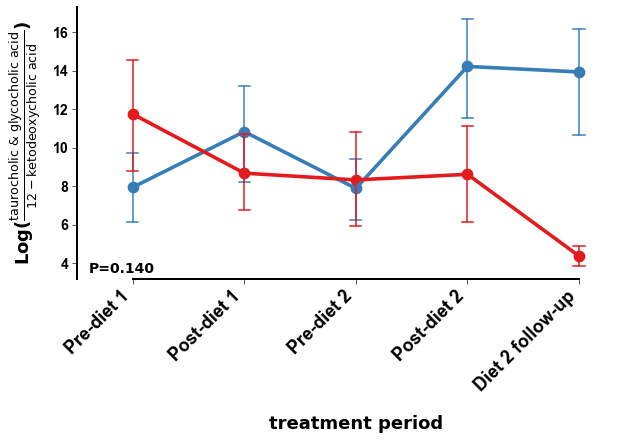

In [905]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, ax = plt.subplots(1,1, figsize=(10, 5), sharex=True)


orddf = mflr_metag.copy()

label_x = 'Log($\\frac{\mathrm{taurocholic\,\,&\,\,glycocholic\,\,acid}}{\mathrm{12-ketodeoxycholic\,\,acid}}$)'

#sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
#             data=orddf, color='black', ci=68, ax=ax,
#              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='cog',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=18)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
#                             orddf['log_ratio'].max().round(1) - 2)
#ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
#             orddf['log_ratio'].max().round(1) - 2)
if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:],
                       [l.replace('NC','CN') for l in labels[:]],
                       loc=2, 
                             bbox_to_anchor=(0.25, 1.3),
                             prop={'size':20},
                             title="Cognition:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)

    #ax.spines['left'].set_bounds(-10, 0)
    #ax.set_ylim(-10, 0)

    orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
    orddf['Sequence'] = orddf['first_diet']
    orddf['Diet'] = orddf['diet_nocross']
    md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                     orddf,
                     groups=orddf["host_subject_id"])
    mdf = md.fit()
    mdf_table = mdf.summary().tables[1]
    p_str = "P=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
    ax.text(-.1, 4, p_str, fontsize=14,
                horizontalalignment='center',
                color='black', weight='semibold')


else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

    orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
    orddf['Sequence'] = orddf['first_diet']
    orddf['Diet'] = orddf['diet_nocross']
    md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                     orddf,
                     groups=orddf["host_subject_id"])
    mdf = md.fit()
    mdf_table = mdf.summary().tables[1]
    p_str = "P=%s" % mdf_table.loc['cog[T.NC]', 'P>|z|']
    ax.text(-.1, 3.5, p_str, fontsize=14,
                horizontalalignment='center',
                color='black', weight='semibold')


plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()

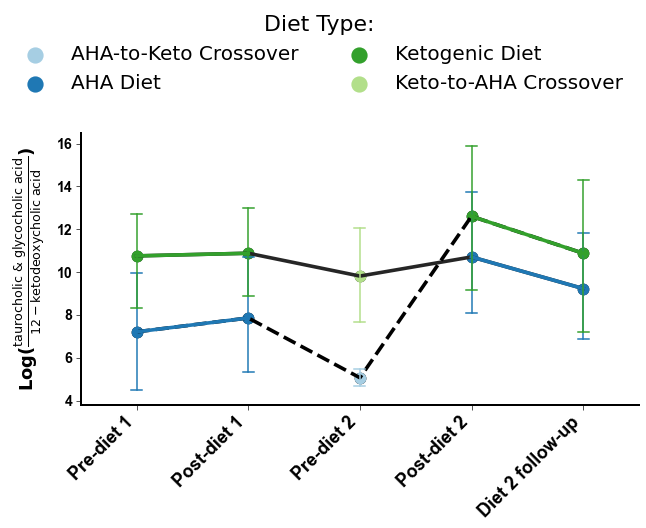

In [906]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)



axn_i = 0

orddf = mflr_metag.copy()

"""denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
num_use_label = [x.replace('[', '').replace(']', '') for x in num_]

label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
"""
label_x = 'Log($\\frac{\mathrm{taurocholic\,\,&\,\,glycocholic\,\,acid}}{\mathrm{12-ketodeoxycholic\,\,acid}}$)'


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 
                 3:'Pre-diet 2', 4:'Post-diet 2', 
                 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=18)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(0, 8)
ax.set_ylim(0, 8)"""

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[2:], labels[2:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                 orddf,
                 groups=orddf["host_subject_id"])
mdf = md.fit()
mdf_table = mdf.summary().tables[1]

"""for x_i, ind in enumerate(['Period[T.Pre-diet 1]', 'Period[T.Post-diet 1]',
                           'Period[T.Pre-diet 2]', 'Period[T.Post-diet 2]']):

    p_str = "P=%s" % (mdf_table.loc[ind, 'P>|z|'])
    ax.text(x_i , 0.5e6,
            p_str,
            horizontalalignment='center',
            size='medium', color='black', weight='semibold')
"""
    
plt.show()

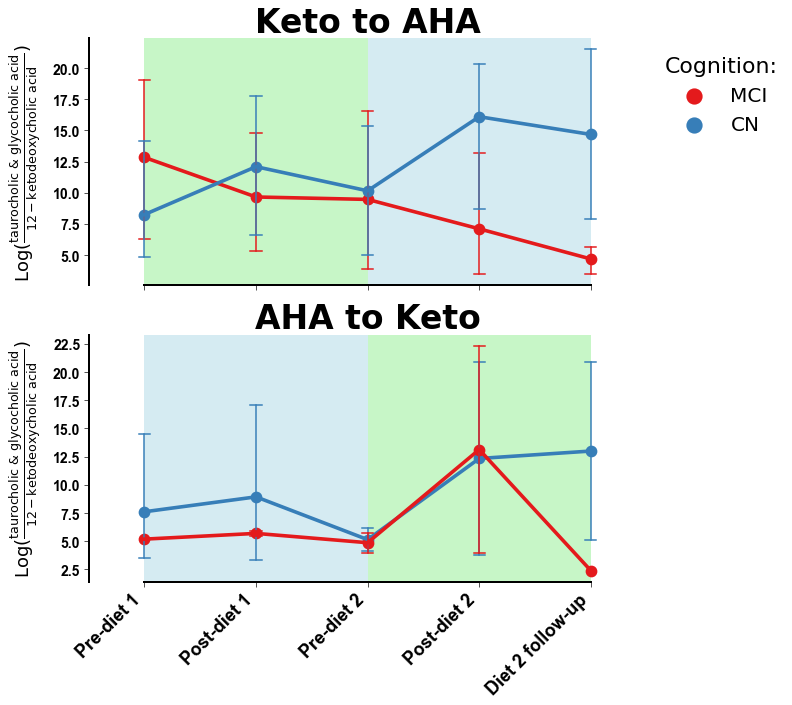

In [907]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,1, figsize=(10,10), sharex=True)

subset_use = [1, 2]
subset_use_label = {1.0:'Keto to AHA', 2.0:'AHA to Keto'}

for (axn_i, ax), fsub in zip(enumerate(axn.flatten()), subset_use):

    orddf = mflr_metag.copy().dropna(subset=['first_diet'])
    orddf = orddf[orddf.first_diet == fsub]

    #if fsub == 2:
    #    orddf = orddf[~((orddf.timepoint_encoded == 5.0) & (orddf.cog == 'MCI'))]
    
    ax.set_title(subset_use_label[fsub],
                  color='black',
                  weight='bold',
                  fontsize=33)
    
    if fsub == 1:
        # keto
        ax.axvspan(0, 2, facecolor='lightgreen', alpha=0.5)
        # low-fat
        ax.axvspan(2, 4, facecolor='lightblue', alpha=0.5)
    else:
        # low-fat
        ax.axvspan(0, 2, facecolor='lightblue', alpha=0.5)
        # keto
        ax.axvspan(2, 4, facecolor='lightgreen', alpha=0.5)

    denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in num_]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    #label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
    #                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
    label_x = 'Log($\\frac{\mathrm{taurocholic\,\,&\,\,glycocholic\,\,acid}}{\mathrm{12-ketodeoxycholic\,\,acid}}$)'


    
    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded',
                  hue='cog',
                 data=orddf, palette=cmap_man,
                  ci=95, ax=ax,
                 errwidth=1.5,
                  capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='normal',
                  labelpad=10,
                  fontsize=18)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    """ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
                                 orddf['log_ratio'].max().round(1) - 2)
    ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
                 orddf['log_ratio'].max().round(1) - 2)"""

    if axn_i < 2:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.legend_.remove()
        if axn_i== 0:

            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[:],
                               [l.replace('NC','CN') for l in labels[:]],
                               loc=2, 
                                     bbox_to_anchor=(1, 1.),
                                     prop={'size':20},
                                     title="Cognition:",
                                     fancybox=False, framealpha=.0,
                                     ncol=1, markerscale=1.5)
            legend.get_title().set_fontsize('22')
            # increase the line width in the legend 
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        ax.legend_.remove()
    
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    
    

plt.show()

In [710]:
pd.read_excel('../data/BEAM_meta_data_071221.xls', sheet_name='CSF Biomarkers')

SubjectID  Sex  StudyID  Group  Age   E4  First_Diet  ab_40_pre1  \
0   3AWFR0081    1  1263001    3.0   62  0.0         1.0     6131.10   
1   3JXAL0304    1  1263002    2.0   62  0.0         2.0     8883.32   
2   3KACO0702    2  1263004    NaN   68  NaN         NaN         NaN   
3   3EDAE0165    2  1263005    NaN   56  1.0         NaN         NaN   
4   3BLFO0040    2  1263007    3.0   64  0.0         1.0    13258.99   
5   3RSAD0710    2  1263008    NaN   76  NaN         NaN         NaN   
6   3JMCO0722    2  1263009    2.0   67  0.0         1.0    23602.00   
7   3BSLA0746    2  1263011    2.0   63  0.0         2.0     7239.98   
8   3ECHA0227    2  1263012    1.0   82  0.0         0.0     5050.45   
9   3EHRI0773    2  1263013    2.0   72  0.0         1.0    11452.56   
10  3VDOV0002    2  1263014    3.0   58  0.0         0.0         NaN   
11  3CBSH0827    2  1263016    2.0   65  1.0         2.0    14404.57   
12  3TFBO0818    1  1263017    2.0   66  0.0         1.0    16307.59   
13  3LDST0772    2  1263018    3.0   65  1.0         1.0     5450.88   
14  3LDMO0125    2  1263019    3.0   57  0.0         1.0         NaN   
15  3KXCH0169    2  1263020    3.0   59  0.0         1.0    10642.79   
16  3CDMA0951    2  1263021    2.0   55  0.0         2.0     8960.55   
17  3JEBA0908    2  1263022    2.0   53  1.0         NaN     9935.80   
18  3FHGO0392    2  1263023    2.0   63  0.0         2.0     6919.95   
19  3BCCR1024    2  1263024    2.0   60  0.0         1.0     7573.66   
20  3JACA1152    2  1263026    2.0   84  1.0         1.0         NaN   
21  3PXMC1157    2  1263027    2.0   57  NaN         1.0    13217.23   
22  3JRWE0881    1  1263028    3.0   62  0.0         2.0    11561.51   
23  3KPMC0008    1  1263030    2.0   55  0.0         NaN     8230.79   
24  3RAKO0159    2  1263031    1.0   60  1.0         0.0     1265.52   
25  3MRHA1153    2  1263032    3.0   65  1.0         2.0     2533.64   
26  3RLSI1164    2  1263034    3.0   70  1.0         2.0     3040.81   
27  3GRCA1196    1  1263035    1.0   61  0.0         NaN         NaN   
28  3LCPI1174    2  1263036    1.0   55  0.0         NaN         NaN   

    tau_pre1  AB_42_pre1  ...  ab42_40_ratio_post2_log  \
0      27.77      241.20  ...                -1.396674   
1      34.90      397.05  ...                -0.845199   
2        NaN         NaN  ...                      NaN   
3        NaN         NaN  ...                      NaN   
4      84.91      303.26  ...                -1.249690   
5        NaN         NaN  ...                      NaN   
6      96.09      282.98  ...                -1.719874   
7      21.45      247.15  ...                -0.988710   
8        NaN         NaN  ...                      NaN   
9      23.00      334.74  ...                -1.501245   
10       NaN         NaN  ...                      NaN   
11     22.11      288.51  ...                -1.520296   
12     11.86      253.82  ...                -1.481343   
13     14.43      318.73  ...                -1.554498   
14       NaN         NaN  ...                -0.881597   
15     63.28      371.32  ...                -1.257897   
16     37.95      444.14  ...                -1.220228   
17       NaN         NaN  ...                      NaN   
18     29.21      371.99  ...                -1.388374   
19       NaN         NaN  ...                -1.072472   
20       NaN         NaN  ...                      NaN   
21       NaN      221.10  ...                      NaN   
22       NaN         NaN  ...                      NaN   
23     34.29      294.62  ...                      NaN   
24     25.07      236.83  ...                      NaN   
25     32.13      322.88  ...                      NaN   
26     31.73      217.32  ...                      NaN   
27       NaN         NaN  ...                      NaN   
28       NaN         NaN  ...                      NaN   

    ab42_ptau_ratio_post2_log  ptau_tau_ratio_post2_log  NFL_PostLF_log  \
0                    1.1086

In [ ]:
CSF Biomarkers.

In [45]:
taxonomy[taxonomy.species.isin(num_use)]

Taxon   kingdom  \
Feature ID                                                                
G000020225  k__Bacteria; p__Verrucomicrobia; c__Verrucomic...  Bacteria   
G000160055  k__Bacteria; p__Firmicutes; c__Negativicutes; ...  Bacteria   
G000431015  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...  Bacteria   
G000434395  k__Bacteria; p__Firmicutes; c__Clostridia; o__...  Bacteria   
G000436395  k__Bacteria; p__Verrucomicrobia; c__Verrucomic...  Bacteria   
G000723745  k__Bacteria; p__Verrucomicrobia; c__Verrucomic...  Bacteria   
G000980515  k__Bacteria; p__Verrucomicrobia; c__Verrucomic...  Bacteria   

                     phylum             class               order  \
Feature ID                                                          
G000020225  Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   
G000160055       Firmicutes     Negativicutes      Veillonellales   
G000431015    Bacteroidetes       Bacteroidia       Bacteroidales   
G000434395       Firmicutes        Clostridia       Clostridiales   
G000436395  Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   
G000723745  Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   
G000980515  Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   

                     family        genus                          species  \
Feature ID                                                                  
G000020225  Akkermansiaceae  Akkermansia          Akkermansia muciniphila   
G000160055  Veillonellaceae    Dialister                Dialister invisus   
G000431015    Rikenellaceae    Alistipes            Alistipes sp. CAG:514   
G000434395   Clostridiaceae  Clostridium          Clostridium sp. CAG:568   
G000436395  Akkermansiaceae  Akkermansia  Akkermansia muciniphila CAG:154   
G000723745  Akkermansiaceae  Akkermansia          Akkermansia muciniphila   
G000980515  Akkermansiaceae  Akkermansia        Akkermansia sp. UNK.MGS-1   

                                                  strain  
Feature ID                                                
G000020225          Akkermansia muciniphila (G000020225)  
G000160055                Dialister invisus (G000160055)  
G000431015            Alistipes sp. CAG:514 (G000431015)  
G000434395          Clostridium sp. CAG:568 (G000434395)  
G000436395  Akkermansia muciniphila CAG:154 (G000436395)  
G000723745          Akkermansia muciniphila (G000723745)  
G000980515        Akkermansia sp. UNK.MGS-1 (G000980515)

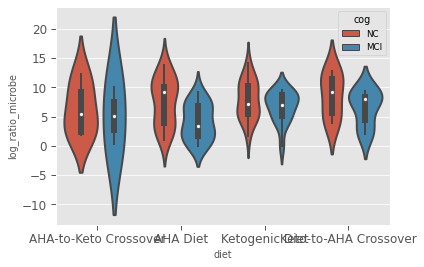

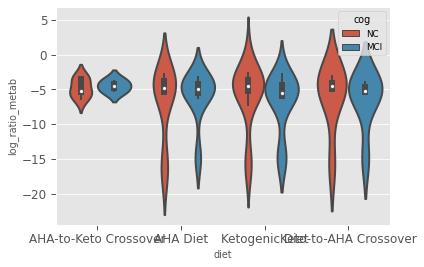

In [46]:
sns.violinplot(x='diet', y='log_ratio_microbe', hue='cog', data=mflr_metag)
plt.show()

sns.violinplot(x='diet', y='log_ratio_metab', hue='cog', data=mflr_metag)
plt.show()


{'MCI'}
0.8556490363504367


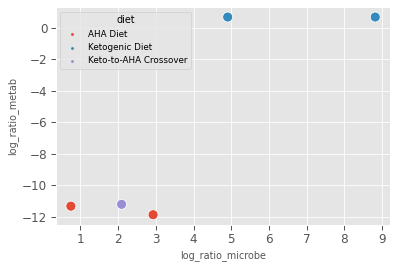

{'NC'}
0.6949196056724567


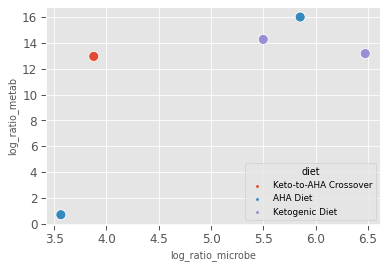

{'MCI'}
-0.25935984047722016


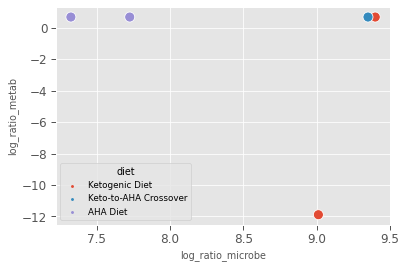

{'NC'}
0.9741380967485772


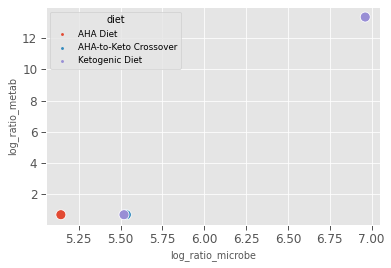

{'NC'}
0.6973020083986153


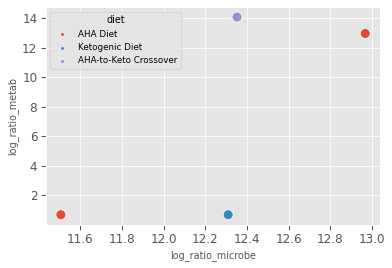

{'NC'}
-0.09831607897197125


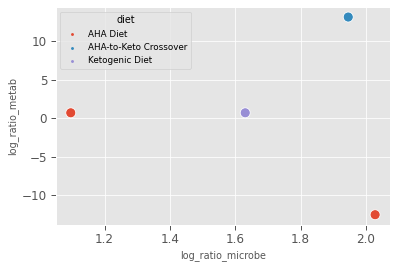

{'NC'}
0.24459450442372968


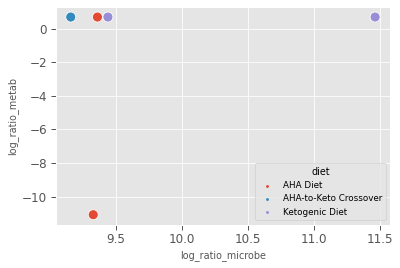

{'NC'}
0.8122238277327439


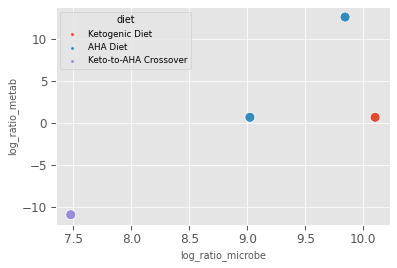

{'MCI'}
0.1891982174541145


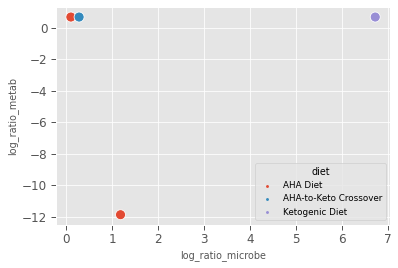

{'MCI'}
0.8391979815100848


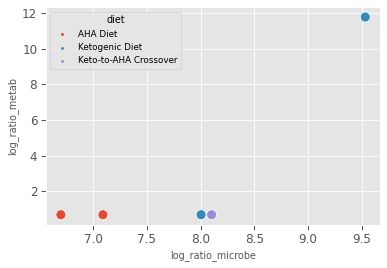

{'MCI'}
-0.5561376370398896


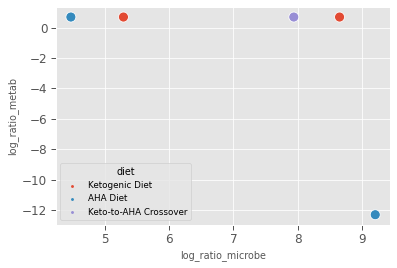

{'MCI'}
0.9581724703446305


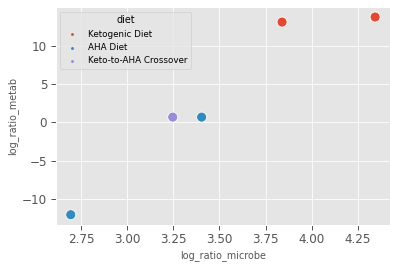

{'MCI'}
1.0


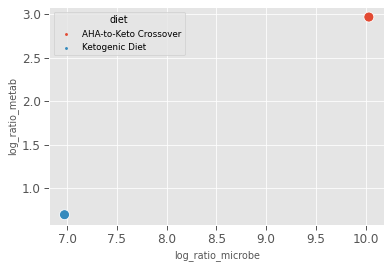

{'NC'}
-0.2738630308497609


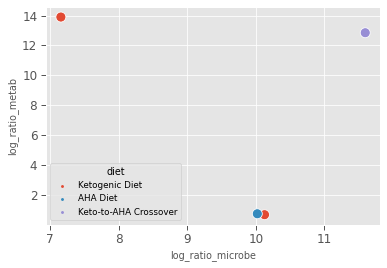

In [383]:
# Time lagged cross correlation
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

for sub, subdf in mflr_metag.groupby('host_subject_id'):
  
    if sum(subdf['log_ratio_metab'].round(2) == 0.69) == len(subdf['log_ratio_metab']):
        continue
        
        
    print(set(subdf.cog))

    x_ = subdf.sort_values(by='timepoint_encoded')['log_ratio_microbe']
    y_ = subdf.sort_values(by='timepoint_encoded')['log_ratio_metab']
    


    print(crosscorr(x_, y_))
    sns.scatterplot('log_ratio_microbe','log_ratio_metab', hue='diet', s=100, data=subdf)
    plt.show()


{'NC'}


-0.8480467826768107

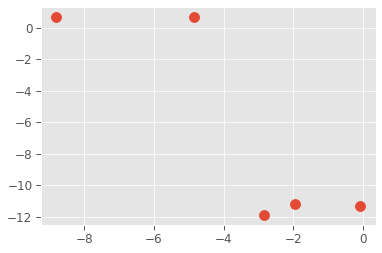

In [333]:
 x_.corr(y_)

-0.8480467826768107

In [334]:
x_

13662.5555659   -4.842874
13662.5555660   -8.814498
13662.5555661   -1.958724
13662.5555662   -0.073341
13662.5555663   -2.842680
Name: log_ratio_microbe, dtype: float64

In [330]:
y_

13662.5556715    0.693147
13662.5556716    0.693147
13662.5556717    0.693147
13662.5556719    0.693147
Name: log_ratio_metab, dtype: float64

In [295]:
mflr_metag.columns

Index(['age', 'anonymized_name', 'bmi_pbl', 'box_name', 'cog_visit_date',
       'collection_timestamp', 'description', 'elevation', 'empo_1', 'empo_2',
       'empo_3', 'env_biome', 'env_feature', 'env_material', 'env_package',
       'first_diet', 'gender', 'geo_loc_name', 'host_age', 'host_age_units',
       'host_body_habitat', 'host_body_mass_index', 'host_body_product',
       'host_body_site', 'host_common_name', 'host_height',
       'host_height_units', 'host_life_stage', 'host_scientific_name',
       'host_subject_id', 'host_taxid', 'host_weight', 'host_weight_units',
       'latitude', 'longitude', 'memdx', 'physical_specimen_location',
       'plasma', 'plasma_serum_box', 'plasma_serum_position', 'position',
       'qiita_study_id', 'sample_type', 'scientific_name', 'serum', 'sex',
       'specimen_quantity', 'status', 'stool', 'stool_box', 'stool_position',
       'taxon_id', 'timepoint', 'title', 'tube_id', 'uom', 'visit_type', 'cog',
       'diet', 'diet_nocross', 'time

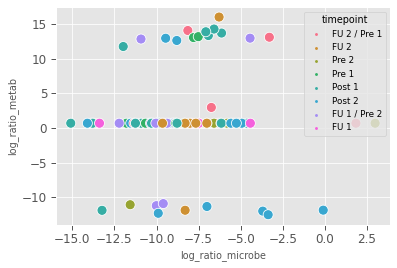

In [306]:
sns.scatterplot(x='log_ratio_microbe', y='log_ratio_metab', data=mflr_metag, s=100, hue='cog')

plt.show()
    

1.0


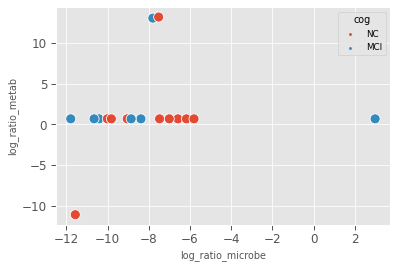

2.0


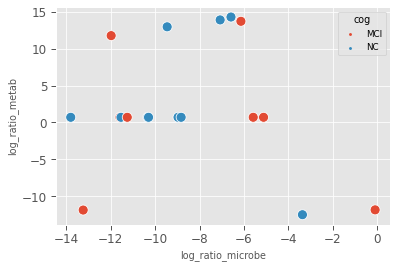

3.0


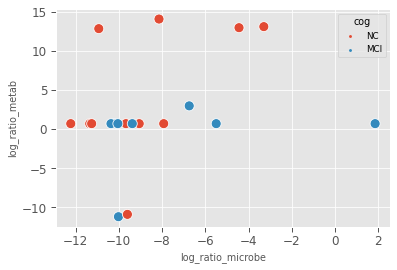

4.0


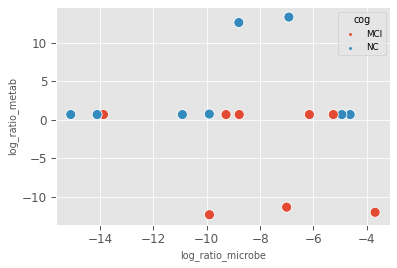

5.0


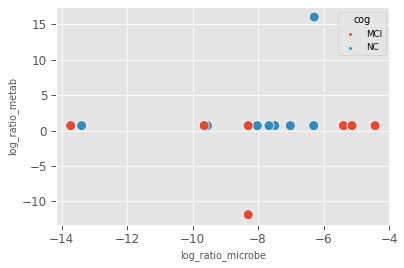

In [303]:

for k_, df_ in mflr_metag.groupby('timepoint_encoded'):

    print(k_)
    sns.scatterplot(x='log_ratio_microbe', y='log_ratio_metab', data=df_, s-)

    plt.show()


In [284]:
metadata_metag
bt_table_metag
taxonomy


Taxon   kingdom  \
Feature ID                                                                
G000005825  k__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...  Bacteria   
G000006175  k__Archaea; p__Euryarchaeota; c__Methanococci;...   Archaea   
G000006605  k__Bacteria; p__Actinobacteria; c__Actinobacte...  Bacteria   
G000006725  k__Bacteria; p__Proteobacteria; c__Gammaproteo...  Bacteria   
G000006785  k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...  Bacteria   
...                                                       ...       ...   
G900156675  k__Bacteria; p__Proteobacteria; c__Gammaproteo...  Bacteria   
G900156765  k__Bacteria; p__Bacteroidetes; c__Chitinophagi...  Bacteria   
G900156885  k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...  Bacteria   
G900156915  k__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...  Bacteria   
G900163845  k__Bacteria; p__Actinobacteria; c__Actinobacte...  Bacteria   

                    phylum                class                order  \
Feature ID                                                             
G000005825      Firmicutes              Bacilli           Bacillales   
G000006175   Euryarchaeota         Methanococci      Methanococcales   
G000006605  Actinobacteria       Actinobacteria    Corynebacteriales   
G000006725  Proteobacteria  Gammaproteobacteria      Xanthomonadales   
G000006785      Firmicutes              Bacilli      Lactobacillales   
...                    ...                  ...                  ...   
G900156675  Proteobacteria  Gammaproteobacteria    Oceanospirillales   
G900156765   Bacteroidetes        Chitinophagia      Chitinophagales   
G900156885      Firmicutes              Bacilli      Lactobacillales   
G900156915      Firmicutes              Bacilli           Bacillales   
G900163845  Actinobacteria       Actinobacteria  Propionibacteriales   

                          family            genus  \
Feature ID                                          
G000005825           Bacillaceae         Bacillus   
G000006175      Methanococcaceae    Methanococcus   
G000006605    Corynebacteriaceae  Corynebacterium   
G000006725      Xanthomonadaceae          Xylella   
G000006785      Streptococcaceae    Streptococcus   
...                          ...              ...   
G900156675    Oceanospirillaceae       Oleibacter   
G900156765      Chitinophagaceae        Filimonas   
G900156885      Lactobacillaceae    Lactobacillus   
G900156915           Bacillaceae     Aquibacillus   
G900163845  Propionibacteriaceae      Luteococcus   

                                      species  \
Feature ID                                      
G000005825              Bacillus pseudofirmus   
G000006175               Methanococcus voltae   
G000006605           Corynebacterium jeikeium   
G000006725                 Xylella fastidiosa   
G000006785             Streptococcus pyogenes   
...                                       ...   
G900156675                 Oleibacter marinus   
G900156765                  Filimonas lacunae   
G900156885  Lactobacillus sp. Marseille-P3519   
G900156915   Aquibacillus sp. Marseille-P3518   
G900163845              Luteococcus japonicus   

                                                    strain  
Feature ID                                                  
G000005825              Bacillus pseudofirmus (G000005825)  
G000006175               Methanococcus voltae (G000006175)  
G000006605           Corynebacterium jeikeium (G000006605)  
G000006725                 Xylella fastidiosa (G000006725)  
G000006785             Streptococcus pyogenes (G000006785)  
...                                                    ...  
G900156675                 Oleibacter marinus (G900156675)  
G900156765                  Filimonas lacunae (G900156765)  
G900156885  Lactobacillus sp. Marseille-P3519 (G900156885)  
G900156915   Aquibacillus sp. Marseille-P3518 (G900156915)  
G900163845              Luteococcus japonicus (G900163845)  

[7513 rows x 9 column

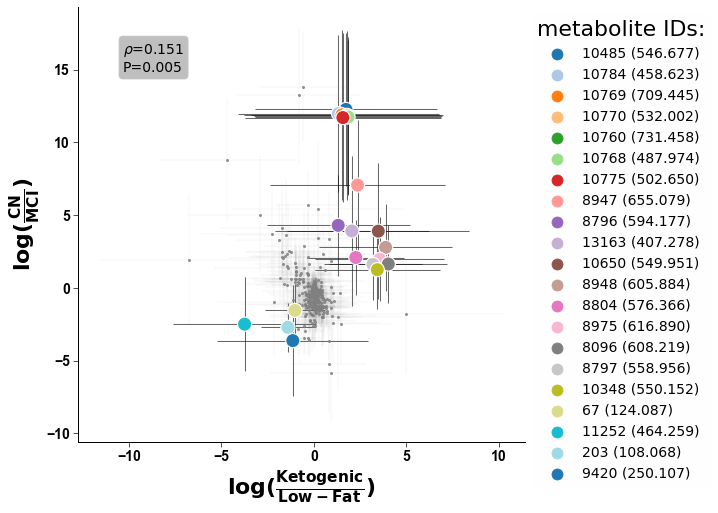

In [403]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
#micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]
micro_comparedf = diffs_metabolomics.loc[mmvec_conditionals_df_subset.index, :].copy().dropna()
micro_comparedf = micro_comparedf.drop(['13734 (149.059)'])
micro_comparedf[diff_col] -= micro_comparedf[diff_col].mean()
micro_comparedf['cog[T.NC]_mean'] -= micro_comparedf['cog[T.NC]_mean'].mean()
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]
rho_, p_ = spearmanr(micro_comparedf['cog[T.NC]_mean'].values,
                     micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].values)
stats_txt = "$\\rho$=%.3f\nP=%.3f" % (abs(rho_), p_)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
ax.text(0.1, 0.85, stats_txt, transform=ax.transAxes, bbox=props, ha='left', fontsize=14)

cut_off_x = 1
cut_off_y = 1
micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -1  * cut_off_x) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < -1  * cut_off_y) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > cut_off_x)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > cut_off_y)))]
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('ids')

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='ids', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)

handles, labels_scatter = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels_scatter[:],
                   loc=2, 
                         bbox_to_anchor=(1, 1),
                         prop={'size':14},
                         title="metabolite IDs:",
                         fancybox=True, framealpha=.01,
                         ncol=1, markerscale=5.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

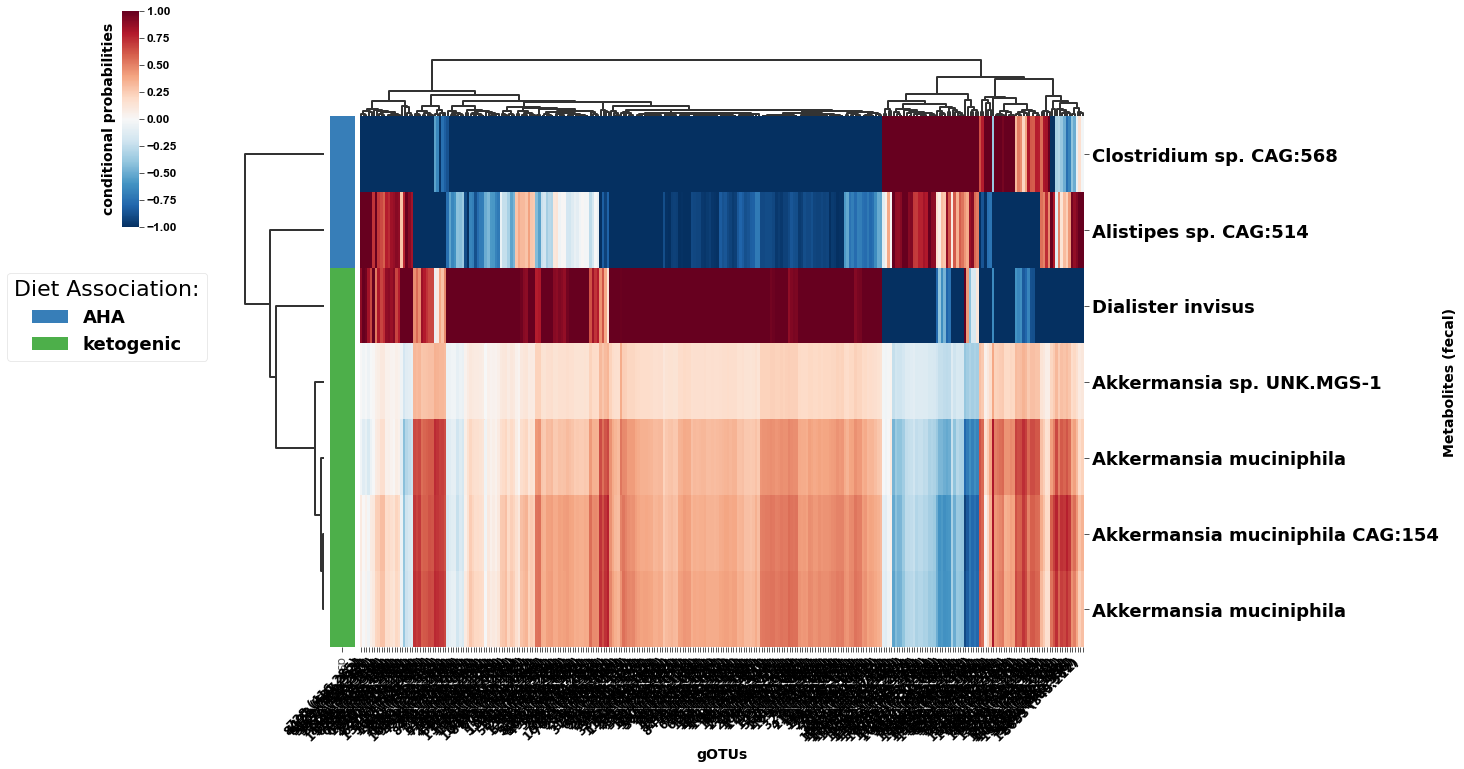

In [325]:


from matplotlib.pyplot import cm

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

color_custom = cm.ocean(np.linspace(0, .8, 100))   
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", color_custom)
mmvec_conditionals_subset = df[df.cluster.isin(['C2','C3','C4','C5'])].drop(['cluster'], axis=1)

g = sns.clustermap(mmvec_conditionals_subset.T,
                   vmax=1.0,
                   vmin=-1.0,
                   row_cluster=True,
                   col_cluster=True,
                   #col_colors=col_colors,
                   row_colors=col_colors,
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(15, 10),
                   dendrogram_ratio=.1,
                   cmap='RdBu_r',
                   z_score=1)


#legend_ = {**gene_color_map, **micro_color_map}
legend_ = { **gene_color_map}
for label in legend_.keys():
    g.ax_col_dendrogram.bar(0, 0, color=legend_[label],
                            label=label, linewidth=0)
handles, labels = g.ax_col_dendrogram.get_legend_handles_labels()
legend = g.ax_col_dendrogram.legend(handles,
                                    [l.replace('yes','ketogenic').replace('no','AHA') for l in labels],
                                    loc=2, 
                                    bbox_to_anchor=(-0.50, -2.5),
                                    title='Diet Association:',
                                    prop={'size':18, 'weight':'bold'},
                                    fancybox=True, framealpha=0.5, 
                                    ncol=1, markerscale=3,
                                    facecolor="white")
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([-.1, 0.75, .015, .3])
g.cax.set_ylabel('conditional probabilities', rotation=90, 
                 labelpad=-75,
                 fontsize=14, weight='bold', color='black')
for tick in g.cax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

    
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='black', weight='bold', ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),color='black', fontsize=18, weight='bold',)

g.ax_heatmap.set_ylabel('Metabolites (fecal)' ,color='black',weight='bold',fontsize=14)
g.ax_heatmap.set_xlabel('gOTUs' ,color='black',weight='bold',fontsize=14)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)

"""plt.savefig('../results/figures/condiational-clustermap.png',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
"""

plt.show()
